#Predicting the Presence or Absence of the Eastern Bluebird

##Introduction

Eastern Bluebird populations in the U.S. are known to be affected by factors such as habitat loss, changes in weather, and predation.  Habitat loss can be attributed to urbanization, or to intrusion of non-native birds such as House Sparrows, which are cavity nesters like bluebirds and will take over suitable nest cavities.  Eastern Bluebirds also prefer certain types of habitats.  In particular, they are often observed around edge habitats, e.g, where a tree line of a forest meets a farm field, or even a golf course.

Given data on the above factors, how well can the presence or absence of a bluebird be predicted within an area?  What are the most influential factors affecting bluebird presence or absence?  How does the presence of invasive birds rank relative to the other factors?

The following study will explore these questions by using data on bird observations and sites to model the presence/absence of the eastern bluebird.  The bird data comes from Project FeederWatch, which is a project orchestrated by the Cornell Lab of Ornithology.  With this project, the Cornell Lab collects data from thousands of locations across North America.  During each Project FeederWatch season spanning November through April, participants count the number of birds of each species they see during each observation, which takes place over a two-day period.  Within that period, participants are instructed to record the maximum number of each species observed simultaneously, which protects against counting the same bird twice.   Participants enter their data through an app.  In addition to bird counts, each observation will include:
*  Location (latitude, longitude, state)
*  Time period
*  Effort, which is a measure of the time spent by the observer over the two day period
*  Information on snow depth if any
*  Information on additional animals around such as cats
*  Description of habitat, yard, or vegetation around

Effort is a necessary measure because, as stated by Cornell Lab, “a recorded observation is a function of both the biological event (number of species actually present) and the observation process (probability that an individual, when present, will be observed).”

To begin the study, the Project FeederWatch data is prepared and then aggregated with the following supplemental data in order to capture additional information on urbanization, habitat, and weather.
*  Rural-Urban Continuum Codes and Urban-Influence Codes at the county level, sourced from the USDA.  Latitude and longitudes from the bird observation sites are mapped to the county centroids.
*  2015-2021 population estimates by county from the U.S. Census, mapped to the bird data on year, latitude, and longitude.
*  Land and water area by county from the U.S. Census, mapped to the bird data by latitude and longitude.
*  Daily minimum and maximumum temperatures, and precipitation extracted using the Applied Climate Information System (ACIS), and mapped to the bird data based on latitude, longitude, month, day, and year.


##Set up notebook

###Libraries and Settings

In [ ]:
import tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("TensorFlow version:", tensorflow.__version__)

Found GPU at: /device:GPU:0
TensorFlow version: 2.8.0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  9 14:14:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    40W / 300W |    471MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import csv
import io
import itertools
import joblib
import ast
import json
import pickle
import datetime
from datetime import datetime

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import ensemble
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
import timeit
import time
from shapely.geometry.point import Point

%matplotlib inline

In [ ]:
!pip install geopandas
import geopandas as gpd
import requests
import zipfile

!pip install mapclassify
import mapclassify

     |████████████████████████████████| 1.0 MB 14.0 MB/s 
     |████████████████████████████████| 6.3 MB 73.0 MB/s 
     |████████████████████████████████| 16.7 MB 76.6 MB/s 


In [ ]:
!pip install umap-learn
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 1.1 MB 33.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=51276651244fe92f7908dc58ad46588d4ad217411242f8a5ca55086fb60d378a
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=69e885d9b26068cf5dd719307827436952eb8801b03bd0de00f12729d2efe5dd
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
pd.set_option("display.precision", 7)

###Files

In [ ]:
fdir = "/content/drive/MyDrive/Modules/Module_30_Capstone_4_Final_project/"

b2016 = "PFW_2016_2020_public.csv"   # PFW observation data 2016-2020
b2021 = "PFW_2021_public.csv"   # PFW observation data 2021
bsite = "PFW_count_site_data_public_2021.csv"   # PFW site description data
ushp = "cb_2018_us_state_20m.zip"   # U.S. shape file

###Functions

In [ ]:
# Create df of null_names, null_counts, null_proportion, and null_dtypes
def null_summary(df):
  var_null_list = df.columns[df.isna().any()]
  var_null_names = df[var_null_list].dtypes.index
  var_null_counts = df[var_null_list].isna().sum()
  var_null_proportion = df[var_null_list].isna().sum()/df[var_null_list].isna().count()
  var_null_dtypes = df[var_null_list].dtypes
  var_null_df = pd.DataFrame({'null_names' : var_null_names, 'null_counts' : var_null_counts, 'null_proportion' : var_null_proportion, 'null_dtypes' : var_null_dtypes})
  
  return var_null_df.reset_index(drop=True)

In [ ]:
# Get Top Absolute Correlations
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [ ]:
# Given a df and a list of columns within that df, 
# return a df summarizing the unique values of the columns
def unique_summary(df, col_list):
    dict_unq = {}
    list_len = []
    for col in col_list:
        length = df[col].unique().shape[0]
        list_len.append(length)
        max_len = max(list_len)
    for col in col_list:
        add_nan = max_len - df[col].unique().shape[0]             # Fill with NaNs to make the 
        dict_unq[col] = list(df[col].unique())+[np.nan]*add_nan   # lists the same size (a requirement for the df). 
        df_unq = pd.DataFrame(dict_unq)
    return df_unq

In [ ]:
# Plot the map with coordinates from the geo_df
def plot_map(geo_df, figsize, title):
    ax = usa_sub.plot(figsize=figsize, column='ALAND', color='lightgreen', legend=False)
    usa_sub.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1)
    geo_df.plot(ax=ax, markersize=5, color='blue', marker='o')
    ax.set(xticks=[], yticks=[])   # Removes axes
    ax.set_title(title, fontsize='large')
    plt.show()

In [ ]:
# Plot counts of checklists with and without bluebirds by state
def plot_bbstate(data, suptitle, height, aspect, ymax):

    # Draw a nested barplot
    g = sns.catplot(
        data=data, kind="bar",
        x="state", y="sub_id", hue="easblu_gr",
        ci="sd", palette={0: 'darkorange', 1: 'darkblue'}, alpha=.6, height=height, aspect=aspect,
        facet_kws={'legend_out': True}
    )
    g.despine(left=True)
    g.set_axis_labels("State", "Number of Checklists")
    g.legend.set_title("")
    g.fig.suptitle(suptitle)
    new_labels = ['Bluebird Absence', 'Bluebird Presence']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    plt.ylim(0, ymax)

    plt.show()

In [ ]:
def plot_feat_imp(method, method_title, top, X):
    
    feature_importance = method.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-1*top:]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance ('+method_title+')')

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# Run a random forest classifier with GridSearchCV, fitting according to refit_score

def rf_grid_search(refit_score):

    rfc = ensemble.RandomForestClassifier(random_state=445)
    rfg = GridSearchCV(estimator=rfc, param_grid=params, scoring=scorers,
                       refit=refit_score, cv=cv, verbose=2, n_jobs=8)
    rfg.fit(X_train, y_train)

    return rfg

In [ ]:
# Run a gradient boosting classifier with GridSearchCV, fitting according to refit_score

def gb_grid_search(refit_score):

    gbc = ensemble.GradientBoostingClassifier(random_state=445)
    gbg = GridSearchCV(estimator=gbc, param_grid=params, scoring=scorers,
                       refit=refit_score, cv=cv, verbose=2, n_jobs=8)
    gbg.fit(X_train, y_train)

    return gbg

In [ ]:
# Run an ANN with param grid and return a df of results
def run_ann(params, X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(params['neuron_counts'][0], input_shape=(X_train.shape[1],), activation=params['activ_func']))
    
    for i in np.arange(1, len(params['neuron_counts'])):
        model.add(Dense(params['neuron_counts'][i], activation=params['activ_func']))

    # Set the output layer as model.add(Dense(1, activation='sigmoid')) for binary classifier
    model.add(Dense(1, activation='sigmoid'))

    if params['optimizer_learn_rate'] == 'sgd':
        optimizer_learn_rate = params['optimizer_learn_rate']
    else:
        optimizer_learn_rate = optimizers.SGD(lr=params['optimizer_learn_rate'])

    start = timeit.default_timer()

    #Set to loss='binary_crossentropy' for binary classifier
    model.compile(optimizer=optimizer_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['nb_epoch'], verbose=0)

    stop = timeit.default_timer()

    run_time = stop - start

    y_preds_test_prob = model.predict(X_test)
    # The model outputs probabilities.
    # For plotting the confusion matrix, change the output back to binary based on a decision threshold of 0.5
    y_preds_test = (y_preds_test_prob > 0.5)

    score_train = model.evaluate(X_train, y_train, verbose=0)
    score_test = model.evaluate(X_test, y_test, verbose=0)
    train_test_diff = score_train[1] - score_test[1]
    precision = precision_score(y_test, y_preds_test)
    recall = recall_score(y_test, y_preds_test)
    f1 = f1_score(y_test, y_preds_test)
    fbeta_precision = fbeta_score(y_test, y_preds_test, beta = 0.5)
    fbeta_recall = fbeta_score(y_test, y_preds_test, beta = 2.0)

    cols = ['neuron_counts', 'activ_func', 'optimizer_learn_rate', 'batch_size', 'nb_epoch', 'train_accuracy',
            'test_accuracy', 'train_test_diff', 'precision', 'recall', 'f1', 'fbeta_precision', 'fbeta_recall', 'run_time']

    results_df = pd.DataFrame(columns=cols)

    results_list = [params['neuron_counts'], params['activ_func'], params['optimizer_learn_rate'], params['batch_size'], params['nb_epoch'],
                    score_train[1], score_test[1], train_test_diff, precision, recall, f1, fbeta_precision, fbeta_recall, run_time]

    for idx, val in enumerate(results_list):
        results_df.loc[0, cols[idx]] = val

    return results_df

##EDA

###Project FeederWatch (PFW) Observation Data: explore, clean, subset

Load the PFW data for PFW seasons 2016 through 2021.

In [ ]:
# PFW_2016_2020_public.csv
pfw_2016_2020 = pd.read_csv(fdir + b2016)

# PFW_2021_public.csv
pfw_2021 = pd.read_csv(fdir + b2021)

In [ ]:
print('pfw_2016_2020 shape: {}'.format(pfw_2016_2020.shape))
print('pfw_2021 shape: {}'.format(pfw_2021.shape))
print('\n')
print('pfw_2016_2020 columns:')
print('\n')
print(pfw_2016_2020.columns)
print('\n')
print('pfw_2021 columns:')
print('\n')
print(pfw_2021.columns)

pfw_2016_2020 shape: (9172943, 23)
pfw_2021 shape: (2897105, 22)


pfw_2016_2020 columns:


Index(['LOC_ID', 'LATITUDE', 'LONGITUDE', 'SUBNATIONAL1_CODE',
       'ENTRY_TECHNIQUE', 'SUB_ID', 'OBS_ID', 'Month', 'Day', 'Year',
       'PROJ_PERIOD_ID', 'SPECIES_CODE', 'HOW_MANY', 'PLUS_CODE', 'VALID',
       'REVIEWED', 'DAY1_AM', 'DAY1_PM', 'DAY2_AM', 'DAY2_PM',
       'EFFORT_HRS_ATLEAST', 'SNOW_DEP_ATLEAST', 'Data_Entry_Method'],
      dtype='object')


pfw_2021 columns:


Index(['loc_id', 'latitude', 'longitude', 'subnational1_code',
       'entry_technique', 'sub_id', 'obs_id', 'Month', 'Day', 'Year',
       'PROJ_PERIOD_ID', 'species_code', 'how_many', 'valid', 'reviewed',
       'day1_am', 'day1_pm', 'day2_am', 'day2_pm', 'effort_hrs_atleast',
       'snow_dep_atleast', 'Data_Entry_Method'],
      dtype='object')


Make all column names lowercase.

In [ ]:
pfw_2016_2020.columns = map(str.lower, pfw_2016_2020.columns)
pfw_2021.columns = map(str.lower, pfw_2021.columns)

The column, plus_code, exists only in the 2016-2020 data.  It will not be used for this study.  Remove it.  

In [ ]:
pfw_2016_2020 = pfw_2016_2020.drop(columns = ['plus_code'])

pfw_2016_2020.sample(4)

loc_id    latitude   longitude subnational1_code  \
6479888  L3239602  42.6887250  -73.895604             US-NY   
6106731  L2679280  45.5064179 -122.873717             US-OR   
6374159  L3279420  42.5962480  -71.110561             US-MA   
3829048   L493807  42.2047330  -72.739061             US-MA   

                entry_technique     sub_id        obs_id  month  day  year  \
6479888     /GOOGLE_MAP/ZOOM:15  S28947209  OBS391263588      4    7  2016   
6106731     /GOOGLE_MAP/ZOOM:15  S27573746  OBS374120232      2   13  2016   
6374159     /GOOGLE_MAP/ZOOM:15  S44173468  OBS594601980     12   17  2017   
3829048  ESRI_WEBSERVICE_STREET  S40878056  OBS554216077     11   25  2017   

         ... how_many valid  reviewed  day1_am  day1_pm  day2_am  day2_pm  \
6479888  ...        2     1         0        1        1        1        1   
6106731  ...        5     1         0        1        1        1        1   
6374159  ...        1     1         0        1        0        1        1   
3829048  ...        1     1         0        1        1        1        1   

         effort_hrs_atleast  snow_dep_atleast  data_entry_method  
6479888               1.001               0.0        PFW Web 2.x  
6106731               1.001               0.0        PFW Web 2.x  
6374159               4.001               5.0        PFW Web 2.x  
3829048               4.001               NaN        PFW Web 2.x  

[4 rows x 22 columns]

In [ ]:
pfw_2021.sample(4)

loc_id    latitude   longitude subnational1_code  \
1446578   L2423615  35.7687359 -78.7521060             US-NC   
2111612   L8224689  42.6323011 -77.6779801             US-NY   
2286936  L10515531  37.5560604 -77.5337362             US-VA   
464951      L23280  37.5585558 -77.5373331             US-VA   

                  entry_technique     sub_id         obs_id  month  day  year  \
1446578       /GOOGLE_MAP/ZOOM:15  S85305350  OBS1118207439      4    8  2021   
2111612       /GOOGLE_MAP/ZOOM:15  S76480050  OBS1014900843     11   19  2020   
2286936       /GOOGLE_MAP/ZOOM:18  S83665265  OBS1098091679      2   28  2021   
464951   POSTCODE LAT/LONG LOOKUP  S76746713  OBS1018589440     11   23  2020   

         ... how_many valid  reviewed  day1_am  day1_pm  day2_am  day2_pm  \
1446578  ...        1     1         0        1        0        1        1   
2111612  ...        2     1         0        1        1        1        1   
2286936  ...        1     1         0        1        1        1        1   
464951   ...        2     1         0        1        0        1        0   

         effort_hrs_atleast  snow_dep_atleast  data_entry_method  
1446578               1.001               0.0      PFW Web 4.1.4  
2111612               4.001               0.0      PFW Web 4.1.4  
2286936               1.001               0.0      PFW Web 4.1.4  
464951                1.001               0.0      PFW Web 4.1.4  

[4 rows x 22 columns]

In [ ]:
pfw_2016_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172943 entries, 0 to 9172942
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loc_id              object 
 1   latitude            float64
 2   longitude           float64
 3   subnational1_code   object 
 4   entry_technique     object 
 5   sub_id              object 
 6   obs_id              object 
 7   month               int64  
 8   day                 int64  
 9   year                int64  
 10  proj_period_id      object 
 11  species_code        object 
 12  how_many            int64  
 13  valid               int64  
 14  reviewed            int64  
 15  day1_am             int64  
 16  day1_pm             int64  
 17  day2_am             int64  
 18  day2_pm             int64  
 19  effort_hrs_atleast  float64
 20  snow_dep_atleast    float64
 21  data_entry_method   object 
dtypes: float64(4), int64(10), object(8)
memory usage: 1.5+ GB


In [ ]:
pfw_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2897105 entries, 0 to 2897104
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loc_id              object 
 1   latitude            float64
 2   longitude           float64
 3   subnational1_code   object 
 4   entry_technique     object 
 5   sub_id              object 
 6   obs_id              object 
 7   month               int64  
 8   day                 int64  
 9   year                int64  
 10  proj_period_id      object 
 11  species_code        object 
 12  how_many            int64  
 13  valid               int64  
 14  reviewed            int64  
 15  day1_am             int64  
 16  day1_pm             int64  
 17  day2_am             int64  
 18  day2_pm             int64  
 19  effort_hrs_atleast  float64
 20  snow_dep_atleast    float64
 21  data_entry_method   object 
dtypes: float64(4), int64(10), object(8)
memory usage: 486.3+ MB


The datasets are now consistent and ready for concatenation.

In [ ]:
pfw = pd.concat([pfw_2016_2020, pfw_2021], ignore_index=True)

print('Shape of combined PFW data: {}'.format(pfw.shape))
print('\n')
print('Number of bird species within the data: {}'.format(pfw['species_code'].nunique()))

Shape of combined PFW data: (12070048, 22)


Number of bird species within the data: 724


Each PFW period runs from November through the following April, and is denoted by the year in which the period ends.  As a result, the data spans 7 years but only 6 periods, with the bounding years, 2015 and 2021, only partially represented in the data.  

The following list of PFW periods will be accessed throughout the notebook.

In [ ]:
periods = sorted(list(pfw['proj_period_id'].unique()))
periods

['PFW_2016', 'PFW_2017', 'PFW_2018', 'PFW_2019', 'PFW_2020', 'PFW_2021']

In [ ]:
start_year = pfw.year.min()
start_month = pfw[pfw.year == start_year].month.min()
start_day = pfw[(pfw.year == start_year) & (pfw.month == start_month)].day.min()

end_year = pfw.year.max()
end_month = pfw[pfw.year == end_year].month.max()
end_day = pfw[(pfw.year == end_year) & (pfw.month == end_month)].day.max()

print('Starting date of data: {}/{}/{}'.format(start_month, start_day, start_year))
print('\n')
print('Ending date of data: {}/{}/{}'.format(end_month, end_day, end_year))

Starting date of data: 11/1/2015


Ending date of data: 4/30/2021


Clean up NaNs.

In [ ]:
# null_summary is a function defined previously
var_null_df = null_summary(pfw)
var_null_df

null_names  null_counts  null_proportion null_dtypes
0     entry_technique       581823        0.0482039      object
1  effort_hrs_atleast        27551        0.0022826     float64
2    snow_dep_atleast      1154865        0.0956802     float64

Drop the column, entry_technique.  It will not be used in this study.

In [ ]:
pfw = pfw.drop(columns = ['entry_technique'])

Remove rows that have no record of effort.

In [ ]:
pfw = pfw.dropna(subset = ['effort_hrs_atleast'])

Zero fill the NaNs in snow_dep_atleast.

In [ ]:
pfw['snow_dep_atleast'] = pfw['snow_dep_atleast'].fillna(0)

var_null_df = null_summary(pfw)
var_null_df

Empty DataFrame
Columns: [null_names, null_counts, null_proportion, null_dtypes]
Index: []

In [ ]:
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (12042497, 21)


The data has two fields, "valid" and "reviewed", based on Cornell Lab's data flagging system:
*  VALID:  Validity of each observation based on flagging system
*  REVIEWED:  Review state of each observation based on flagging system  

In [ ]:
print("Unique combinations and of 'valid' and 'reviewed', and record counts:")
print('\n')
print(pfw.groupby(['valid','reviewed']).count().reset_index()[['valid', 'reviewed', 'sub_id']])

Unique combinations and of 'valid' and 'reviewed', and record counts:


   valid  reviewed    sub_id
0      0         0     42877
1      0         1      2959
2      1         0  11921945
3      1         1     74716


Keep only records with Valid = 1; Reviewed = 0, which is the majority of the records.

Explanation from Cornell of Valid = 1; Reviewed = 0: report did not trigger the automatic flagging system and was accepted into the database without review.

In [ ]:
pfw = pfw[(pfw['valid'] == 1) & (pfw['reviewed'] == 0)]
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (11921945, 21)


In [ ]:
pfw.subnational1_code.unique()

array(['US-FL', 'CA-ON', 'US-VA', 'US-MI', 'US-NY', 'US-PA', 'US-WA',
       'US-TX', 'US-MN', 'US-CA', 'US-CO', 'US-SC', 'US-NC', 'US-AL',
       'CA-AB', 'US-AR', 'US-IL', 'US-MD', 'US-OR', 'US-NJ', 'US-LA',
       'US-CT', 'US-WV', 'US-ID', 'US-DE', 'US-MA', 'US-IN', 'US-AZ',
       'US-OH', 'US-TN', 'US-WI', 'US-NV', 'US-VT', 'US-NM', 'US-KS',
       'US-UT', 'CA-NB', 'US-MO', 'CA-BC', 'CA-QC', 'CA-NS', 'CA-SK',
       'CA-MB', 'CA-NT', 'CA-YT', 'CA-NL', 'CA-PE', 'XX-', 'NZ-OTA',
       'CA-NU', 'US-OK', 'PM-', 'US-NE', 'US-ME', 'US-WY', 'US-NH',
       'US-ND', 'US-KY', 'US-AK', 'US-IA', 'US-SD', 'US-MT', 'US-GA',
       'US-MS', 'US-RI', 'US-HI', 'US-DC', 'MX-NAY', 'MX-JAL'],
      dtype=object)

Subset records from the U.S. (excluding Mexico and Canada), since the additional data to be aggregated is for the U.S.

In [ ]:
pfw = pfw[pfw['subnational1_code'].str.split('-').str[0].isin(['US'])]
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (10322661, 21)


In [ ]:
pfw.subnational1_code.unique()

array(['US-FL', 'US-VA', 'US-MI', 'US-NY', 'US-PA', 'US-WA', 'US-TX',
       'US-MN', 'US-CA', 'US-CO', 'US-SC', 'US-NC', 'US-AL', 'US-AR',
       'US-IL', 'US-MD', 'US-OR', 'US-NJ', 'US-LA', 'US-CT', 'US-WV',
       'US-ID', 'US-DE', 'US-MA', 'US-IN', 'US-AZ', 'US-OH', 'US-TN',
       'US-WI', 'US-NV', 'US-VT', 'US-NM', 'US-KS', 'US-UT', 'US-MO',
       'US-OK', 'US-NE', 'US-ME', 'US-WY', 'US-NH', 'US-ND', 'US-KY',
       'US-AK', 'US-IA', 'US-SD', 'US-MT', 'US-GA', 'US-MS', 'US-RI',
       'US-HI', 'US-DC'], dtype=object)

Rename the states, getting rid of the leading 'US-'

In [ ]:
split = pfw['subnational1_code'].str.split('-', n=1, expand=True)
pfw['state'] = split[1]
pfw = pfw.drop(columns = ['subnational1_code'])

pfw['state'].unique()

array(['FL', 'VA', 'MI', 'NY', 'PA', 'WA', 'TX', 'MN', 'CA', 'CO', 'SC',
       'NC', 'AL', 'AR', 'IL', 'MD', 'OR', 'NJ', 'LA', 'CT', 'WV', 'ID',
       'DE', 'MA', 'IN', 'AZ', 'OH', 'TN', 'WI', 'NV', 'VT', 'NM', 'KS',
       'UT', 'MO', 'OK', 'NE', 'ME', 'WY', 'NH', 'ND', 'KY', 'AK', 'IA',
       'SD', 'MT', 'GA', 'MS', 'RI', 'HI', 'DC'], dtype=object)

Using a longitude range, subset the data to states within the eastern bluebird's range.  The following longitude range is from the western tip of Texas to the eastern tip of Maine.

In [ ]:
pfw = pfw[(pfw['longitude'] > -106.645646) & (pfw['longitude'] < -66.949895)]
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (8821331, 21)


In [ ]:
print("Updated list of states representing the eastern bluebird's range:")
print('\n')
print(pfw['state'].unique())

Updated list of states representing the eastern bluebird's range:


['FL' 'VA' 'MI' 'NY' 'PA' 'TX' 'MN' 'CO' 'SC' 'NC' 'AL' 'AR' 'IL' 'MD'
 'NJ' 'LA' 'CT' 'WV' 'DE' 'MA' 'IN' 'OH' 'TN' 'WI' 'VT' 'KS' 'MO' 'OK'
 'NE' 'NM' 'ME' 'NH' 'ND' 'KY' 'IA' 'SD' 'GA' 'WY' 'MS' 'MT' 'RI' 'DC']


MT, WY, CO, and NM are mostly outside the eastern bluebird's range. Remove their records from the data.

In [ ]:
rem_states = ['MT', 'WY', 'CO', 'NM']
pfw = pfw[~pfw['state'].isin(rem_states)]
print("Updated list of states representing the eastern bluebird's range:")
print('\n')
print(pfw['state'].unique())
print('\n')
print('Updated shape of data: {}'.format(pfw.shape))

Updated list of states representing the eastern bluebird's range:


['FL' 'VA' 'MI' 'NY' 'PA' 'TX' 'MN' 'SC' 'NC' 'AL' 'AR' 'IL' 'MD' 'NJ'
 'LA' 'CT' 'WV' 'DE' 'MA' 'IN' 'OH' 'TN' 'WI' 'VT' 'KS' 'MO' 'OK' 'NE'
 'ME' 'NH' 'ND' 'KY' 'IA' 'SD' 'GA' 'MS' 'RI' 'DC']


Updated shape of data: (8550033, 21)


One focus of this study will be the interaction between bluebird presence/absence and the counts of non-native birds such as house sparrows and european starlings.  Therefore, filter the data down to sites that have observed at least 1 eastern bluebird, at least one house sparrow, or at least 1 european starling.
*  Eastern Bluebird species_code = easblu
*  House Sparrow species_code = houspa
*  European Starling species_code = eursta

The column, "loc_id", contains a unique identifier for each survey site.

In [ ]:
print('Number of sites before subset: {}'.format(pfw['loc_id'].nunique()))

df_gr = pfw.groupby(['loc_id', 'species_code']).sum().reset_index()
df_gr_b = df_gr[(df_gr['species_code'] == 'easblu') | (df_gr['species_code'] == 'eursta') | (df_gr['species_code'] == 'houspa')]
locs = list(df_gr_b['loc_id'].unique())

pfwb = pfw[pfw['loc_id'].isin(locs)]

print('Number of sites after subset: {}'.format(pfwb['loc_id'].nunique()))
print('\n')
print('Updated shape of data: {}'.format(pfwb.shape))

Number of sites before subset: 22388
Number of sites after subset: 18741


Updated shape of data: (8074195, 21)


Next, explore participation of the observation sites over the 6 project periods.

In [ ]:
# Get counts of PFW periods per site
perloc = pfwb.groupby('loc_id')['proj_period_id'].nunique().reset_index()

# Since there are 6 periods, periods per site is an integer from 1 to 6.
# Many of the sites haven't participated in all 6 periods.
# Now count how many sites correspond to 
# each possible value of periods per site.  
numlocsper = perloc.groupby('proj_period_id')['loc_id'].nunique().reset_index()

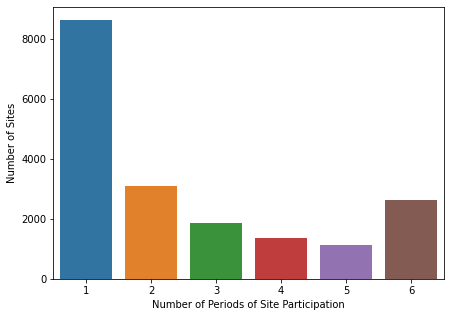

In [ ]:
plt.figure(figsize = (7,5))

sns.barplot(x="proj_period_id", y="loc_id", data=numlocsper)
plt.xlabel("Number of Periods of Site Participation")
plt.ylabel("Number of Sites")

plt.show()

The barplot shows a relatively high number of sites that, within the 6 PFW periods, only participated in one period.  To protect against bias, exclude the one-period participants.

In [ ]:
min_pers = 2   # Required minimum number of periods of site participation

# Get the unique loc_id list of all sites that meet the min_pers criteria
keep_locs = perloc[perloc.proj_period_id >= min_pers]['loc_id'].tolist()

# Subset the dataframe by that list
pfwb = pfwb[pfwb['loc_id'].isin(keep_locs)]

print('Updated number of sites: {}'.format(pfwb['loc_id'].nunique()))
print('\n')
print('Updated shape of data: {}'.format(pfwb.shape))

Updated number of sites: 10107


Updated shape of data: (7131697, 21)


Participants count the number of birds of each species they see during each observation, which takes place over a two-day period.  Within that period, participants are instructed to record the maximum number of each species observed simultaneously, which protects against counting the same bird twice.  Additionally, participants are instructed to record information on the habitat around the site.  All of the information about the observation over the two-day period is recorded on a "checklist".  The column, "sub_id", contains a unique identifier for each checklist.  Therefore, in the data, each loc_id is associated with multiple sub_id's collected throughout a November-April PFW period.

Furthermore, in its current form, the data has multiple records per checklist because each observed bird species (species_code) within a checklist is listed as a separate record labeled with a unique identifier (obs_id).  This is illustrated in the filtered dataframe below for sub_id S28051135.

In [ ]:
pfwb[pfwb.sub_id == 'S28051135']

loc_id    latitude   longitude     sub_id        obs_id  month  \
8839429  L3178670  42.2908538 -71.2535059  S28051135  OBS379926875      2   
8839430  L3178670  42.2908538 -71.2535059  S28051135  OBS379926876      2   
8839431  L3178670  42.2908538 -71.2535059  S28051135  OBS379926877      2   
8839432  L3178670  42.2908538 -71.2535059  S28051135  OBS379926878      2   
8839433  L3178670  42.2908538 -71.2535059  S28051135  OBS379926879      2   
8839434  L3178670  42.2908538 -71.2535059  S28051135  OBS379926880      2   
8839435  L3178670  42.2908538 -71.2535059  S28051135  OBS379926881      2   
8839436  L3178670  42.2908538 -71.2535059  S28051135  OBS379926882      2   
8839437  L3178670  42.2908538 -71.2535059  S28051135  OBS379926883      2   
8839438  L3178670  42.2908538 -71.2535059  S28051135  OBS379926884      2   
8839439  L3178670  42.2908538 -71.2535059  S28051135  OBS379926885      2   
8839440  L3178670  42.2908538 -71.2535059  S28051135  OBS379926886      2   
8839441  L3178670  42.2908538 -71.2535059  S28051135  OBS379926887      2   
8839442  L3178670  42.2908538 -71.2535059  S28051135  OBS379926888      2   

         day  year proj_period_id species_code  ...  valid  reviewed  day1_am  \
8839429   28  2016       PFW_2016       coohaw  ...      1         0        1   
8839430   28  2016       PFW_2016       blujay  ...      1         0        1   
8839431   28  2016       PFW_2016       tuftit  ...      1         0        1   
8839432   28  2016       PFW_2016       rebwoo  ...      1         0        1   
8839433   28  2016       PFW_2016       dowwoo  ...      1         0        1   
8839434   28  2016       PFW_2016       houspa  ...      1         0        1   
8839435   28  2016       PFW_2016       whbnut  ...      1         0        1   
8839436   28  2016       PFW_2016       daejun  ...      1         0        1   
8839437   28  2016       PFW_2016       eursta  ...      1         0        1   
8839438   28  2016       PFW_2016       moudov  ...      1         0        1   
8839439   28  2016       PFW_2016       amegfi  ...      1         0        1   
8839440   28  2016       PFW_2016       houfin  ...      1         0        1   
8839441   28  2016       PFW_2016       norcar  ...      1         0        1   
8839442   28  2016       PFW_2016       amecro  ...      1         0        1   

         day1_pm  day2_am  day2_pm  effort_hrs_atleast  snow_dep_atleast  \
8839429        1        1        1               1.001             0.001   
8839430        1        1        1               1.001             0.001   
8839431        1        1        1               1.001             0.001   
8839432        1        1        1               1.001             0.001   
8839433        1        1        1               1.001             0.001   
8839434        1        1        1               1.001             0.001   
8839435        1        1        1               1.001             0.001   
8839436        1        1        1               1.001             0.001   
8839437        1        1        1               1.001             0.001   
8839438        1        1        1               1.001             0.001   
8839439        1        1        1               1.001             0.001   
8839440        1        1        1               1.001             0.001   
8839441        1        1        1               1.001             0.001   
8839442        1        1        1               1.001             0.001   

         data_entry_method state  
8839429        PFW Web 2.x    MA  
8839430        PFW Web 2.x    MA  
8839431        PFW Web 2.x    MA  
8839432        PFW Web 2.x    MA  
8839433        PFW Web 2.x    MA  
8839434        PFW Web 2.x    MA  
8839435        PFW Web 2.x    MA  
8839436        PFW Web 2.x    MA  
8839437        PFW Web 2.x    MA  
8839438        PFW Web 2.x    MA  
8839439        PFW Web 2.x    MA  
8839440        PFW Web 2.x    MA  
8839441        PFW Web 2.x    MA  
8839442 

Next, explore the number of unique checklists per site, per PFW period.  

The following steps will perform subsets on the checklists to protect against bias.  Note that the subsets are done on unique checklists.  In other words, whenever a checklist is removed, all of its records are removed.

In [ ]:
# Regroup by site and period, and get unique counts of other fields
df_counts = pfwb.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()

print('Descriptive statistics of the number of checklists per site, per PFW period:')
print(df_counts['sub_id'].describe())

Descriptive statistics of the number of checklists per site, per PFW period:
count    38800.0000000
mean        14.8195876
std          7.2281262
min          1.0000000
25%          9.0000000
50%         16.0000000
75%         21.0000000
max         86.0000000
Name: sub_id, dtype: float64


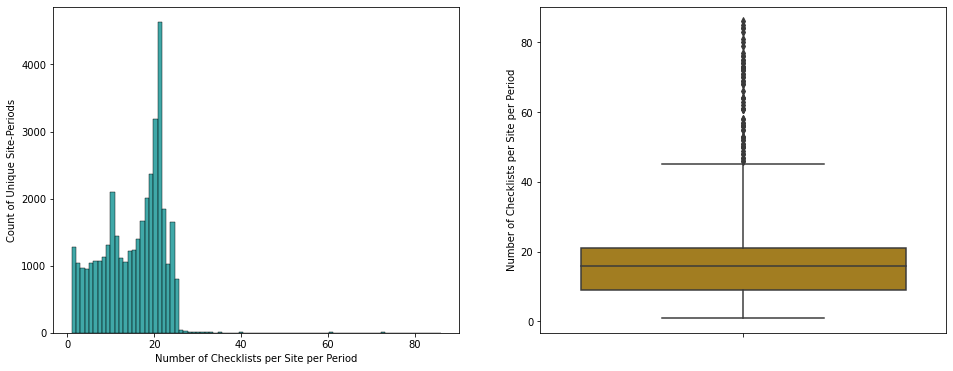

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(df_counts['sub_id'], bins=86, color='darkcyan')
plt.xlabel("Number of Checklists per Site per Period")
plt.ylabel("Count of Unique Site-Periods")

plt.subplot(1, 2, 2)
bxp = sns.boxplot(y = df_counts['sub_id'], whis = 2, color='darkgoldenrod').set(ylabel = "Number of Checklists per Site per Period")

plt.show()

First set a floor for the number of checklists per site, per PFW period.

In [ ]:
min_ckl = 5   # Min number of checklists per site, per PFW period

# Extract the loc_ids that do not meet the min_ckl criteria
rem_locs = df_counts[df_counts['sub_id'] < min_ckl]['loc_id'].unique()

# Subset the dataframe by the loc_ids that do meet the criteria
pfwb = pfwb[~pfwb['loc_id'].isin(rem_locs)]

print('Updated number of sites: {}'.format(pfwb['loc_id'].nunique()))
print('\n')
print('Updated shape of data: {}'.format(pfwb.shape))

Updated number of sites: 7427


Updated shape of data: (6330434, 21)


Now, set a ceiling for the number of checklists per site, per PFW period.  Set the ceiling as the upper fence, cutting off the upper outliers.

In [ ]:
# Regroup by site and period, and get unique counts of other fields
df_counts = pfwb.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()

Q1 = df_counts['sub_id'].quantile(0.25)
Q3 = df_counts['sub_id'].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (2 * IQR)
Upper_Fence = Q3 + (2 * IQR)
print('Upper Fence: {}'.format(Upper_Fence))

Upper Fence: 39.0


For each site that has more checklists per PFW period than the ceiling, reduce the number of checklists to the ceiling through random selection.  For now, perform this subset after excluding checklists with bluebird observations.  Then later, explore the data balance between the presence and absence of bluebird observations.

In [ ]:
max_ckl = int(Upper_Fence)   # Maximum number of checklists per loc_id, per PFW period

bsubid = list(pfwb[pfwb['species_code'] == 'easblu']['sub_id'])   # Exclude checklists with bluebirds

dfb = pfwb[~pfwb['sub_id'].isin(bsubid)]

df_concat = pd.DataFrame(columns = dfb.columns)   # Initialize df

for period in periods:
    df_period = dfb[(dfb['proj_period_id'] == period) & (dfb['species_code'] != 'easblu')][['loc_id', 'sub_id']]
    df = (
        df_period.drop_duplicates(['loc_id', 'sub_id']).
        assign(count=lambda x: x.groupby('loc_id').transform('nunique')).
        loc[lambda x: x.pop('count') >= max_ckl].groupby('loc_id').sample(n = max_ckl, random_state = 744)
        )
    subids = df['sub_id'].unique()
    df = dfb[dfb['sub_id'].isin(subids)] 
    df_concat = pd.concat([df_concat, df], ignore_index=True)

# df_concat contains only the records 
# where the number of checklists per site, per PFW period 
# has been reduced to max_ckl.
# Next, combine with the records 
# where the number of checklists per site, per PFW period 
# is less than max_ckl.

df_counts = dfb.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()
df_sub = df_counts[df_counts['sub_id'] < max_ckl][['loc_id', 'proj_period_id']]   # Get loc_id's with less than max_ckl checklists
df_look = df_sub.merge(dfb, how='left', on=['loc_id', 'proj_period_id'])   # Extract those loc_id records from the df without the bluebirds
df_fin = pd.concat([df_look, df_concat], ignore_index=True)   # Concat those loc_id records with the subset df created by the above code
dfz = pd.concat([pfwb[pfwb['sub_id'].isin(bsubid)], df_fin], ignore_index=True)   # Finally, add back the sub_ids with the bluebirds

In [ ]:
# Take some samples to make sure the above code worked.

df_counts = dfb.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()
locs_high_subs = df_counts[df_counts['sub_id'] >= max_ckl]['loc_id'].reset_index(drop=True)
locs_low_counts = df_counts[df_counts['sub_id'] < max_ckl].groupby(['loc_id']).count().reset_index()
locs_low_subs = locs_low_counts[locs_low_counts['proj_period_id'] >= min_pers]['loc_id'].reset_index(drop=True)

print('A site that originally had more than max_ckl checklists for at least one PFW period:')
print(locs_high_subs[0])
print('\n')
print('A site that originally had less than max_ckl checklists for at least min_pers PFW periods:')
print(locs_low_subs[0])

A site that originally had more than max_ckl checklists for at least one PFW period:
L10330165


A site that originally had less than max_ckl checklists for at least min_pers PFW periods:
L100025


Original -- the site has more than max_ckl checklists for at least one PFW period:

In [ ]:
df_counts[df_counts['loc_id'] == locs_high_subs[0]][['loc_id', 'proj_period_id', 'sub_id']]

loc_id proj_period_id  sub_id
1459  L10330165       PFW_2020       9
1460  L10330165       PFW_2021      72

New -- now, for each PFW period, the site's total number of checklists is less than or equal to max_ckl, as expected:

In [ ]:
high_new = df_fin.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()
high_new[high_new['loc_id'] == locs_high_subs[0]][['loc_id', 'proj_period_id', 'sub_id']]

loc_id proj_period_id  sub_id
1459  L10330165       PFW_2020       9
1460  L10330165       PFW_2021      39

Original -- for at least min_pers PFW periods, the site has less than max_ckl checklists.

In [ ]:
df_counts[df_counts['loc_id'] == locs_low_subs[0]][['loc_id', 'proj_period_id', 'sub_id']]

loc_id proj_period_id  sub_id
0  L100025       PFW_2018      16
1  L100025       PFW_2019      14

New -- for each PFW period, the site's total number of checklists remains less than or equal to max_ckl, as expected:

In [ ]:
low_new = df_fin.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()
low_new[low_new['loc_id'] == locs_low_subs[0]][['loc_id', 'proj_period_id', 'sub_id']]

loc_id proj_period_id  sub_id
0  L100025       PFW_2018      16
1  L100025       PFW_2019      14

In [ ]:
print('Old descriptive statistics of the number of checklists per site, per PFW period:')
print(pfwb.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()['sub_id'].describe())
print('\n')
print('New descriptive statistics of the number of checklists per site, per PFW period:')
print(dfz.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()['sub_id'].describe())


Old descriptive statistics of the number of checklists per site, per PFW period:
count    29900.0000000
mean        16.9633779
std          5.8074875
min          5.0000000
25%         12.0000000
50%         18.0000000
75%         21.0000000
max         86.0000000
Name: sub_id, dtype: float64


New descriptive statistics of the number of checklists per site, per PFW period:
count    29900.0000000
mean        16.9243478
std          5.5449686
min          5.0000000
25%         12.0000000
50%         18.0000000
75%         21.0000000
max         80.0000000
Name: sub_id, dtype: float64


The descriptive statistics changed as expected.

In [ ]:
pfwb = dfz.copy()

In [ ]:
print('Current number of sites in the data: {}'.format(pfwb['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(pfwb['species_code'].nunique()))
print('\n')
print('Current shape of the data: {}'.format(pfwb.shape))

Current number of sites in the data: 7427


Current number of bird species in the data: 241


Current shape of the data: (6318085, 21)


###U.S. Shape File: subset observation sites

Load the shape file of the U.S. and overlay the points of the PFW sites.

In [ ]:
# Shape file of the U.S.
local_path = 'tmp/'
z = zipfile.ZipFile(fdir + ushp)
z.extractall(path=local_path)   # Extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

['cb_2018_us_state_20m.dbf', 'cb_2018_us_state_20m.prj', 'cb_2018_us_state_20m.shp', 'cb_2018_us_state_20m.shx']


In [ ]:
# Use a list comprehension to assign variable names to each of the four files,
# then read the shapefile into a geopandas dataframe.
# From here, check the number of records in the file and preview the data.

dbf, prj, shp, shx = [filename for filename in filenames]
usa = gpd.read_file(local_path + shp)
usa = usa.rename(columns={'STUSPS': 'state'})
print("Shape of the dataframe: {}".format(usa.shape))
print("Projection of dataframe: {}".format(usa.crs))
usa.sample(5)

Shape of the dataframe: (52, 10)
Projection of dataframe: epsg:4269


STATEFP   STATENS     AFFGEOID GEOID state         NAME LSAD         ALAND  \
38      49  01455989  0400000US49    49    UT         Utah   00  212886221680   
48      15  01779782  0400000US15    15    HI       Hawaii   00   16633990195   
34      09  01779780  0400000US09    09    CT  Connecticut   00   12542497068   
23      16  01779783  0400000US16    16    ID        Idaho   00  214049787659   
18      51  01779803  0400000US51    51    VA     Virginia   00  102257717110   

         AWATER                                           geometry  
38   6998824394  POLYGON ((-114.05247 37.60478, -114.05173 37.7...  
48  11777809026  MULTIPOLYGON (((-156.04965 19.78045, -156.0062...  
34   1815617571  POLYGON ((-73.69594 41.11526, -73.48271 41.212...  
23   2391722557  POLYGON ((-117.24303 44.39097, -117.21507 44.4...  
18   8528531774  MULTIPOLYGON (((-76.02347 37.28907, -75.98712 ...

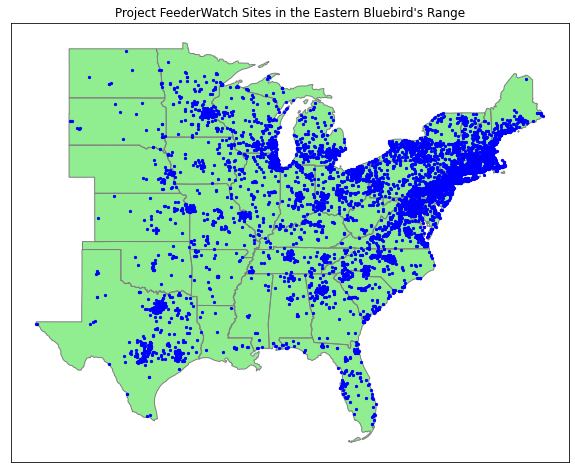

In [ ]:
# Filter the usa shape dataframe to include only the states of the current set of PFW sites
states = pfwb['state'].unique()
usa_sub = usa[usa['state'].isin(states)]

# Create the point geometry of the PFW sites
long_lat = pfwb.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
crs = {'init' : 'epsg:4326'}
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

# Plot the map with the PFW sites
plot_map(geo_df, (10,10), "Project FeederWatch Sites in the Eastern Bluebird's Range")

As shown in the map, the spatial distribution of the PFW sites is very non-uniform.  Next, explore the concentration of the sites by state.

In [ ]:
# Count the number of PFW sites per state
state_counts = pfwb.groupby(['state']).count().reset_index()[['state', 'loc_id']] \
                                .sort_values(by='loc_id', ascending=False)

In [ ]:
# Merge the sites/state counts into the geopandas df
usa_loc_conc = usa_sub.merge(state_counts, how='left', on=['state'])
usa_loc_conc = usa_loc_conc.rename(columns={'loc_id': 'loc_counts'})

# Create a feature, 'locs_per_area', to quanify the concentration of sites within each state
usa_loc_conc['locs_per_area'] = (usa_loc_conc['loc_counts'] / usa_loc_conc['ALAND'])*1000000
usa_loc_conc.sort_values(by='locs_per_area', ascending=False).head(15)

STATEFP   STATENS     AFFGEOID GEOID state                  NAME LSAD  \
27      11  01702382  0400000US11    11    DC  District of Columbia   00   
25      09  01779780  0400000US09    09    CT           Connecticut   00   
22      25  00606926  0400000US25    25    MA         Massachusetts   00   
26      34  01779795  0400000US34    34    NJ            New Jersey   00   
37      44  01219835  0400000US44    44    RI          Rhode Island   00   
2       10  01779781  0400000US10    10    DE              Delaware   00   
0       24  01714934  0400000US24    24    MD              Maryland   00   
16      36  01779796  0400000US36    36    NY              New York   00   
4       42  01779798  0400000US42    42    PA          Pennsylvania   00   
13      51  01779803  0400000US51    51    VA              Virginia   00   
36      33  01779794  0400000US33    33    NH         New Hampshire   00   
3       39  01085497  0400000US39    39    OH                  Ohio   00   
24      50  01779802  0400000US50    50    VT               Vermont   00   
28      37  01027616  0400000US37    37    NC        North Carolina   00   
17      26  01779789  0400000US26    26    MI              Michigan   00   

           ALAND        AWATER  \
27     158340391      18687198   
25   12542497068    1815617571   
22   20205125364    7129925486   
26   19047825980    3544860246   
37    2677779902    1323670487   
2     5045925646    1399985648   
0    25151100280    6979966958   
16  122049149763   19246994695   
4   115884442321    3394589990   
13  102257717110    8528531774   
36   23189413166    1026675248   
3   105828882568   10268850702   
24   23874175944    1030416650   
28  125923656064   13466071395   
17  146600952990  103885855702   

                                             geometry  loc_counts  \
27  POLYGON ((-77.11976 38.93434, -77.04102 38.995...        4995   
25  POLYGON ((-73.69594 41.11526, -73.48271 41.212...      216569   
22  MULTIPOLYGON (((-70.27553 41.31046, -70.19371 ...      331773   
26  POLYGON ((-75.55945 39.62981, -75.53514 39.647...      280687   
37  MULTIPOLYGON (((-71.63147 41.16668, -71.59334 ...       29011   
2   POLYGON ((-75.77379 39.72220, -75.75323 39.757...       53972   
0   MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...      266026   
16  MULTIPOLYGON (((-72.01893 41.27411, -71.92680 ...      770058   
4   POLYGON ((-80.51989 40.90666, -80.51964 40.987...      598574   
13  MULTIPOLYGON (((-76.02347 37.28907, -75.98712 ...      527946   
36  POLYGON ((-72.55611 42.86625, -72.53147 42.897...       89308   
3   MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...      365993   
24  POLYGON ((-73.41632 44.09942, -73.39987 44.152...       60152   
28  POLYGON ((-84.28660 35.20576, -84.28322 35.226...      292876   
17  MULTIPOLYGON (((-84.61622 45.89447, -84.51789 ...      247549   

    locs_per_area  
27     31.5459623  
25     17.2668169  
22     16.4202396  
26     14.7359074  
37     10.8339748  
2      10.6961544  
0      10.5771118  
16      6.3094090  
4       5.1652663  
13      5.1628964  
36      3.8512402  
3       3.4583470  
24      2.5195425  
28      2.3258219  
17      1.6885907

Set a floor for locs_per_area to exclude states with very low concentration of PFW sites.

In [ ]:
min_conc = 2.0   # Floor for locs_per_area

# Subset the states that meet the min_conc criteria
states_sub = list(usa_loc_conc[usa_loc_conc['locs_per_area'] > min_conc].sort_values(by='locs_per_area', ascending=False)['state'])

# Filter the PFW data with the new states list
pfwc = pfwb[pfwb['state'].isin(states_sub)]

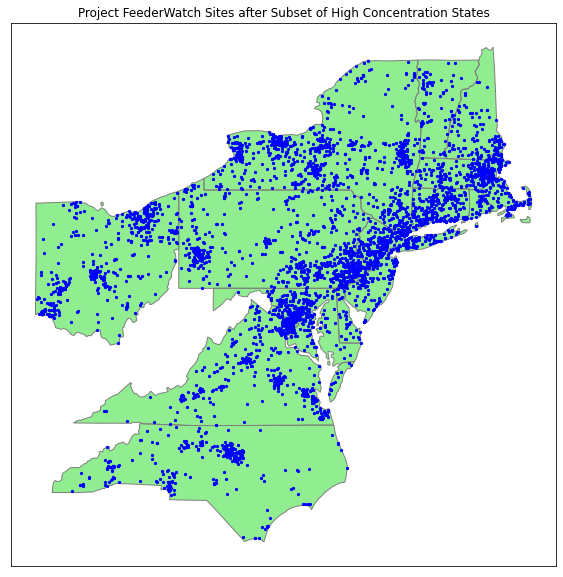

In [ ]:
# Filter the geopandas dataframe again to include 
# only the states with high concentration of locs.
usa_sub = usa[usa['state'].isin(states_sub)]

# Create the point geometry of the PFW sites
long_lat = pfwc.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

# Plot the map with the PFW sites
plot_map(geo_df, (10,10), "Project FeederWatch Sites after Subset of High Concentration States")

In [ ]:
print('Current number of sites in the data: {}'.format(pfwc['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(pfwc['species_code'].nunique()))
print('\n')
print('Current shape of the data: {}'.format(pfwc.shape))

Current number of sites in the data: 4443


Current number of bird species in the data: 148


Current shape of the data: (3887940, 21)


###Pivot the Dataframe

As described previously, the dataframe currently has multiple records per checklist because each observed bird species (species_code) within a checklist is listed as a separate record labeled with a unique identifier (obs_id).  This is illustrated again in the filtered dataframe below for sub_id S28051135.

In [ ]:
pfwc[pfwc.sub_id == 'S28051135'][['loc_id', 'sub_id', 'obs_id', 'proj_period_id', 'species_code', 'how_many']]

loc_id     sub_id        obs_id proj_period_id species_code  \
3627493  L3178670  S28051135  OBS379926875       PFW_2016       coohaw   
3627494  L3178670  S28051135  OBS379926876       PFW_2016       blujay   
3627495  L3178670  S28051135  OBS379926877       PFW_2016       tuftit   
3627496  L3178670  S28051135  OBS379926878       PFW_2016       rebwoo   
3627497  L3178670  S28051135  OBS379926879       PFW_2016       dowwoo   
3627498  L3178670  S28051135  OBS379926880       PFW_2016       houspa   
3627499  L3178670  S28051135  OBS379926881       PFW_2016       whbnut   
3627500  L3178670  S28051135  OBS379926882       PFW_2016       daejun   
3627501  L3178670  S28051135  OBS379926883       PFW_2016       eursta   
3627502  L3178670  S28051135  OBS379926884       PFW_2016       moudov   
3627503  L3178670  S28051135  OBS379926885       PFW_2016       amegfi   
3627504  L3178670  S28051135  OBS379926886       PFW_2016       houfin   
3627505  L3178670  S28051135  OBS379926887       PFW_2016       norcar   
3627506  L3178670  S28051135  OBS379926888       PFW_2016       amecro   

        how_many  
3627493        1  
3627494        2  
3627495        3  
3627496        1  
3627497        4  
3627498       10  
3627499        2  
3627500       13  
3627501        7  
3627502        9  
3627503       12  
3627504        2  
3627505        2  
3627506        3

In [ ]:
# Save this sub_id's bird observations to perform a check after the pivot
example = pfwc[pfwc.sub_id == 'S28051135'][['loc_id', 'obs_id', 'proj_period_id', 'species_code', 'how_many']]['species_code'].unique().tolist()
example

['coohaw',
 'blujay',
 'tuftit',
 'rebwoo',
 'dowwoo',
 'houspa',
 'whbnut',
 'daejun',
 'eursta',
 'moudov',
 'amegfi',
 'houfin',
 'norcar',
 'amecro']

In this study, the bird species will be features; therefore, each bird species needs its own column.  

In the next steps, the bird species will be pivoted into columns and filled with the 'how_many' values.

In [ ]:
# Create a list of all columns that will not be pivoted
no_pivot = [x for x in pfwc.columns if x not in ['species_code', 'how_many']]
no_pivot

['loc_id',
 'latitude',
 'longitude',
 'sub_id',
 'obs_id',
 'month',
 'day',
 'year',
 'proj_period_id',
 'valid',
 'reviewed',
 'day1_am',
 'day1_pm',
 'day2_am',
 'day2_pm',
 'effort_hrs_atleast',
 'snow_dep_atleast',
 'data_entry_method',
 'state']

In [ ]:
# Pivot the dataframe
pivo = pfwc.pivot(index=no_pivot, columns='species_code', values='how_many').reset_index()

# Zero fill the NaNs in the bird species columns resulting from the pivot
pivo = pivo.fillna(0)

# The columns, 'obs_id' and 'data_entry_method' will be removed before proceeeding,
# because they will not be used in the study.
pivo = pivo.drop(columns=['obs_id', 'data_entry_method'])

# The column list name (above the index) will end up as 'species_code'.  Remove that label.
pivo.columns.name=''

The following filtered dataframe for sub_id S28051135 shows the new format where each bird species is a column filled with its count.

In [ ]:
pivo[pivo.sub_id == 'S28051135'][['loc_id', 'sub_id', 'proj_period_id'] + example]

loc_id     sub_id proj_period_id  coohaw  blujay  tuftit  rebwoo  \
1847290  L3178670  S28051135       PFW_2016       1       0       0       0   
1847291  L3178670  S28051135       PFW_2016       0       2       0       0   
1847292  L3178670  S28051135       PFW_2016       0       0       3       0   
1847293  L3178670  S28051135       PFW_2016       0       0       0       1   
1847294  L3178670  S28051135       PFW_2016       0       0       0       0   
1847295  L3178670  S28051135       PFW_2016       0       0       0       0   
1847296  L3178670  S28051135       PFW_2016       0       0       0       0   
1847297  L3178670  S28051135       PFW_2016       0       0       0       0   
1847298  L3178670  S28051135       PFW_2016       0       0       0       0   
1847299  L3178670  S28051135       PFW_2016       0       0       0       0   
1847300  L3178670  S28051135       PFW_2016       0       0       0       0   
1847301  L3178670  S28051135       PFW_2016       0       0       0       0   
1847302  L3178670  S28051135       PFW_2016       0       0       0       0   
1847303  L3178670  S28051135       PFW_2016       0       0       0       0   

         dowwoo  houspa  whbnut  daejun  eursta  moudov  amegfi  houfin  \
1847290       0       0       0       0       0       0       0       0   
1847291       0       0       0       0       0       0       0       0   
1847292       0       0       0       0       0       0       0       0   
1847293       0       0       0       0       0       0       0       0   
1847294       4       0       0       0       0       0       0       0   
1847295       0      10       0       0       0       0       0       0   
1847296       0       0       2       0       0       0       0       0   
1847297       0       0       0      13       0       0       0       0   
1847298       0       0       0       0       7       0       0       0   
1847299       0       0       0       0       0       9       0       0   
1847300       0       0       0       0       0       0      12       0   
1847301       0       0       0       0       0       0       0       2   
1847302       0       0       0       0       0       0       0       0   
1847303       0       0       0       0       0       0       0       0   

         norcar  amecro  
1847290       0       0  
1847291       0       0  
1847292       0       0  
1847293       0       0  
1847294       0       0  
1847295       0       0  
1847296       0       0  
1847297       0       0  
1847298       0       0  
1847299       0       0  
1847300       0       0  
1847301       0       0  
1847302       2       0  
1847303       0       3

In [ ]:
# List of bird species columns
spcs_list = [x for x in pivo.columns if x not in no_pivot]

# List of non-bird_species columns
other_col = list(pivo.loc[:, ~pivo.columns.isin(spcs_list)].columns)

print('Number of columns in the dataframe: {}'.format(len(pivo.columns)))
print('\n')
print('Which is composed of...')
print('\n')
print('Current number of bird species in the dataframe: {}'.format(len(spcs_list)))
print('\n')
print('and')
print('\n')
print('Number of other columns in the dataframe: {}'.format(len(other_col)))

Number of columns in the dataframe: 165


Which is composed of...


Current number of bird species in the dataframe: 148


and


Number of other columns in the dataframe: 17


As shown in the filtered dataframe above, each unique sub_id is still spread over multiple rows because each row corresponds to only one non-zero count of a bird species.

The next step is to compress the dataframe such that a unique sub_id occupies only one row, which can have non-zero counts of more than one bird species. 

In [ ]:
# Group the dataframe by all columns except for the bird species, and sum.
# The result is that each sub_id occupies only one row,
# and each non-zero bird species count within a sub_id is brought to its sub_id's row.

pivo = pivo.groupby(other_col).sum().reset_index()

The final pivoted and compressed format as seen in sub_id S28051135:

In [ ]:
pivo[pivo.sub_id == 'S28051135'][['loc_id', 'sub_id', 'proj_period_id'] + example]

loc_id     sub_id proj_period_id  coohaw  blujay  tuftit  rebwoo  \
142209  L3178670  S28051135       PFW_2016       1       2       3       1   

        dowwoo  houspa  whbnut  daejun  eursta  moudov  amegfi  houfin  \
142209       4      10       2      13       7       9      12       2   

        norcar  amecro  
142209       2       3

In [ ]:
# List of bird species columns
spcs_list = [x for x in pivo.columns if x not in no_pivot]

In [ ]:
print('Current number of sites in the data: {}'.format(pivo['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pivo.shape))

Current number of sites in the data: 4443


Current number of bird species in the data: 148


Current shape of the data: (304512, 165)


###PFW Site Data: merge

Read in the PFW site description data, which will be merged with the PFW observation data.

In [ ]:
# pfwcount_site_data_public_2021.csv
sites = pd.read_csv(fdir + bsite)

In [ ]:
sites.sample(4)

loc_id proj_period_id  yard_type_pavement  yard_type_garden  \
190399   L460266       PFW_2015                 NaN               NaN   
68610     L20933       PFW_1996                 0.0               0.0   
138113  L3323140       PFW_2021                 0.0               0.0   
167044   L384694       PFW_2016                 0.0               0.0   

        yard_type_landsca  yard_type_woods  yard_type_desert  hab_dcid_woods  \
190399                1.0              NaN               NaN             NaN   
68610                 1.0              0.0               0.0             1.0   
138113                1.0              1.0               0.0             1.0   
167044                1.0              1.0               0.0             1.0   

        hab_evgr_woods  hab_mixed_woods  ...  numfeeders_platfrm  \
190399             NaN              1.0  ...                 NaN   
68610              0.0              1.0  ...                 0.0   
138113             0.0              1.0  ...                 5.0   
167044             1.0              1.0  ...                 0.0   

        numfeeders_humming  numfeeders_water  numfeeders_thistle  \
190399                 NaN               NaN                 NaN   
68610                  0.0               0.0                 1.0   
138113                 0.0               NaN                 NaN   
167044                 0.0               NaN                 NaN   

        numfeeders_fruit  numfeeders_hopper  numfeeders_tube  \
190399               NaN                1.0              4.0   
68610                0.0                NaN              NaN   
138113               0.0                1.0              4.0   
167044               1.0                0.0              3.0   

        numfeeders_other  population_atleast  count_area_size_sq_m_atleast  
190399               1.0            100001.0                        100.01  
68610                NaN            100001.0                        100.01  
138113               0.0                 1.0                        375.01  
167044               0.0                 1.0                          1.01  

[4 rows x 62 columns]

In [ ]:
sites.shape

(254355, 62)

In [ ]:
# Remove the following columns,
# as they are redundant with the population and rural-urban data to be later aggregated.
srem = ['housing_density', 'population_atleast']
sites = sites.drop(columns = srem)

# Subset the site data by the loc_ids from the prepared observation dataset.
locs = list(pivo['loc_id'].unique())
sites_b = sites[sites['loc_id'].isin(locs)]

# Then merge the PFW site description data with the PFW observation data
# on the loc_id and proj_period_id
pfwc = pivo.merge(sites_b, how = 'left', on = ['loc_id', 'proj_period_id'])

# Make sure sub_id is the first column for ease of viewing the df
pfwc.insert(0, 'sub_id', pfwc.pop('sub_id'))

In [ ]:
pfwc.sample(4)

sub_id    loc_id    latitude   longitude  month  day  year  \
89011   S40890947   L230210  40.8935807 -74.0216303     12    2  2017   
290024  S62914970  L8216287  40.3198435 -74.0897442     12   14  2019   
137365  S53698045  L3161620  42.9697069 -76.5176296      3    9  2019   
238192  S46195646  L6439884  37.5249711 -77.4444938      1   13  2018   

       proj_period_id  valid  reviewed  ...  numfeeders_hanging  \
89011        PFW_2018      1         0  ...                 NaN   
290024       PFW_2020      1         0  ...                 NaN   
137365       PFW_2019      1         0  ...                 NaN   
238192       PFW_2018      1         0  ...                 NaN   

        numfeeders_platfrm  numfeeders_humming  numfeeders_water  \
89011                  0.0                 0.0               NaN   
290024                 1.0                 0.0               NaN   
137365                 NaN                 NaN               NaN   
238192                 0.0                 0.0               NaN   

        numfeeders_thistle  numfeeders_fruit numfeeders_hopper  \
89011                  NaN               0.0               1.0   
290024                 NaN               1.0               0.0   
137365                 NaN               NaN               4.0   
238192                 NaN               0.0               0.0   

        numfeeders_tube  numfeeders_other  count_area_size_sq_m_atleast  
89011               3.0               0.0                        100.01  
290024              3.0               0.0                        100.01  
137365              NaN               0.0                          1.01  
238192              1.0               0.0                          1.01  

[4 rows x 223 columns]

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist()).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in pfwc.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(pfwc['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pfwc.shape))

Current number of sites in the data: 4443


Current number of bird species in the data: 148


Current shape of the data: (304512, 223)


###PFW Site Data: explore, prep

All site data is unique to the loc_id; therefore, a loc_id's site data will be repeated across a loc_id's checklists.

First, check for NaNs in the site data.

In [ ]:
null_summary(pfwc)[:6]

null_names  null_counts  null_proportion null_dtypes
0  yard_type_pavement        54621        0.1793722     float64
1    yard_type_garden        54611        0.1793394     float64
2   yard_type_landsca        54254        0.1781670     float64
3     yard_type_woods        54556        0.1791588     float64
4    yard_type_desert        54621        0.1793722     float64
5      hab_dcid_woods        54097        0.1776515     float64

Have a look at the descriptive statistics of the yard types.

In [ ]:
yard_col = pfwc.filter(regex='yard').columns
pfwc[yard_col].describe()

yard_type_pavement  yard_type_garden  yard_type_landsca  \
count      249891.0000000    249901.0000000     250258.0000000   
mean            0.0010204         0.0252780          0.9052018   
std             0.0319282         0.1569686          0.2929365   
min             0.0000000         0.0000000          0.0000000   
25%             0.0000000         0.0000000          1.0000000   
50%             0.0000000         0.0000000          1.0000000   
75%             0.0000000         0.0000000          1.0000000   
max             1.0000000         1.0000000          1.0000000   

       yard_type_woods  yard_type_desert  
count   249956.0000000    249891.0000000  
mean         0.7094369         0.0002521  
std          0.4540232         0.0158760  
min          0.0000000         0.0000000  
25%          0.0000000         0.0000000  
50%          1.0000000         0.0000000  
75%          1.0000000         0.0000000  
max          1.0000000         1.0000000

The function, unique_summary, has been defined at the beginning of the notebook.  Given a dataframe and a list of columns within that dataframe, the function will return a dataframe summarizing the unique values of the columns.

Get the unique values of the yard types.

In [ ]:
unique_summary(pfwc, yard_col)

yard_type_pavement  yard_type_garden  yard_type_landsca  yard_type_woods  \
0                 0.0               0.0                1.0              1.0   
1                 NaN               NaN                NaN              0.0   
2                 1.0               1.0                0.0              NaN   

   yard_type_desert  
0               0.0  
1               NaN  
2               1.0

In [ ]:
# Count the unique (i.e., by loc_id) instances of each yard type in the data.
# Since site data is unique to the loc_id (i.e., a loc_id's site data will be repeated across a loc_id's checklists),
# the .agg('first') will just take the first row in the loc_id group, which is the same as all other rows in its group.

pfwc[['loc_id'] + list(yard_col)].groupby('loc_id').agg('first')[yard_col].sum()

yard_type_pavement      13.0
yard_type_garden       139.0
yard_type_landsca     3817.0
yard_type_woods       2901.0
yard_type_desert         1.0
dtype: float64

The yard variables are all binary (0 = absent, 1 = present).  Zero fill the NaNs.  Then remove the column, yard_type_desert, as it has entries for a negligible number of sites.

In [ ]:
pfwc[yard_col] = pfwc[yard_col].fillna(0)
pfwc = pfwc.drop(columns = 'yard_type_desert')

null_summary(pfwc)[:6]

null_names  null_counts  null_proportion null_dtypes
0   hab_dcid_woods        54097        0.1776515     float64
1   hab_evgr_woods        54466        0.1788632     float64
2  hab_mixed_woods        53810        0.1767090     float64
3      hab_orchard        54542        0.1791128     float64
4         hab_park       119476        0.3923524     float64
5  hab_water_fresh        53863        0.1768830     float64

Move on to the habitat types.

In [ ]:
hab_col = pfwc.filter(regex='hab_').columns
pfwc[hab_col].describe()

hab_dcid_woods  hab_evgr_woods  hab_mixed_woods     hab_orchard  \
count  250415.0000000  250046.0000000   250702.0000000  249970.0000000   
mean        0.5473394       0.1559353        0.7285582       0.0825499   
std         0.4977549       0.3627947        0.4447043       0.2752012   
min         0.0000000       0.0000000        0.0000000       0.0000000   
25%         0.0000000       0.0000000        0.0000000       0.0000000   
50%         1.0000000       0.0000000        1.0000000       0.0000000   
75%         1.0000000       0.0000000        1.0000000       0.0000000   
max         1.0000000       1.0000000        1.0000000       1.0000000   

             hab_park  hab_water_fresh  hab_water_salt  hab_residential  \
count  185036.0000000   250649.0000000  249973.0000000   250889.0000000   
mean        0.2861119        0.6175927       0.0416685        0.9337117   
std         0.4519436        0.4859762       0.1998309        0.2487858   
min         0.0000000        0.0000000       0.0000000        0.0000000   
25%         0.0000000        0.0000000       0.0000000        1.0000000   
50%         0.0000000        1.0000000       0.0000000        1.0000000   
75%         1.0000000        1.0000000       0.0000000        1.0000000   
max         1.0000000        1.0000000       1.0000000        1.0000000   

       hab_industrial  hab_agricultural  hab_desert_scrub  hab_young_woods  \
count  250119.0000000    250376.0000000    249912.0000000   250357.0000000   
mean        0.2060299         0.3759506         0.0011604        0.3535831   
std         0.4044530         0.4843683         0.0340451        0.4780826   
min         0.0000000         0.0000000         0.0000000        0.0000000   
25%         0.0000000         0.0000000         0.0000000        0.0000000   
50%         0.0000000         0.0000000         0.0000000        0.0000000   
75%         0.0000000         1.0000000         0.0000000        1.0000000   
max         1.0000000         1.0000000         1.0000000        1.0000000   

            hab_swamp       hab_marsh  
count  203978.0000000  250004.0000000  
mean        0.3388012       0.1781092  
std         0.4733033       0.3826054  
min         0.0000000       0.0000000  
25%         0.0000000       0.0000000  
50%         0.0000000       0.0000000  
75%         1.0000000       0.0000000  
max         1.0000000       1.0000000

In [ ]:
unique_summary(pfwc, hab_col)

hab_dcid_woods  hab_evgr_woods  hab_mixed_woods  hab_orchard  hab_park  \
0             1.0             1.0              1.0          0.0       1.0   
1             0.0             0.0              0.0          NaN       NaN   
2             NaN             NaN              NaN          1.0       0.0   

   hab_water_fresh  hab_water_salt  hab_residential  hab_industrial  \
0              1.0             0.0              1.0             1.0   
1              0.0             NaN              NaN             0.0   
2              NaN             1.0              0.0             NaN   

   hab_agricultural  hab_desert_scrub  hab_young_woods  hab_swamp  hab_marsh  
0               1.0               0.0              1.0        1.0        0.0  
1               0.0               NaN              0.0        NaN        1.0  
2               NaN               1.0              NaN        0.0        NaN

In [ ]:
pfwc[['loc_id'] + list(hab_col)].groupby('loc_id').agg('first')[hab_col].sum()

hab_dcid_woods      2153.0
hab_evgr_woods       625.0
hab_mixed_woods     3045.0
hab_orchard          349.0
hab_park            1024.0
hab_water_fresh     2569.0
hab_water_salt       177.0
hab_residential     3984.0
hab_industrial       807.0
hab_agricultural    1490.0
hab_desert_scrub      10.0
hab_young_woods     1357.0
hab_swamp           1251.0
hab_marsh            718.0
dtype: float64

The habitat variables are all binary (0 = absent, 1 = present).  Zero fill the NaNs. Then remove the column, hab_desert_scrub, as it has entries for a negligible number of sites.

In [ ]:
pfwc[hab_col] = pfwc[hab_col].fillna(0)
pfwc = pfwc.drop(columns = 'hab_desert_scrub')

null_summary(pfwc)[:6]

null_names  null_counts  null_proportion null_dtypes
0  evgr_trees_atleast        54907        0.1803114     float64
1  evgr_shrbs_atleast        55487        0.1822161     float64
2  dcid_trees_atleast        54676        0.1795529     float64
3  dcid_shrbs_atleast        55495        0.1822424     float64
4   fru_trees_atleast        55881        0.1835100     float64
5       cacti_atleast        57222        0.1879138     float64

Move on to the types of nearby trees.

In [ ]:
tree_col = pfwc.filter(regex='trees|shrbs|cacti').columns
pfwc[tree_col].describe()

evgr_trees_atleast  evgr_shrbs_atleast  dcid_trees_atleast  \
count      249605.0000000       249025.000000      249836.0000000   
mean            3.9312474            3.431278           6.6349485   
std             3.7553705            3.586955           4.0965645   
min             0.0000000            0.000000           0.0000000   
25%             1.0000000            1.000000           4.0000000   
50%             4.0000000            4.000000           4.0000000   
75%             4.0000000            4.000000          11.0000000   
max            11.0000000           11.000000          11.0000000   

       dcid_shrbs_atleast  fru_trees_atleast   cacti_atleast  
count      249017.0000000     248631.0000000  247290.0000000  
mean            5.5846107          2.3443255       0.0430588  
std             4.1500607          2.9068986       0.4080535  
min             0.0000000          0.0000000       0.0000000  
25%             1.0000000          1.0000000       0.0000000  
50%             4.0000000          1.0000000       0.0000000  
75%            11.0000000          4.0000000       0.0000000  
max            11.0000000         11.0000000      11.0000000

In [ ]:
unique_summary(pfwc, tree_col)

evgr_trees_atleast  evgr_shrbs_atleast  dcid_trees_atleast  \
0                 1.0                 4.0                 1.0   
1                 4.0                 1.0                 4.0   
2                11.0                 0.0                11.0   
3                 NaN                11.0                 NaN   
4                 0.0                 NaN                 0.0   

   dcid_shrbs_atleast  fru_trees_atleast  cacti_atleast  
0                 1.0                1.0            0.0  
1                 4.0                0.0            NaN  
2                11.0               11.0            1.0  
3                 NaN                4.0           11.0  
4                 0.0                NaN            4.0

These fields are ordinal categorical variables and represent the minimum number of trees or shrubs of various types around the site (categories: 0, 1-3, 4-10, >10).  Fill the NaNs with the mode.

In [ ]:
for col in tree_col:
    pfwc[col] = pfwc[col].fillna(pfwc[col].mode()[0])

null_summary(pfwc)[:6]

null_names  null_counts  null_proportion null_dtypes
0  brsh_piles_atleast        55616        0.1826398     float64
1  water_srcs_atleast        56191        0.1845280     float64
2  bird_baths_atleast        55093        0.1809223     float64
3      nearby_feeders        55301        0.1816053     float64
4           squirrels        54273        0.1782294     float64
5                cats        55222        0.1813459     float64

Move on to brush piles, water sources, and bird baths.

In [ ]:
brsh_col = pfwc.filter(regex='brsh_|water_sr|bird_bath').columns
pfwc[brsh_col].describe()

brsh_piles_atleast  water_srcs_atleast  bird_baths_atleast
count      248896.0000000      248321.0000000      249419.0000000
mean            1.1703563           0.3319333           0.8523007
std             1.5856228           0.6167825           0.7324757
min             0.0000000           0.0000000           0.0000000
25%             0.0000000           0.0000000           1.0000000
50%             1.0000000           0.0000000           1.0000000
75%             1.0000000           1.0000000           1.0000000
max            11.0000000          11.0000000          11.0000000

In [ ]:
unique_summary(pfwc, brsh_col)

brsh_piles_atleast  water_srcs_atleast  bird_baths_atleast
0                 1.0                 0.0                 1.0
1                 0.0                 NaN                 0.0
2                 NaN                 1.0                 NaN
3                 4.0                11.0                 4.0
4                11.0                 4.0                11.0

These fields are ordinal categorical and represent the minimum number of brush piles, water sources, and bird baths around the site (categories: 0, 1-3, 4-10, >10).  Fill the NaNs with the mode.

In [ ]:
for col in brsh_col:
    pfwc[col] = pfwc[col].fillna(pfwc[col].mode()[0])

null_summary(pfwc)[:6]

null_names  null_counts  null_proportion null_dtypes
0  nearby_feeders        55301        0.1816053     float64
1       squirrels        54273        0.1782294     float64
2            cats        55222        0.1813459     float64
3            dogs        55528        0.1823508     float64
4          humans        54770        0.1798615     float64
5    fed_yr_round       139709        0.4587964     float64

Move on to nearby feeders, squirrels, cats, dogs, and humans.

In [ ]:
nearby_col = pfwc.filter(regex='nearby_f|squir|cats|dogs|humans').columns
pfwc[nearby_col].describe()

nearby_feeders       squirrels            cats            dogs  \
count  249211.0000000  250239.0000000  249290.0000000  248984.0000000   
mean        0.4334640       0.9127194       0.4627021       0.4356384   
std         0.4955542       0.2822463       0.4986079       0.4958413   
min         0.0000000       0.0000000       0.0000000       0.0000000   
25%         0.0000000       1.0000000       0.0000000       0.0000000   
50%         0.0000000       1.0000000       0.0000000       0.0000000   
75%         1.0000000       1.0000000       1.0000000       1.0000000   
max         1.0000000       1.0000000       1.0000000       1.0000000   

               humans  
count  249742.0000000  
mean        0.8055673  
std         0.3957641  
min         0.0000000  
25%         1.0000000  
50%         1.0000000  
75%         1.0000000  
max         1.0000000

In [ ]:
unique_summary(pfwc, nearby_col)

nearby_feeders  squirrels  cats  dogs  humans
0             1.0        1.0   1.0   1.0     1.0
1             0.0        0.0   0.0   0.0     0.0
2             NaN        NaN   NaN   NaN     NaN

These fields represent:  
*  Present or absence of feeders (others than those maintained by the participant) within 90 m of the count site (0 = feeders absent, 1 = feeders present).
*  Do squirrels take food from feeders at least 3 times per week? Are cats, dogs, or humans active within 30 m of the feeders for at least 30 minutes 3 days per week (0 = no, 1 = yes)?

Zero fill the NaNs.

In [ ]:
pfwc[nearby_col] = pfwc[nearby_col].fillna(0)

null_summary(pfwc)[:6]

null_names  null_counts  null_proportion null_dtypes
0  fed_yr_round       139709        0.4587964     float64
1    fed_in_jan        55693        0.1828926     float64
2    fed_in_feb        55788        0.1832046     float64
3    fed_in_mar        55967        0.1837924     float64
4    fed_in_apr        57217        0.1878974     float64
5    fed_in_may        61056        0.2005044     float64

According to Cornell, the fed_yr_round field has not been consistently applied throughout the history of the project.  Remove the column for fed_yr_round.  Instead, the monthly fields will be used.  The monthly fields are binary (0 = no, 1 = yes) and represent the consistency of feeding -- the following question is asked for each month, "I provided food in my count site at least once per week."  Zero fill the NaNs of the monthly fields.

In [ ]:
pfwc = pfwc.drop(columns = 'fed_yr_round')

fed_col = pfwc.filter(regex='fed_in_').columns
pfwc[fed_col].describe()

fed_in_jan      fed_in_feb      fed_in_mar      fed_in_apr  \
count  248819.0000000  248724.0000000  248545.0000000  247295.0000000   
mean        0.9886142       0.9865192       0.9863244       0.9593724   
std         0.1060952       0.1153218       0.1161405       0.1974263   
min         0.0000000       0.0000000       0.0000000       0.0000000   
25%         1.0000000       1.0000000       1.0000000       1.0000000   
50%         1.0000000       1.0000000       1.0000000       1.0000000   
75%         1.0000000       1.0000000       1.0000000       1.0000000   
max         1.0000000       1.0000000       1.0000000       1.0000000   

           fed_in_may      fed_in_jun      fed_in_jul      fed_in_aug  \
count  243456.0000000  241712.0000000  241174.0000000  241327.0000000   
mean        0.8672039       0.8138073       0.7890983       0.7889793   
std         0.3393549       0.3892629       0.4079496       0.4080339   
min         0.0000000       0.0000000       0.0000000       0.0000000   
25%         1.0000000       1.0000000       1.0000000       1.0000000   
50%         1.0000000       1.0000000       1.0000000       1.0000000   
75%         1.0000000       1.0000000       1.0000000       1.0000000   
max         1.0000000       1.0000000       1.0000000       1.0000000   

           fed_in_sep      fed_in_oct      fed_in_nov      fed_in_dec  
count  242842.0000000  245621.0000000  249405.0000000  249106.0000000  
mean        0.8262862       0.8992513       0.9871534       0.9874391  
std         0.3788639       0.3009963       0.1126126       0.1113696  
min         0.0000000       0.0000000       0.0000000       0.0000000  
25%         1.0000000       1.0000000       1.0000000       1.0000000  
50%         1.0000000       1.0000000       1.0000000       1.0000000  
75%         1.0000000       1.0000000       1.0000000       1.0000000  
max         1.0000000       1.0000000       1.0000000       1.0000000

In [ ]:
unique_summary(pfwc, fed_col)

fed_in_jan  fed_in_feb  fed_in_mar  fed_in_apr  fed_in_may  fed_in_jun  \
0         1.0         1.0         1.0         NaN         NaN         NaN   
1         NaN         NaN         NaN         1.0         1.0         1.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   

   fed_in_jul  fed_in_aug  fed_in_sep  fed_in_oct  fed_in_nov  fed_in_dec  
0         NaN         NaN         NaN         NaN         1.0         1.0  
1         1.0         1.0         1.0         1.0         NaN         NaN  
2         0.0         0.0         0.0         0.0         0.0         0.0

In [ ]:
pfwc[fed_col] = pfwc[fed_col].fillna(0)

null_summary(pfwc)[:12]

null_names  null_counts  null_proportion null_dtypes
0                numfeeders_suet        55579        0.1825183     float64
1              numfeeders_ground        60647        0.1991613     float64
2             numfeeders_hanging       304512        1.0000000     float64
3             numfeeders_platfrm        62891        0.2065304     float64
4             numfeeders_humming        66268        0.2176203     float64
5               numfeeders_water       304512        1.0000000     float64
6             numfeeders_thistle       304512        1.0000000     float64
7               numfeeders_fruit        67440        0.2214691     float64
8              numfeeders_hopper        58393        0.1917593     float64
9                numfeeders_tube        56507        0.1855658     float64
10              numfeeders_other        66775        0.2192853     float64
11  count_area_size_sq_m_atleast        54433        0.1787549     float64

The fields, numfeeders_hanging, numfeeders_water, and numfeeders_thistle, are 100% null.  Remove them.

In [ ]:
pfwc = pfwc.drop(columns = ['numfeeders_hanging', 'numfeeders_water', 'numfeeders_thistle'])

nfeed_col = pfwc.filter(regex='numfeeders_').columns
pfwc[nfeed_col].describe()

numfeeders_suet  numfeeders_ground  numfeeders_platfrm  \
count   248933.0000000     243865.0000000      241621.0000000   
mean         1.7285736          1.0943555           0.6852343   
std          1.2313682          1.1068110           0.9741863   
min          0.0000000          0.0000000           0.0000000   
25%          1.0000000          0.0000000           0.0000000   
50%          1.0000000          1.0000000           0.0000000   
75%          2.0000000          2.0000000           1.0000000   
max         34.0000000         12.0000000          19.0000000   

       numfeeders_humming  numfeeders_fruit  numfeeders_hopper  \
count      238244.0000000    237072.0000000     246119.0000000   
mean            0.3533142         0.0952495          1.1995539   
std             0.8718811         0.3356722          1.3791960   
min             0.0000000         0.0000000          0.0000000   
25%             0.0000000         0.0000000          0.0000000   
50%             0.0000000         0.0000000          1.0000000   
75%             0.0000000         0.0000000          2.0000000   
max            20.0000000         4.0000000         21.0000000   

       numfeeders_tube  numfeeders_other  
count   248005.0000000    237737.0000000  
mean         2.1826415         0.4662884  
std          2.0797795         0.9136096  
min          0.0000000         0.0000000  
25%          1.0000000         0.0000000  
50%          2.0000000         0.0000000  
75%          3.0000000         1.0000000  
max        104.0000000        13.0000000

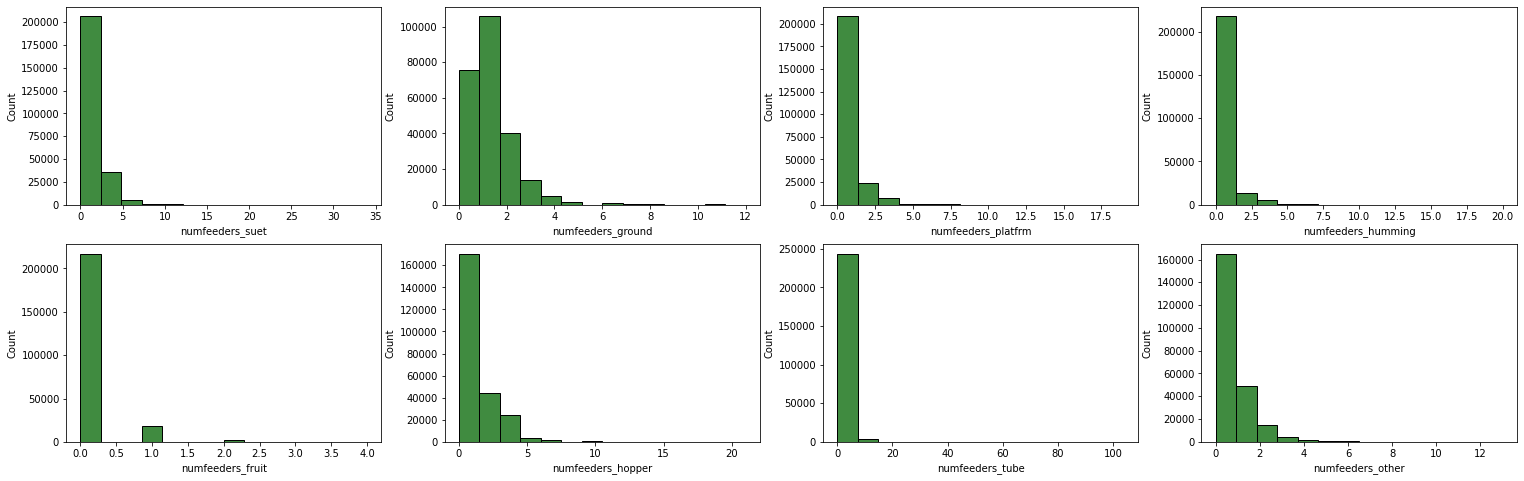

In [ ]:
plt.figure(figsize=(26,8))
plt.tight_layout

for idx, col in enumerate(nfeed_col):
  plt.subplot(2, 4, idx+1)
  sns.histplot(data=pfwc, bins=14, x=col, color='darkgreen')

plt.show()

These other feeder counts are continuous variables.  In this case, it's reasonable to think that a NaN indicates the absence of the feeder type.  Zero fill the NaNs.

In [ ]:
pfwc[nfeed_col] = pfwc[nfeed_col].fillna(0)

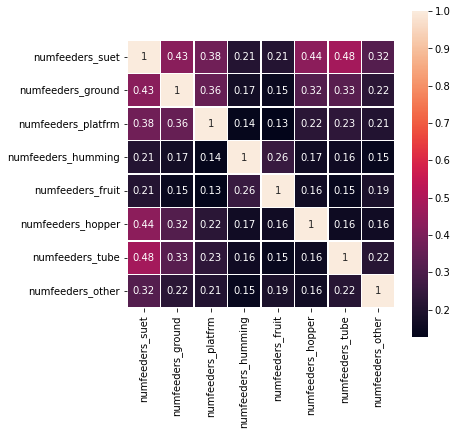

In [ ]:
plt.figure(figsize=(6, 6))

sns.heatmap(pfwc[nfeed_col].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

The heat map shows some moderate correlations between feeder types.

In [ ]:
null_summary(pfwc)

null_names  null_counts  null_proportion null_dtypes
0  count_area_size_sq_m_atleast        54433        0.1787549     float64

In [ ]:
area_col = 'count_area_size_sq_m_atleast'
pfwc[area_col].describe()

count    250079.0000000
mean        136.5732020
std         136.8239777
min           0.0100000
25%           1.0100000
50%         100.0100000
75%         100.0100000
max         375.0100000
Name: count_area_size_sq_m_atleast, dtype: float64

In [ ]:
pfwc[area_col].unique().tolist()

[100.01, 375.01, 1.01, nan, 0.01]

The area field is the estimated area of the survey site.  It is also an ordinal categorical variable.
*  0.01:  < 1 square meter
*  1.01:  1 to 100 square meters
*  100.01:  100 - 375 square meters
*  375.01:  > 375 square meters

Fill the area NaNs with the mode. 

In [ ]:
pfwc[area_col] = pfwc[area_col].fillna(pfwc[area_col].mode()[0])

null_summary(pfwc)

Empty DataFrame
Columns: [null_names, null_counts, null_proportion, null_dtypes]
Index: []

No more NaNs remain.

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist()).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in pfwc.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(pfwc['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pfwc.shape))

Current number of sites in the data: 4443


Current number of bird species in the data: 148


Current shape of the data: (304512, 217)


###Aggregation with Population, Rural-Urban, and Weather Data

In [ ]:
# Write the latitudes and longitudes of the sites to a csv 
# for mapping to population, rural-urban, and weather data
locs = pfwc.groupby(['latitude', 'longitude']).count().reset_index()[['latitude', 'longitude']]

locs.to_csv(fdir + "weather_data/" + 'locs.csv')

In [ ]:
# Write the prepped data to a csv
pfwc.to_csv(fdir + "weather_data/" + 'pfwc.csv')

The PFW data has been aggregated with population, rural-urban, and weather data in another notebook.  Read in that aggregated dataset here.

In [ ]:
bird = pd.read_csv(fdir + "aggregated_data.csv")
bird = bird.drop(columns = 'Unnamed: 0')

bird.iloc[:3, -9:].head()

count_area_size_sq_m_atleast  ruc_2013  uic_2013   pop_est  land_area  \
0                        375.01         2         2  278452.0    2069.80   
1                        375.01         1         1  515098.0    1943.81   
2                          1.01         1         1  294105.0    2060.67   

   water_area  tmin  tmax  pcpn  
0     1966.00  33.0  43.0  0.33  
1       22.60  40.0  56.0  0.00  
2       76.97  36.0  52.0  0.01

As shown above, the newly aggregated features include:
*  From the USDA, Rural-Urban Continuum Codes (ruc_2013) and Urban-Influence Codes (uic_2013) at the county level.
*  2015-2021 population estimates by county (pop_est) from the U.S. Census.
*  Land and water area by county (land_area, water_area), from the U.S. Census.
*  Daily minimum and maximumum temperatures, and precipitation (tmin, tmax, pcpn) extracted using the Applied Climate Information System (ACIS).

For all county data, the data was aggregated by mapping the latitudes and longitudes from the bird observation sites to the county centroids.

Additionally, the 2015-2021 population estimates by county were mapped to the PFW data by year.

The ACIS data is gridded daily weather data.  The PFW sites were mapped to the nearest grid points, as well as merged on month, day, and year, in order to extract the local daily Tmin, Tmax, and precipitation.   

Instead of individual features for land area and population at the county level, a better metric for this study is population density.  Create a feature for population density by dividing population by land area. Then drop the columns, pop_est_2020 and land_area.

In [ ]:
bird['pop_dens'] = bird['pop_est'] / bird['land_area']

bird = bird.drop(columns = ['pop_est', 'land_area'])

bird.iloc[:3, -9:].head()

numfeeders_other  count_area_size_sq_m_atleast  ruc_2013  uic_2013  \
0               0.0                        375.01         2         2   
1               0.0                        375.01         1         1   
2               0.0                          1.01         1         1   

   water_area  tmin  tmax  pcpn     pop_dens  
0     1966.00  33.0  43.0  0.33  134.5308725  
1       22.60  40.0  56.0  0.00  264.9940066  
2       76.97  36.0  52.0  0.01  142.7229979

In [ ]:
# In a list, keep track of the columns added for the population, rural-urban, and weather data
popwthr = ['ruc_2013', 'uic_2013', 'water_area', 'tmin', 'tmax', 'pcpn', 'pop_dens']

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in bird.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(bird['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(bird.shape))

Current number of sites in the data: 4443


Current number of bird species in the data: 148


Current shape of the data: (304510, 224)


###Bird Species: explore, balance the target and convert to binary

Explore total bird counts per checklist (sub_id).

In [ ]:
total_per_ckl = bird.groupby('sub_id').sum()[spcs_list].sum(axis=1)

total_per_ckl.describe()

count    304510.0000000
mean         44.9903648
std          29.6247484
min           1.0000000
25%          25.0000000
50%          38.0000000
75%          58.0000000
max         725.0000000
dtype: float64

All checklists have at least 1 bird.

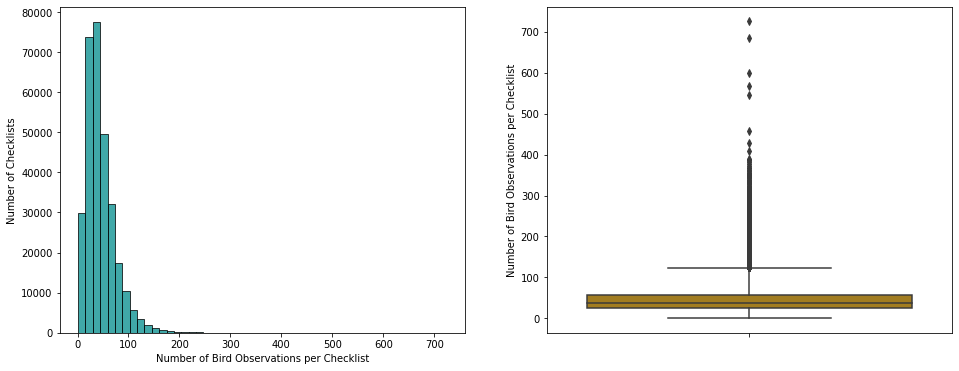

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(total_per_ckl, bins=50, color='darkcyan')
plt.xlabel("Number of Bird Observations per Checklist")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.boxplot(y = total_per_ckl, whis = 2, color='darkgoldenrod').set(ylabel = "Number of Bird Observations per Checklist")

plt.show()

Per checklist, consider any bird count over 175 to be an outlier.

In [ ]:
# Remove checklists that have more than 175 bird observations
rem_sub_id = list(total_per_ckl[total_per_ckl > 175].index)

bird = bird[~bird['sub_id'].isin(rem_sub_id)]

After the subset by bird count per checklist:

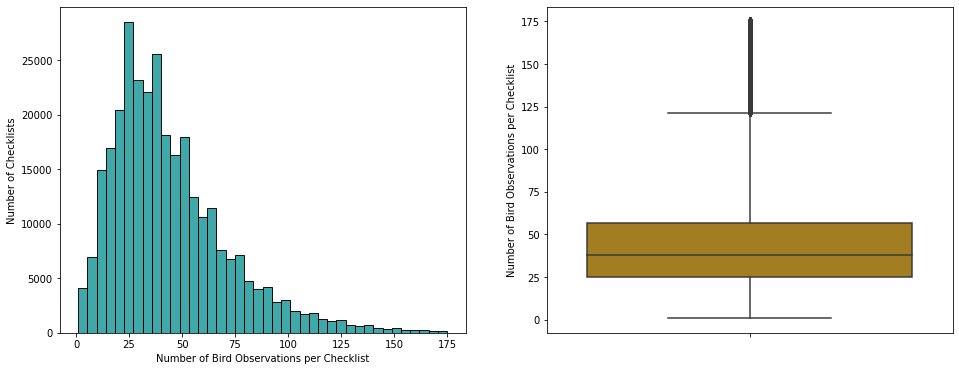

In [ ]:
new_total_per_ckl = bird.groupby('sub_id').sum()[spcs_list].sum(axis=1)

plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(new_total_per_ckl, bins=40, color='darkcyan')
plt.xlabel("Number of Bird Observations per Checklist")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.boxplot(y = new_total_per_ckl, whis = 2, color='darkgoldenrod').set(ylabel = "Number of Bird Observations per Checklist")

plt.show()

Next, investigate the total number of observations of each bird species over all seasons.  In other words, explore the number of bird species seen only a few times vs. the number of bird species seen numerous times.

In [ ]:
# Filter the dataframe by the bird columns and sum the rows 
# to get the total number of observations per species.
spcs_count = bird[spcs_list].sum(axis=0)

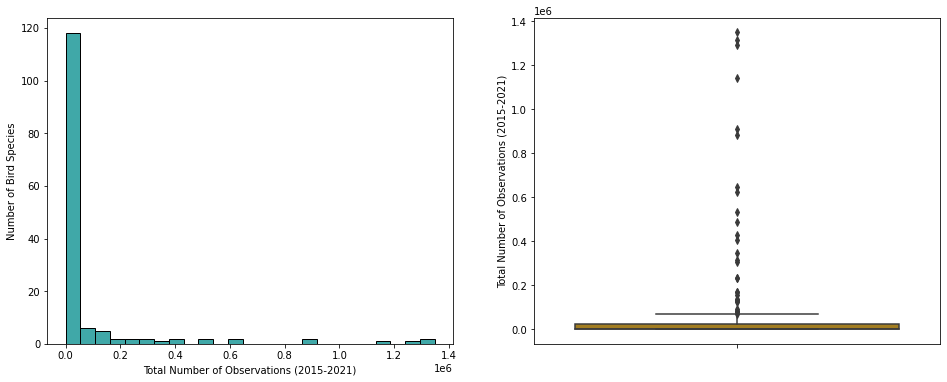

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(spcs_count, bins=25, color='darkcyan')
plt.xlabel("Total Number of Observations (2015-2021)")
plt.ylabel("Number of Bird Species")

plt.subplot(1, 2, 2)
sns.boxplot(y = spcs_count, whis = 2, color='darkgoldenrod').set(ylabel = "Total Number of Observations (2015-2021)")

plt.show()

In the above plots, the low end represents the large number of species of rarely seen birds, and the high end represents the small number of species of birds that are seen numerous times.  The latter is the focus of this study.

In [ ]:
# Set a floor for number of observations per bird species
obsv_min = 20000

# Get the birds that fall below the floor,
# and remove their columns from the data
drop_birds = spcs_count[spcs_count < obsv_min].index
bird = bird.drop(columns = drop_birds)

spcs_list = [x for x in bird.columns if x not in nospcs]

print('Current number of bird species in the data: {}'.format(len(spcs_list)))

Current number of bird species in the data: 39


In [ ]:
total_per_ckl = bird.groupby('sub_id').sum()[spcs_list].sum(axis=1)
total_per_ckl.describe()

count    303291.0000000
mean         43.5040835
std          27.0394965
min           0.0000000
25%          24.0000000
50%          38.0000000
75%          56.0000000
max         175.0000000
dtype: float64

Now, some checklists have zero birds.  Those checklists need to be dropped.

In [ ]:
zerobirds = list(total_per_ckl[total_per_ckl == 0].index)

bird = bird[~bird['sub_id'].isin(zerobirds)]

In [ ]:
spcs_count = bird[spcs_list].sum(axis=0)

After the subset of total observation count by species:

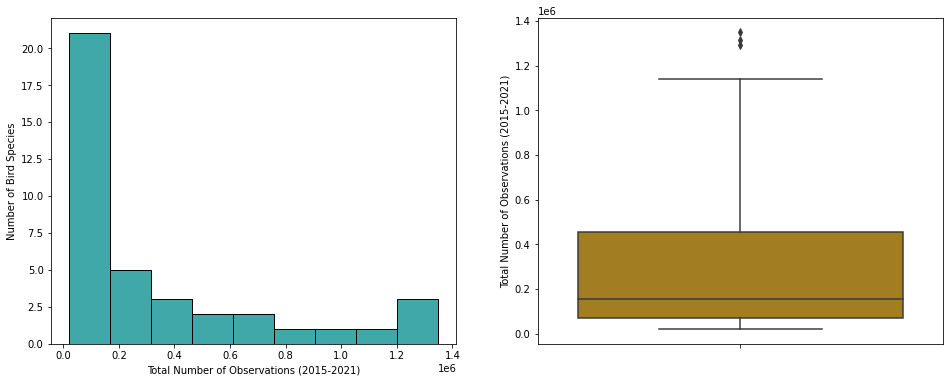

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(spcs_count, bins=9, color='darkcyan')
plt.xlabel("Total Number of Observations (2015-2021)")
plt.ylabel("Number of Bird Species")

plt.subplot(1, 2, 2)
sns.boxplot(y = spcs_count, whis = 2, color='darkgoldenrod').set(ylabel = "Total Number of Observations (2015-2021)")

plt.show()

Next, for some of the most common birds including eastern bluebirds, investigate the total number of observations per species per checklist.  Using a histogram per species, look into the number of checklists for which only a few of the birds of the same species were seen together vs. the number of checklists for which many of the birds of the same species were seen together.

In [ ]:
# Get a list of the 7 most common birds along with the eastern bluebird
expl = list(spcs_count.sort_values(ascending=False)[0:7].index) + ['easblu']

# Extract the checklists with observations of any of those eight birds,
# subsetting the columns of the eight birds
df_expl = bird[(bird[expl] > 0).any(1)][expl]
df_expl.head(3)

daejun  moudov  houspa  amegfi  houfin  norcar  eursta  easblu
0       3       0       7       6       5       0       0       0
1       2       0       0       0       3       0       0       0
2       1       0       0       1       0       0       0       0

The following histograms exclude the counts of zero of a species on a checklist. 

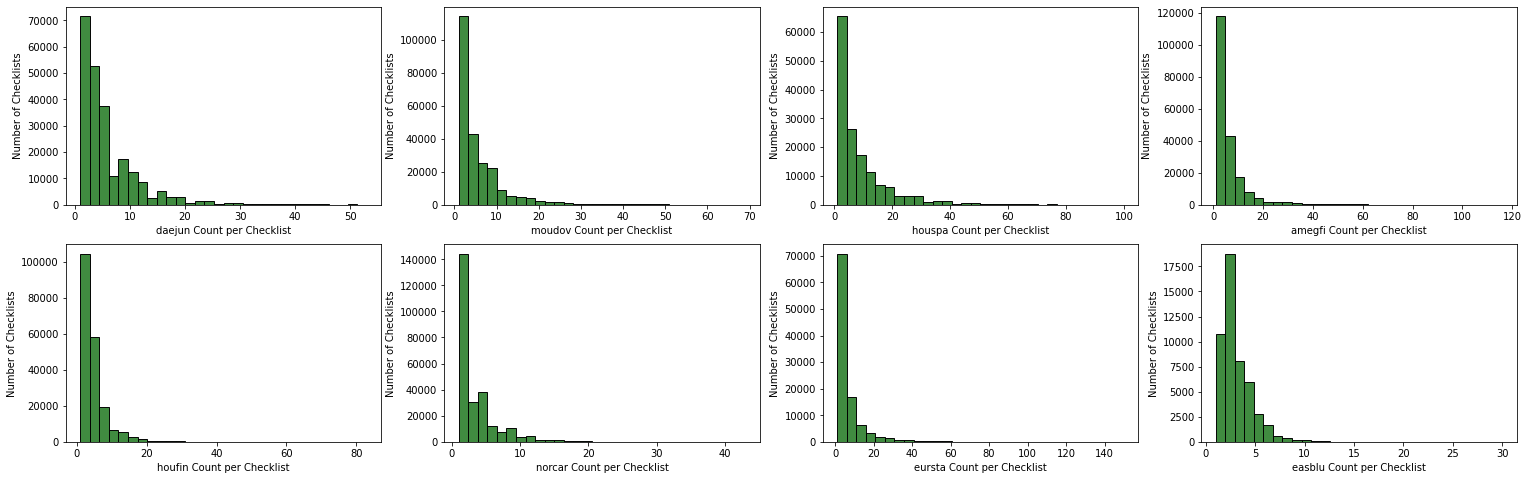

In [ ]:
plt.figure(figsize=(26,8))
plt.tight_layout

for idx, col in enumerate(expl):
  plt.subplot(2, 4, idx+1)
  sns.histplot(df_expl[df_expl[col] > 0][col], bins=30, color='darkgreen')
  plt.xlabel(col + " Count per Checklist")
  plt.ylabel("Number of Checklists")

The histograms illustrate the likeliness of a species to be observed alone, in a group of 2 or 3 of the same species, or in a much larger group of the same species.

Have a closer look at the above histogram for the eastern bluebird (easblu) alongside a boxplot.

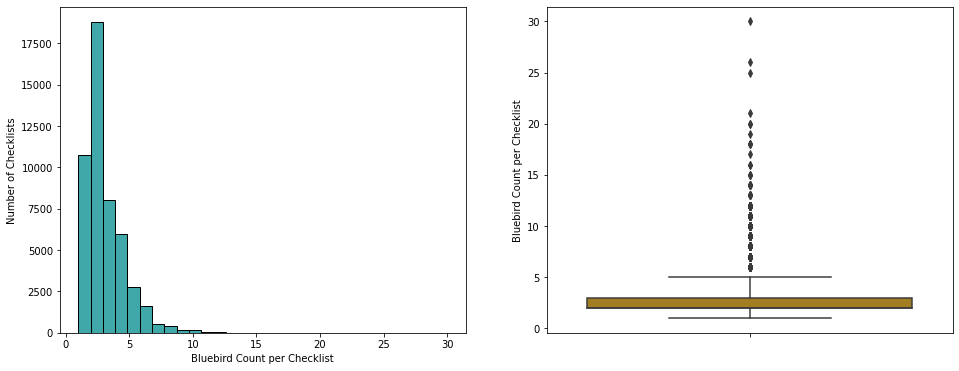

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(df_expl[df_expl['easblu'] > 0]['easblu'], bins=30, color='darkcyan')
plt.xlabel("Bluebird Count per Checklist")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.boxplot(y = df_expl[df_expl['easblu'] > 0]['easblu'], whis = 2, color='darkgoldenrod').set(ylabel = "Bluebird Count per Checklist")

plt.show()

In [ ]:
bird['easblu'].describe()

count    303262.0000000
mean          0.4331634
std           1.1817064
min           0.0000000
25%           0.0000000
50%           0.0000000
75%           0.0000000
max          30.0000000
Name: easblu, dtype: float64

The objective of this study is to model the presence/absence of the eastern bluebird.  As shown in the plots and descriptive statistics above, a bluebird is rarely observed in groups of 6 or more. Given the objective and the exploration of the bluebird data, the practical step is then to convert the bluebird target into a binary variable.

In [ ]:
# CATEGORIZING
# This method returns group numbers 
# given bird species observations per checklist 

def categorize(obs_num):
    if obs_num == 0:
        return 0
    else:
        return 1

In [ ]:
# Convert the bluebird target to a binary variable,
# where 0 indicates absence,
# and 1 indicates presence

bird['easblu_gr'] = bird['easblu'].apply(categorize)

print(bird.groupby("easblu_gr")["easblu"].count())

easblu_gr
0    253935
1     49327
Name: easblu, dtype: int64


In [ ]:
zerobb = bird.groupby("easblu_gr")["easblu"].count()[0]
onebb = bird.groupby("easblu_gr")["easblu"].count()[1]
print('{} percent of records with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent of records with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))

83.7 percent of records with no bluebird
16.3 percent of records with bluebird


The imbalance in the binary target, easblu_gr, will be improved in a later step.

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in bird.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(bird['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(bird.shape))

Current number of sites in the data: 4443


Current number of bird species in the data: 40


Current shape of the data: (303262, 116)


###Further Data Exploration

Correlations of other bird species with the target, easblu_gr:

In [ ]:
bcorr = bird[spcs_list].corr()['easblu_gr'].sort_values(key=pd.Series.abs, ascending=False)
bcorr

easblu_gr    1.0000000
easblu       0.8316906
carwre       0.2543696
yerwar       0.2405922
carchi       0.2159672
eastow       0.1792369
normoc       0.1769999
houspa      -0.1488366
bkcchi      -0.1460889
rebwoo       0.1443570
chispa       0.1356684
norfli       0.1281897
whtspa       0.1036149
pinsis       0.0884822
houfin       0.0858572
amerob       0.0834533
dowwoo       0.0804185
tuftit       0.0762323
amegfi       0.0744754
amecro       0.0738574
norcar       0.0673718
blujay      -0.0577215
moudov      -0.0509945
amtspa      -0.0488878
cedwax       0.0450977
whbnut       0.0422754
rewbla       0.0407253
rocpig1     -0.0379613
purfin       0.0371261
sonspa       0.0356472
y00033       0.0350423
bnhcow       0.0315252
coohaw       0.0274340
wiltur      -0.0210985
daejun       0.0205720
eursta       0.0135489
comgra       0.0071611
comred      -0.0063011
haiwoo      -0.0012447
rebnut       0.0007859
Name: easblu_gr, dtype: float64

In [ ]:
# Remove any bird species that has lower than min_corr correlation with the target
min_corr = 0.01

remcorr = list(bcorr[np.abs(bcorr) < min_corr].index)
bird = bird.loc[:, ~bird.columns.isin(remcorr)]

In [ ]:
spcs_list = [x for x in bird.columns if x not in nospcs]

total_per_ckl = bird.groupby('sub_id').sum()[spcs_list].sum(axis=1)
total_per_ckl.describe()

count    303262.000000
mean         41.861740
std          25.660073
min           0.000000
25%          24.000000
50%          36.000000
75%          54.000000
max         175.000000
dtype: float64

Following the latest bird removal, some checklists have zero birds again.  Those checklists need to be dropped.

In [ ]:
zerobirds = list(total_per_ckl[total_per_ckl == 0].index)

bird = bird[~bird['sub_id'].isin(zerobirds)]

In [ ]:
# Get a list of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'easblu']

# Create a df of independent variables
X = bird.loc[:, ~bird.columns.isin(excl_vars + ['easblu_gr'])]

# Then look into the correlations among independent variables.
# The function, get_top_abs_correlations, has been defined at 
# the beginning of the notebook.  
# It returns correlations between all pairs of variables in the df.
get_top_abs_correlations(X)

fed_in_jan          fed_in_feb            0.9867302
fed_in_jul          fed_in_aug            0.9811443
fed_in_feb          fed_in_mar            0.9792647
fed_in_jan          fed_in_mar            0.9752595
fed_in_nov          fed_in_dec            0.9555777
                                            ...    
evgr_trees_atleast  fed_in_feb            0.0000159
numfeeders_humming  uic_2013              0.0000103
day                 dcid_trees_atleast    0.0000101
amecro              dogs                  0.0000056
rewbla              yard_type_landsca     0.0000052
Length: 5356, dtype: float64

Due to high correlations, reintroduce fed_yr_round as a binary variable based on the monthly variables.

First, sum the monthly feed values across the columns (axis=1).  

In [ ]:
fed_col = list(fed_col)
bird['fed_yr_round'] = bird[fed_col].sum(axis=1)

Then, if the sum equals 12, set fed_yr_round to 1, else set it to 0.

In [ ]:
# CATEGORIZING
def categorize(fed_num):
    if fed_num == 12:
        return 1
    else:
        return 0

In [ ]:
bird['fed_yr_round'] = bird['fed_yr_round'].apply(categorize)
print(bird.groupby("fed_yr_round")["sub_id"].count())

fed_yr_round
0    119521
1    183724
Name: sub_id, dtype: int64


In [ ]:
bird[fed_col+['fed_yr_round']].sample(4)

fed_in_jan  fed_in_feb  fed_in_mar  fed_in_apr  fed_in_may  \
3420           1.0         1.0         1.0         1.0         1.0   
265840         0.0         0.0         0.0         0.0         0.0   
244015         1.0         1.0         1.0         1.0         1.0   
228086         1.0         1.0         1.0         1.0         0.0   

        fed_in_jun  fed_in_jul  fed_in_aug  fed_in_sep  fed_in_oct  \
3420           1.0         1.0         1.0         1.0         1.0   
265840         0.0         0.0         0.0         0.0         0.0   
244015         1.0         1.0         1.0         1.0         1.0   
228086         0.0         0.0         0.0         0.0         0.0   

        fed_in_nov  fed_in_dec  fed_yr_round  
3420           1.0         1.0             1  
265840         0.0         0.0             0  
244015         1.0         1.0             1  
228086         1.0         1.0             0

Drop the monthly feed variables.

In [ ]:
bird = bird.drop(columns = fed_col)

Recheck the correlations.

In [ ]:
X = bird.loc[:, ~bird.columns.isin(excl_vars + ['easblu_gr'])]
get_top_abs_correlations(X)

ruc_2013            uic_2013              0.9200931
tmin                tmax                  0.8190179
yard_type_landsca   hab_residential       0.7081156
hab_residential     squirrels             0.6995937
yard_type_landsca   squirrels             0.6522221
                                            ...    
longitude           hab_water_fresh       0.0000311
numfeeders_humming  uic_2013              0.0000103
day                 dcid_trees_atleast    0.0000101
amecro              dogs                  0.0000056
rewbla              yard_type_landsca     0.0000052
Length: 4278, dtype: float64

The rural-urban continuum codes (ruc_2013) and the urban-influence codes (uic_2013) are very similar metrics in defining rural vs. urban counties.  They are showing high correlation with each other.  Drop uic_2013.

In [ ]:
bird = bird.drop(columns = 'uic_2013')

The next section will look into the temporal distribution of the data.

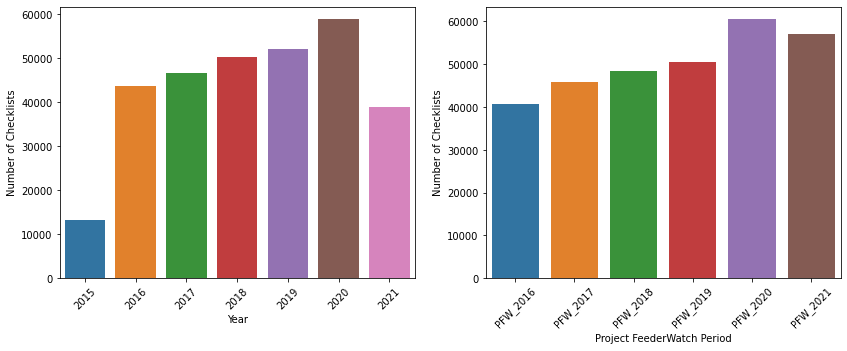

Months of Project FeederWatch: [11, 1, 12, 2, 3, 4]


In [ ]:
plt.figure(figsize = (14,5))

gbyear = bird.groupby('year').count()['sub_id']
gbseas = bird.groupby('proj_period_id').count()['sub_id']

plt.subplot(1, 2, 1)
sns.barplot(gbyear.index, gbyear)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.barplot(gbseas.index, gbseas)
plt.xticks(rotation=45)
plt.xlabel("Project FeederWatch Period")
plt.ylabel("Number of Checklists")

plt.show()

print("Months of Project FeederWatch: {}".format(list(bird['month'].unique())))

The above bar plots show the difference between the actual year and the Project FeederWatch period. Each Project FeederWatch period runs from November through the following April, and is denoted by the year in which the period ends.  As a result, the data spans 7 years but only 6 periods, with the bounding years, 2015 and 2021, only partially represented in the data.  The number of checklists is therefore more uniform across periods than it is across years.  

For this reason, the project period will be the primary unit of time for modeling, and the following features will be created:
*  The month, day, and year variables will not be used in the model.  Instead, they will be replaced with a variable that represents the number of days from the start of each period, which is Nov. 1st.
*  The proj_period_id field will be categorized into a new variable to be included in the model.   

First, create a datetime column using the year, month, and day columns.

In [ ]:
bird['datetime'] = bird['year'].astype(str) + "-" + bird['month'].astype(str) + "-" + bird['day'].astype(str)

def dateformat(date):
    return datetime.strptime(date, '%Y-%m-%d')

bird['datetime'] = bird['datetime'].apply(dateformat)

Then create a column for day_in_period and populate it based on the start date of Nov. 1st for each period.

In [ ]:
df_list = []

for per in periods:

    # Set the period start date to Nov. 1st for each period
    start = datetime.strptime(str(int(per[-4:])-1)+'-11-01', '%Y-%m-%d')

    # The df filtered on one period
    df = bird[bird['proj_period_id'] == per]

    # day_in_period = number of days from the period start
    df['day_in_period'] = df['datetime'] - start
    df_list.append(df)

bird = pd.concat(df_list, ignore_index=True)
bird['day_in_period'] = pd.to_numeric(bird['day_in_period'].dt.days, downcast='integer')
bird['day_in_period'] = bird['day_in_period'] + 1

Next, categorize the project periods into a numeric variable by stripping off the last two digits in proj_period_id.

In [ ]:
# CATEGORIZING
def categorize(period):
    return int(period[-2:])

In [ ]:
bird['proj_period'] = bird['proj_period_id'].apply(categorize)

The result:

In [ ]:
bird[['datetime', 'day_in_period', 'proj_period_id', 'proj_period']].sample(4)

datetime  day_in_period proj_period_id  proj_period
137013 2018-11-17             17       PFW_2019           19
77455  2017-01-26             87       PFW_2017           17
149921 2019-01-05             66       PFW_2019           19
293766 2021-04-03            154       PFW_2021           21

Also create a column for week number, which will be used later in the notebook for unsupervised learning.

In [ ]:
bird['week'] = bird['datetime'].dt.week

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'week']

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr + ['fed_yr_round', 'datetime', 'day_in_period', 'proj_period', 'week']).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in bird.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(bird['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(bird.shape))

Current number of sites in the data: 4443


Current number of bird species in the data: 36


Current shape of the data: (303245, 104)


### Improve Data Balance and Reduce Bias

As shown previously, the binary target, easblu_gr is imbalanced:

In [ ]:
zerobb = bird.groupby("easblu_gr")["easblu"].count()[0]
onebb = bird.groupby("easblu_gr")["easblu"].count()[1]
print('{} percent with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))

83.7 percent with no bluebird
16.3 percent with bluebird


This imbalance can also be seen at the state level:

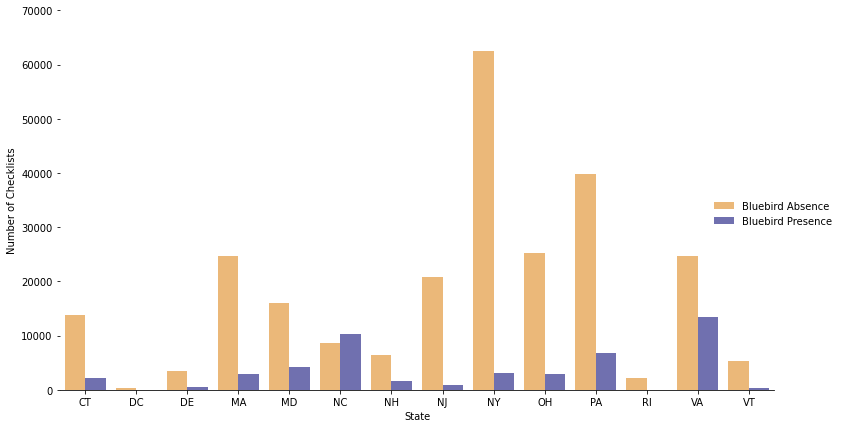

In [ ]:
bbstate = bird.groupby(['state', 'easblu_gr']).count().reset_index()[['sub_id', 'state', 'easblu_gr']]

plot_bbstate(bbstate, "", 6, 11/6, 70000)

Correlations between the target and non-species variables:

In [ ]:
# Get a list of non-species variables
noenv = spcs_list + excl_vars
envi = [x for x in bird.columns if x not in noenv]

# easblu_gr correlation wth non-species variables
bcorr = bird[envi + ['easblu_gr']].corr()['easblu_gr'][:].sort_values(key=pd.Series.abs, ascending=False)
bcorr[0:23]

easblu_gr                       1.0000000
latitude                       -0.3229425
tmax                            0.1565514
tmin                            0.1266671
evgr_shrbs_atleast              0.1057161
day_in_period                   0.1033528
longitude                      -0.0995363
bird_baths_atleast              0.0909240
ruc_2013                       -0.0903326
water_area                     -0.0877511
dcid_trees_atleast              0.0810918
proj_period                     0.0809493
fed_yr_round                    0.0782377
numfeeders_humming              0.0759532
count_area_size_sq_m_atleast    0.0748294
numfeeders_other                0.0723001
hab_industrial                 -0.0667557
cats                           -0.0658946
snow_dep_atleast               -0.0638341
yard_type_woods                 0.0632368
effort_hrs_atleast              0.0612636
pop_dens                       -0.0568370
numfeeders_suet                 0.0567319
Name: easblu_gr, dtype: float64

There is some negative correlation between easblu_gr and variables that represent the level of urban development:
*  Between easblu_gr and ruc_2013
*  Between easblu_gr and pop_dens                    

Next, have a look at the site count within each rural-urban continuum code.

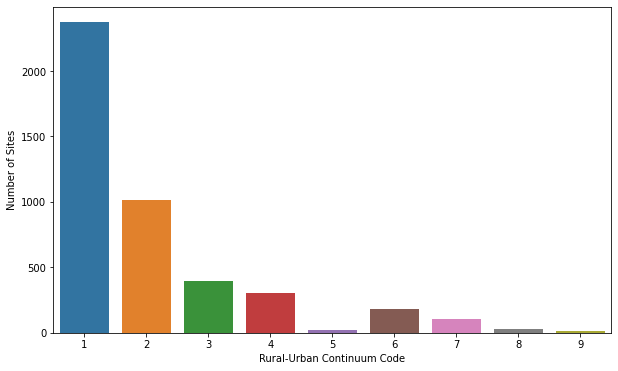

In [ ]:
# Get a df of site vs. rural-urban continuum code
sita = bird.groupby('loc_id')['ruc_2013'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Get total counts of sites by rural-urban continuum code
ruta = sita.groupby('ruc_2013').count()['loc_id']

plt.figure(figsize = (10,6))

sns.barplot(ruta.index, ruta)
plt.xlabel("Rural-Urban Continuum Code")
plt.ylabel("Number of Sites")

plt.show()

The sites are biased towards the metro areas, where code=1 represents counties in metro areas of 1 million population or more.

Additionally, the bias can be seen on the map of sites, where clusters occur around major cities:

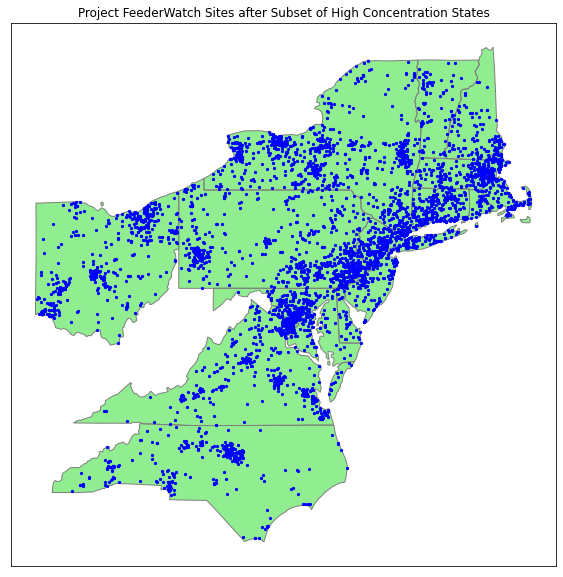

In [ ]:
long_lat = bird.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

plot_map(geo_df, (10,10), "Project FeederWatch Sites after Subset of High Concentration States")

The takeaway from the above data exploration, is that by improving the balance of the target variable, the site bias can be improved as well.  The objective is not to achieve a perfect 50-50 balance of bluebird presence vs. absence, which would be artificial.  Instead, it is simply to improve the balance.

The following steps will reduce the group size representing bluebird absence.  This will be done with random subsampling at the state level.

In [ ]:
# Sum the bluebirds within each loc_id, returning the state as well
sumbb = bird.groupby(['loc_id', 'state'])['easblu'].sum().reset_index()

# Return the state and the count of loc_ids where the total bluebird count is zero
state_counts = sumbb[sumbb['easblu'] == 0].groupby(['state']).count().reset_index()[['state', 'loc_id']] \
                                .sort_values(by='loc_id', ascending=False)

# For sites with absolutely no observation of a bluebird,
# create the df showing the number of sites in a state per unit area of the state
usa_loc_conc = usa_sub.merge(state_counts, how='left', on=['state'])
usa_loc_conc = usa_loc_conc.rename(columns={'loc_id': 'loc_counts'})
usa_loc_conc['locs_per_area'] = (usa_loc_conc['loc_counts'] / usa_loc_conc['ALAND'])*1000000
usa_loc_conc.sort_values(by='locs_per_area', ascending=False)[['state', 'loc_counts', 'locs_per_area']].head(15)

state  loc_counts  locs_per_area
10    DC           8      0.0505241
13    RI          32      0.0119502
6     MA         229      0.0113338
9     NJ         208      0.0109199
8     CT         107      0.0085310
1     DE          31      0.0061436
5     NY         627      0.0051373
0     MD         108      0.0042940
3     PA         303      0.0026147
2     OH         198      0.0018709
7     VT          43      0.0018011
12    NH          24      0.0010350
4     VA          96      0.0009388
11    NC          19      0.0001509

In [ ]:
pfbird = bird.copy()

# Create a df with state vs. number of loc_ids for loc_ids without any bluebird sighting
abs = sumbb[sumbb['easblu'] == 0].groupby('state')['loc_id'].count().reset_index()

In [ ]:
# For sites without any bluebird sightings,
# the sites per area in a state will be reduced to lpa if locs_per_area > lpa
lpa = 0.00016

# Get states that meet the lpa criteria
sts = list(usa_loc_conc[usa_loc_conc['locs_per_area'] > lpa]['state'])

# Based on lpa at the state level, randomly subsample the group representing bluebird absence.
for state in sts:
    ratio = 1 - (lpa / list(usa_loc_conc[usa_loc_conc['state'] == state]['locs_per_area'])[0])
    samp = int(ratio*abs[abs['state'] == state]['loc_id'])   # Sample size to remove
    dloc = sumbb[(sumbb['state'] == state) & (sumbb['easblu'] == 0)]['loc_id'].sample(samp, random_state=179)
    pfbird = pfbird[~pfbird['loc_id'].isin(list(dloc))]   # dloc is the list of sites to remove

In [ ]:
# Sum the bluebirds within each loc_id, returning the state as well
sumbb = pfbird.groupby(['loc_id', 'state'])['easblu'].sum().reset_index()

# Return the state and the count of loc_ids where the total bluebird count is zero
state_counts = sumbb[sumbb['easblu'] == 0].groupby(['state']).count().reset_index()[['state', 'loc_id']] \
                                .sort_values(by='loc_id', ascending=False)

# For sites with absolutely no observation of a bluebird,
# create the df showing the number of sites in a state per unit area of the state
usa_loc_conc = usa_sub.merge(state_counts, how='left', on=['state'])
usa_loc_conc = usa_loc_conc.rename(columns={'loc_id': 'loc_counts'})
usa_loc_conc['locs_per_area'] = (usa_loc_conc['loc_counts'] / usa_loc_conc['ALAND'])*1000000
usa_loc_conc.sort_values(by='locs_per_area', ascending=False)[['state', 'loc_counts', 'locs_per_area']].head(15)                   

state  loc_counts  locs_per_area
10    DC           1      0.0063155
13    RI           1      0.0003734
8     CT           3      0.0002392
9     NJ           4      0.0002100
0     MD           5      0.0001988
1     DE           1      0.0001982
6     MA           4      0.0001980
12    NH           4      0.0001725
7     VT           4      0.0001675
4     VA          17      0.0001662
3     PA          19      0.0001640
5     NY          20      0.0001639
2     OH          17      0.0001606
11    NC          19      0.0001509

As shown above, the locs_per_area for no-bluebird sites is now more consistent across states.

In [ ]:
zerobb = bird.groupby("easblu_gr")["easblu"].count()[0]
onebb = bird.groupby("easblu_gr")["easblu"].count()[1]
print('Balance of binary target:')
print('\n')

print('Before subsampling:')
print('{} percent with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))
print('\n')

print('After subsampling:')
zerobb = pfbird.groupby("easblu_gr")["easblu"].count()[0]
onebb = pfbird.groupby("easblu_gr")["easblu"].count()[1]
print('{} percent with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))

Balance of binary target:


Before subsampling:
83.7 percent with no bluebird
16.3 percent with bluebird


After subsampling:
73.0 percent with no bluebird
27.0 percent with bluebird


As shown above, the balance of the binary target has improved.

In [ ]:
print('Total number of sites:')
print('\n')
print('Before subsampling:')
print(bird['loc_id'].nunique())
print('\n')
print('After subsampling:')
pfbird['loc_id'].nunique()

Total number of sites:


Before subsampling:
4443


After subsampling:


2529

As shown above, the total number of sites has reduced.

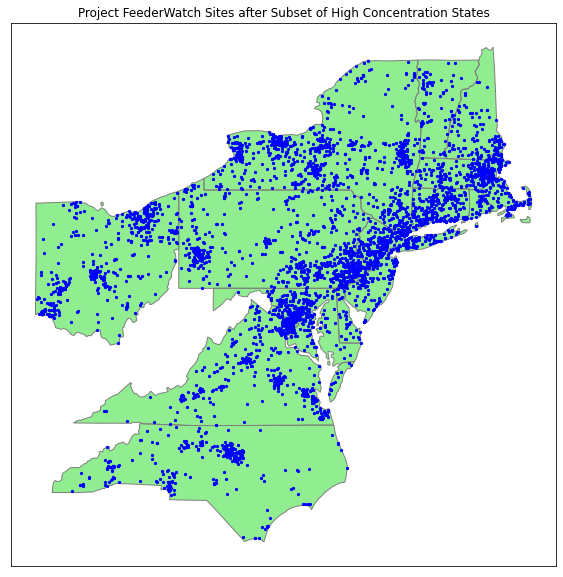

In [ ]:
long_lat1 = bird.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry1 = [Point(xy) for xy in zip(long_lat1['longitude'], long_lat1['latitude'])]
geo_df1 = gpd.GeoDataFrame(long_lat1, crs=crs, geometry=geometry1)

long_lat2 = pfbird.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry2 = [Point(xy) for xy in zip(long_lat2['longitude'], long_lat2['latitude'])]
geo_df2 = gpd.GeoDataFrame(long_lat2, crs=crs, geometry=geometry2)

plot_map(geo_df1, (10,10), "Project FeederWatch Sites after Subset of High Concentration States")

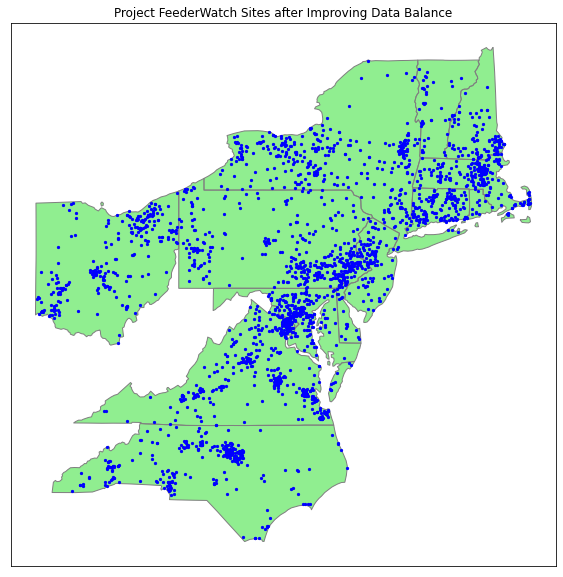

In [ ]:
plot_map(geo_df2, (10,10), "Project FeederWatch Sites after Improving Data Balance")

As shown above, the site clusters around major cities have lessened.

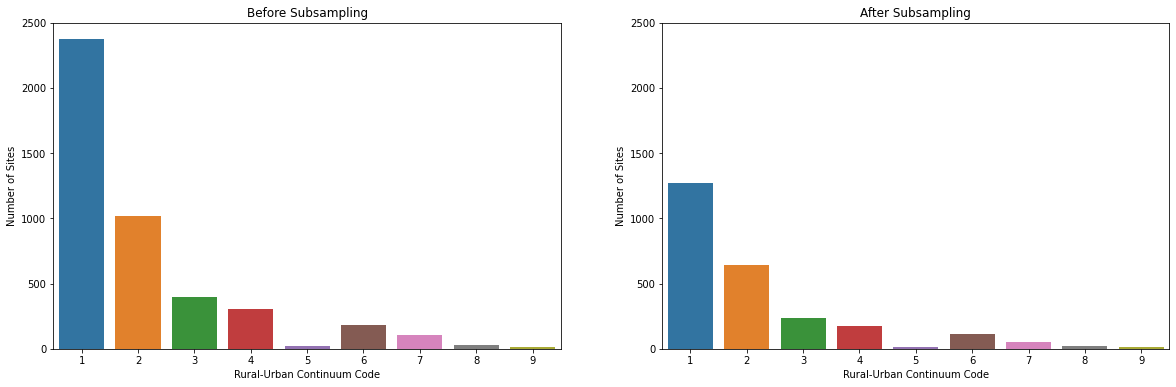

In [ ]:
# Get a df of site vs. rural-urban continuum code
sita = bird.groupby('loc_id')['ruc_2013'].apply(lambda x: x.mode().iloc[0]).reset_index()
sitb = pfbird.groupby('loc_id')['ruc_2013'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Get total counts of sites by rural-urban continuum code
ruta = sita.groupby('ruc_2013').count()['loc_id']
rutb = sitb.groupby('ruc_2013').count()['loc_id']

plt.figure(figsize = (20,6))

plt.subplot(1, 2, 1)
sns.barplot(ruta.index, ruta)
plt.xlabel("Rural-Urban Continuum Code")
plt.ylabel("Number of Sites")
plt.title("Before Subsampling")
plt.ylim(0, 2500)

plt.subplot(1, 2, 2)
sns.barplot(rutb.index, rutb)
plt.xlabel("Rural-Urban Continuum Code")
plt.ylabel("Number of Sites")
plt.title("After Subsampling")
plt.ylim(0, 2500)

plt.show()

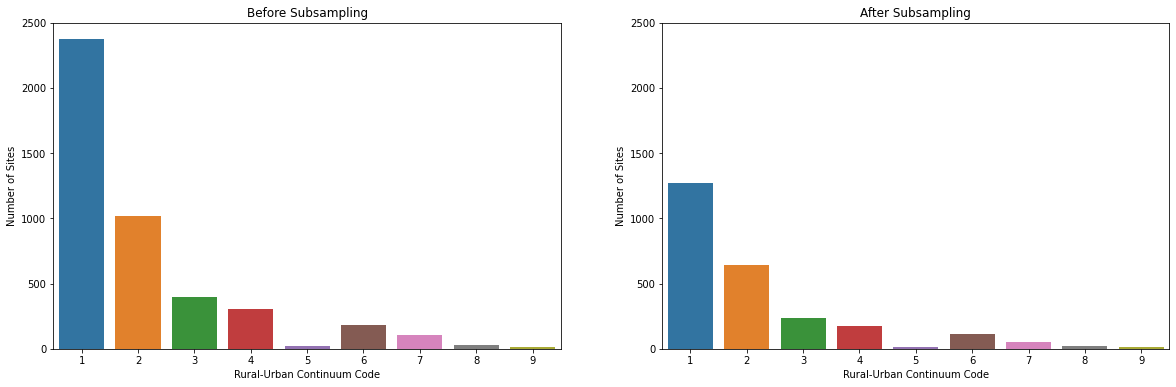

In [ ]:
plt.figure(figsize = (20,6))

plt.subplot(1, 2, 1)
sns.barplot(ruta.index, ruta)
plt.xlabel("Rural-Urban Continuum Code")
plt.ylabel("Number of Sites")
plt.title("Before Subsampling")
plt.ylim(0, 2500)

plt.subplot(1, 2, 2)
sns.barplot(rutb.index, rutb)
plt.xlabel("Rural-Urban Continuum Code")
plt.ylabel("Number of Sites")
plt.title("After Subsampling")
plt.ylim(0, 2500)

plt.show()

In [ ]:
dc = {'1': 100*ruta[1]/(ruta[1] + ruta[2:].sum()), '2-9': 100*ruta[2:].sum()/(ruta[1] + ruta[2:].sum())}
rutc = pd.Series(data=dc, index=['1', '2-9'])

dd = {'1': 100*rutb[1]/(rutb[1] + rutb[2:].sum()), '2-9': 100*rutb[2:].sum()/(rutb[1] + rutb[2:].sum())}
rutd = pd.Series(data=dd, index=['1', '2-9'])

In [ ]:
rutc

1      69.2846715
2-9    30.7153285
dtype: float64

In [ ]:
rutd

1      67.4085851
2-9    32.5914149
dtype: float64

As shown above, the subsampling has had the largest overall effect on the first two rural-urban continuum codes, which represent the most urban areas.

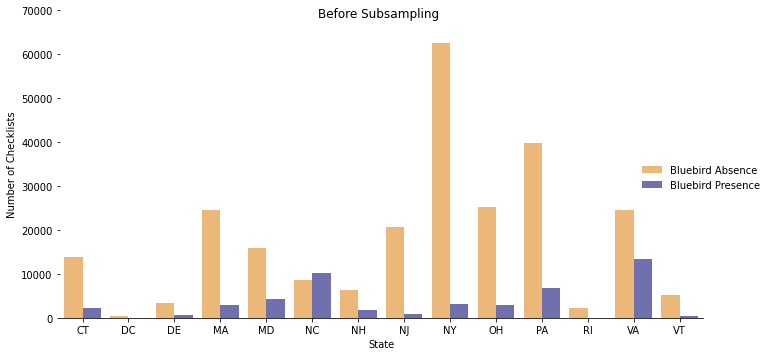

In [ ]:
bbstate1 = bird.groupby(['state', 'easblu_gr']).count().reset_index()[['sub_id', 'state', 'easblu_gr']]
bbstate2 = pfbird.groupby(['state', 'easblu_gr']).count().reset_index()[['sub_id', 'state', 'easblu_gr']]

plot_bbstate(bbstate1, "Before Subsampling", 5, 10/5, 70000)

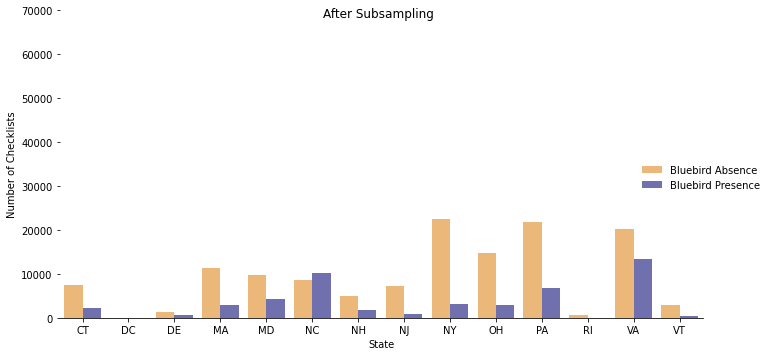

In [ ]:
plot_bbstate(bbstate2, "After Subsampling", 5, 10/5, 70000)

As shown above, the subsampling improved the balance within the states.

At this point, save the prepped dataset to a csv.

In [ ]:
pfbird.to_csv(fdir + "intermediate_prepped_data.csv")

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr + ['fed_yr_round', 'datetime', 'day_in_period', 'proj_period', 'week']).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in pfbird.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(pfbird['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pfbird.shape))

Current number of sites in the data: 2529


Current number of bird species in the data: 36


Current shape of the data: (182918, 104)


##Classification Modeling

###Split into Training and Test Sets

Get ready for modeling.

In [ ]:
pfdata = pd.read_csv(fdir + "intermediate_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

Set the dependent and independent variables, and split the data into training and test sets.

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'week']

y = pfdata['easblu_gr']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(182918, 91)

stratify=y results in consistent class distribution between training and test sets:

In [ ]:
y_train[y_train == 1].shape[0] / y_train[y_train == 0].shape[0]

0.36923264061081845

In [ ]:
y_test[y_test == 1].shape[0] / y_test[y_test == 0].shape[0]

0.3692641664795269

Reviewing correlations again.

In [ ]:
corr_feat = get_top_abs_correlations(X)
corr_feat[:12]

tmin               tmax               0.8202981
yard_type_landsca  hab_residential    0.6949224
hab_residential    squirrels          0.6567375
yard_type_landsca  squirrels          0.6220783
latitude           bkcchi             0.5773932
hab_residential    humans             0.5481844
latitude           longitude          0.5347962
                   carchi             0.5263214
yard_type_landsca  humans             0.5218893
hab_residential    fed_yr_round       0.5090656
yard_type_woods    squirrels          0.5084264
squirrels          fed_yr_round       0.5072454
dtype: float64

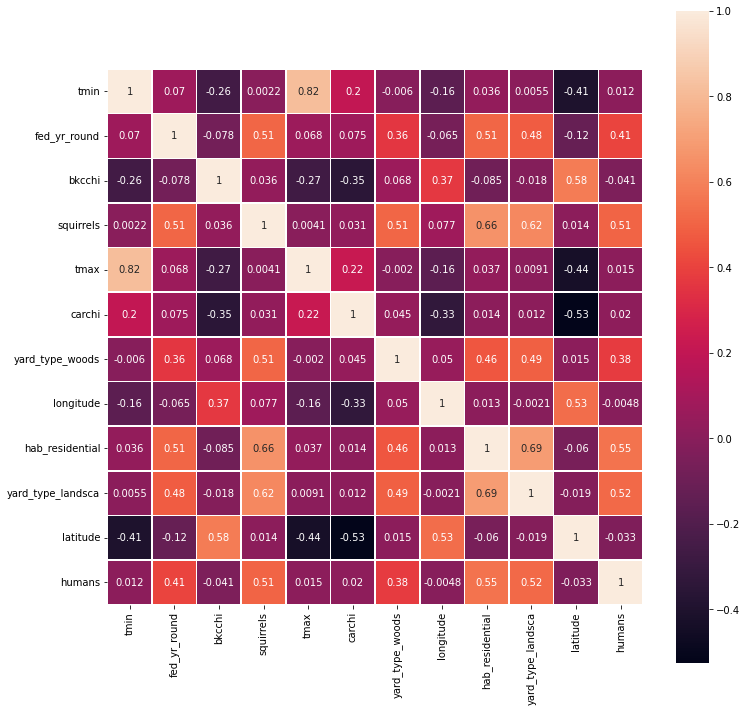

In [ ]:
top_corr_feat = list(set(list(corr_feat[:12].index.get_level_values(0)) + list(corr_feat[:12].index.get_level_values(1))))

plt.figure(figsize=(12, 12))

sns.heatmap(pfdata[top_corr_feat].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

In [ ]:
corr_targ = pfdata.loc[:, ~pfdata.columns.isin(excl_vars)].corr()['easblu_gr'].sort_values(key=pd.Series.abs, ascending=False)
round(corr_targ[:14], 3)

easblu_gr        1.000
latitude        -0.273
carwre           0.239
yerwar           0.214
normoc           0.172
carchi           0.169
bkcchi          -0.164
tmax             0.158
eastow           0.145
ruc_2013        -0.142
day_in_period    0.140
tmin             0.135
norfli           0.123
houspa          -0.122
Name: easblu_gr, dtype: float64

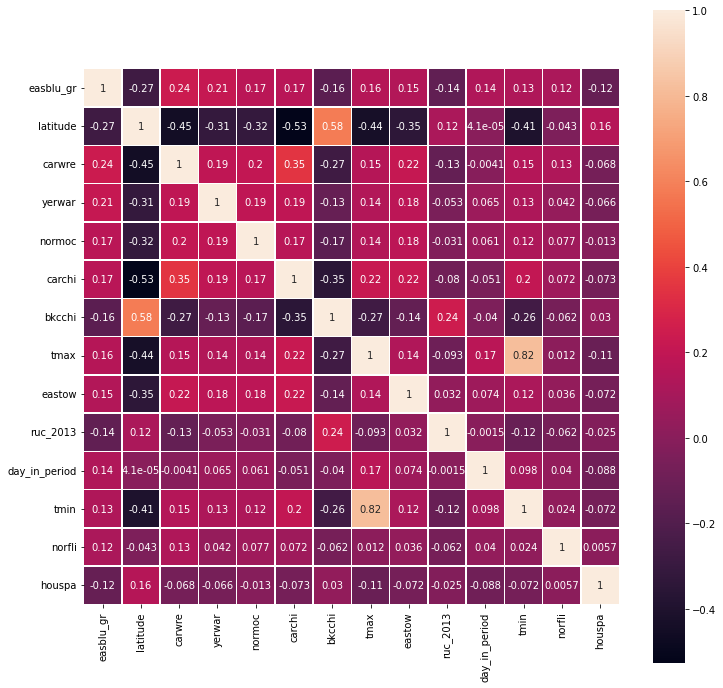

In [ ]:
plt.figure(figsize=(12, 12))

sns.heatmap(pfdata[list(corr_targ[:14].index)].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

In [ ]:
pfdata[['easblu_gr', 'houspa', 'pop_dens', 'ruc_2013']].corr()

easblu_gr     houspa   pop_dens   ruc_2013
easblu_gr  1.0000000 -0.1224790  0.0396610 -0.1415579
houspa    -0.1224790  1.0000000  0.1011562 -0.0245208
pop_dens   0.0396610  0.1011562  1.0000000 -0.2571206
ruc_2013  -0.1415579 -0.0245208 -0.2571206  1.0000000

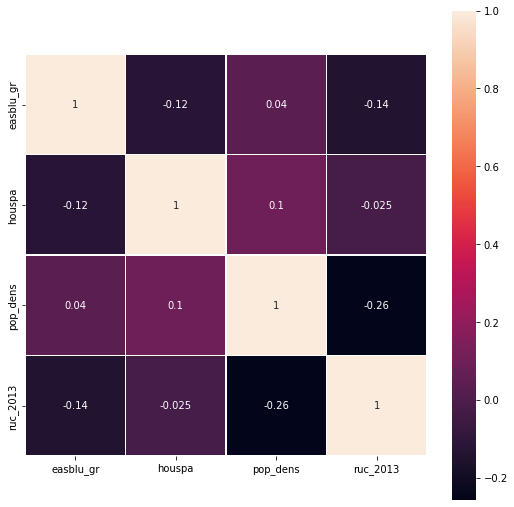

In [ ]:
plt.figure(figsize=(9, 9))

sns.heatmap(pfdata[['easblu_gr', 'houspa', 'pop_dens', 'ruc_2013']].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

###Initial Random Forest: feature importance, further feature selection

An initial random forest classifier will be run in order to investigate feature importance.

In [ ]:
start_time = time.clock()

rfc = ensemble.RandomForestClassifier(n_estimators=900, min_samples_leaf=1, min_samples_split=2, random_state=445, n_jobs=8)
rfc.fit(X_train, y_train)

cv_scores = cross_val_score(rfc, X_train, y_train, cv=4)
print('Accuracy scores for the folds: ', cv_scores)
print('Mean cross-validation score: {:.3f}'.format(np.mean(cv_scores)))
print('\n')

run_time = time.clock() - start_time
print('Run time: {:.3f}'.format(run_time))

Accuracy scores for the folds:  [0.86141483 0.86354691 0.86318782 0.86324249]
Mean cross-validation score: 0.863


Run time: 657.235


The consistent CV scores show that the model is very generalizable across test sets.

Feature importance:

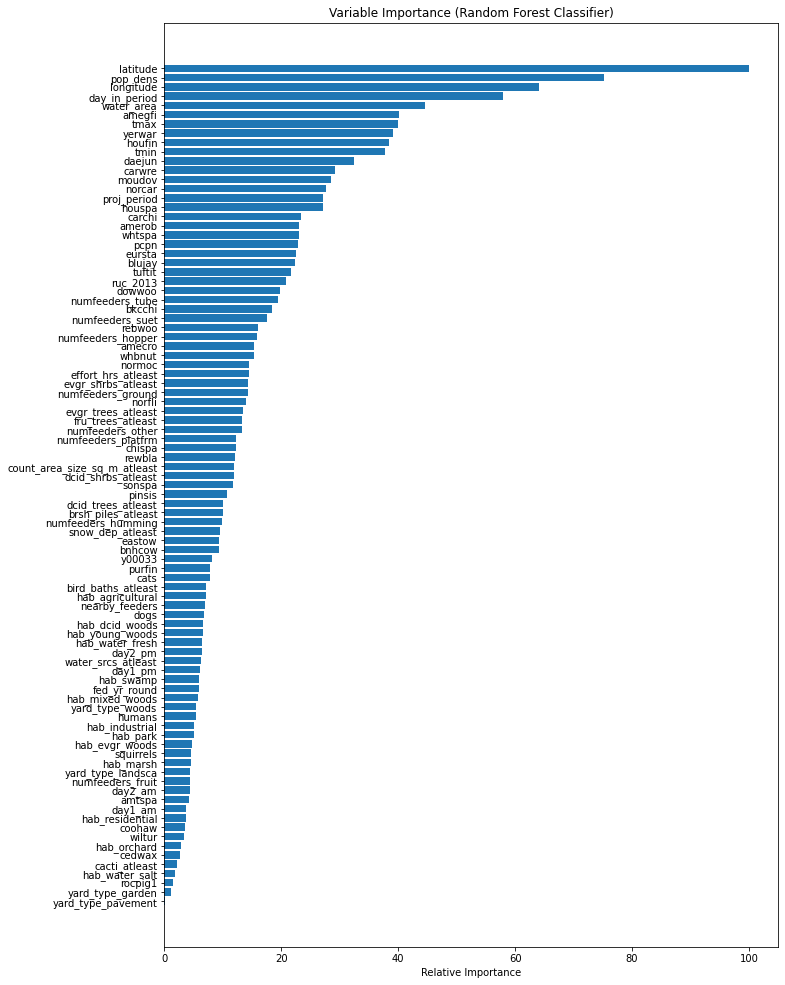

In [ ]:
plt.figure(figsize = (11,17))

plot_feat_imp(rfc, 'Random Forest Classifier', 91, X)

plt.show()

Remove variables with low feature importance.

In [ ]:
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
lowfeat = feat_importances[feat_importances < 0.00935].index.tolist()
pfdata = pfdata.drop(columns = lowfeat)

Since additional bird species have been dropped as features, it's possible that some checklists have zero birds.

In [ ]:
spcs_list = [x for x in pfdata.columns if x not in nospcs]

total_per_ckl = pfdata.groupby('sub_id').sum()[spcs_list].sum(axis=1)
total_per_ckl.describe()

count    182918.0000000
mean         39.0561180
std          23.0989348
min           0.0000000
25%          23.0000000
50%          34.0000000
75%          50.0000000
max         174.0000000
dtype: float64

The descriptive statistics of total birds per checklist show that, following the latest feature removal, some checklists have zero birds again.  Those checklists need to be dropped.

In [ ]:
zerobirds = list(total_per_ckl[total_per_ckl == 0].index)

pfdata = pfdata[~pfdata['sub_id'].isin(zerobirds)]

Resplit into training and test set.

In [ ]:
y = pfdata['easblu_gr']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(182881, 37)

In [ ]:
start_time = time.clock()

rfc = ensemble.RandomForestClassifier(n_estimators=900, min_samples_leaf=1, min_samples_split=2, random_state=445, n_jobs=8)
rfc.fit(X_train, y_train)

cv_scores = cross_val_score(rfc, X_train, y_train, cv=4)
print('Accuracy scores for the folds: ', cv_scores)
print('Mean cross-validation score: {:.3f}'.format(np.mean(cv_scores)))
print('\n')

run_time = time.clock() - start_time
print('Run time: {:.3f}'.format(run_time))

Accuracy scores for the folds:  [0.85706474 0.85536964 0.85608049 0.85774825]
Mean cross-validation score: 0.857


Run time: 558.400


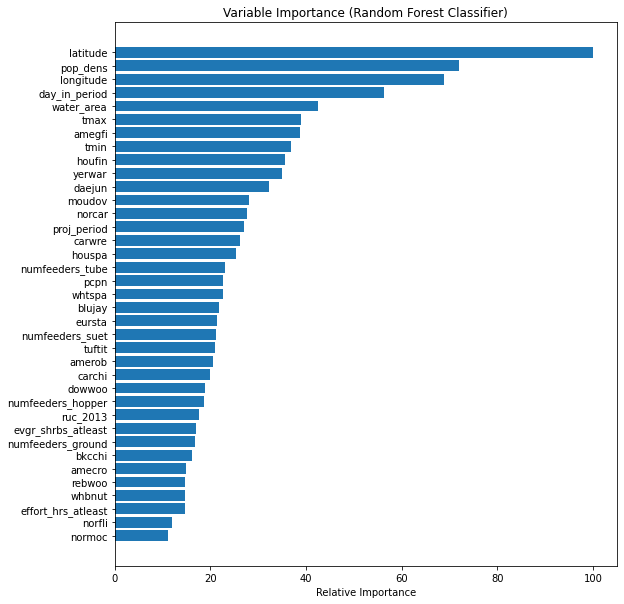

In [ ]:
plt.figure(figsize = (9,10))

plot_feat_imp(rfc, 'Random Forest Classifier', 37, X)

plt.show()

To simplify the model further, combine all numfeeders features with a sum.  Then drop the original features.

In [ ]:
pfdata['numfeeders']= pfdata[list(pfdata.filter(regex='numfeeders_'))].sum(axis=1)
pfdata = pfdata.drop(columns = list(pfdata.filter(regex='numfeeders_')))

Save the final prepped dataset to a csv.

In [ ]:
pfdata.to_csv(fdir + "final_prepped_data.csv")

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
y = pfdata['easblu_gr']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(182881, 34)

In [ ]:
start_time = time.clock()

rfc = ensemble.RandomForestClassifier(n_estimators=900, min_samples_leaf=1, min_samples_split=2, random_state=445, n_jobs=8)
rfc.fit(X_train, y_train)

cv_scores = cross_val_score(rfc, X_train, y_train, cv=4)
print('Accuracy scores for the folds: ', cv_scores)
print('Mean cross-validation score: {:.3f}'.format(np.mean(cv_scores)))
print('\n')

run_time = time.clock() - start_time
print('Run time: {:.3f}'.format(run_time))

Accuracy scores for the folds:  [0.85353784 0.85129593 0.85104987 0.85361986]
Mean cross-validation score: 0.852


Run time: 506.642


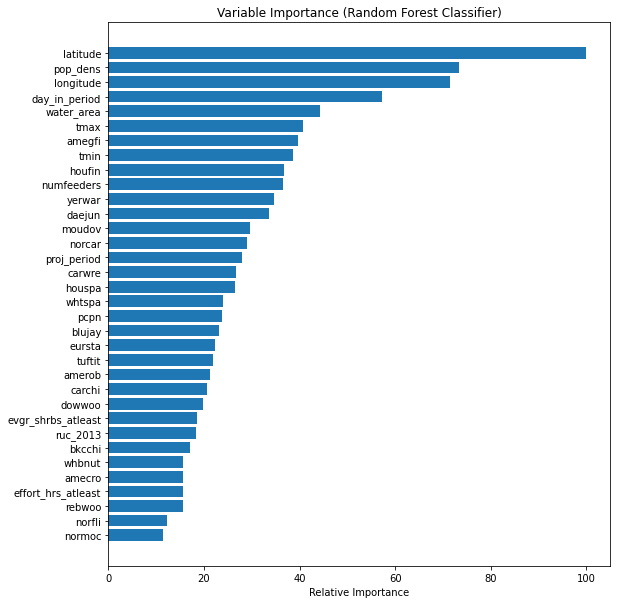

In [ ]:
plt.figure(figsize = (9,10))

plot_feat_imp(rfc, 'Random Forest Classifier', 34, X)

plt.show()

In [ ]:
X.columns

Index(['latitude', 'longitude', 'effort_hrs_atleast', 'amecro', 'amegfi',
       'amerob', 'bkcchi', 'blujay', 'carchi', 'carwre', 'daejun', 'dowwoo',
       'eursta', 'houfin', 'houspa', 'moudov', 'norcar', 'norfli', 'normoc',
       'rebwoo', 'tuftit', 'whbnut', 'whtspa', 'yerwar', 'evgr_shrbs_atleast',
       'ruc_2013', 'water_area', 'tmin', 'tmax', 'pcpn', 'pop_dens',
       'day_in_period', 'proj_period', 'numfeeders'],
      dtype='object')

###Random Forest Classifier with Grid Search

An attempt will now be made to improve the performance of the random forest classifier by tuning the hyperparameters using grid search.

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'week']

y = pfdata['easblu_gr']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(182881, 34)

In [ ]:
# Number of trees (def=100)
n_estimators = [300, 600, 900]

# Min number of samples required to split a node (def=2)
min_samples_split = [2, 3, 4]

# Min number of samples required at each leaf node (def=1)
min_samples_leaf = [1, 2]

# Number of folds
cv = 4

In [ ]:
params = {'n_estimators' : n_estimators,
          'min_samples_split' : min_samples_split,
          'min_samples_leaf' : min_samples_leaf}

scorers = {'precision_score': make_scorer(precision_score),
           'recall_score': make_scorer(recall_score),
           'accuracy_score': make_scorer(accuracy_score)}

In [ ]:
rfg = rf_grid_search(refit_score='accuracy_score')

Fitting 4 folds for each of 18 candidates, totalling 72 fits


In [ ]:
# Save the model
joblib.dump(rfg, fdir + "models/rf_grid_search.joblib")
print("Model saved")

Model saved


In [ ]:
# Load the model
rfg = joblib.load(fdir + "models/rf_grid_search.joblib")
print("Model loaded")

Model loaded


In [ ]:
print('Best parameters: {}'.format(rfg.best_params_))
print('\n')

# For the best set of parameters, get the scores on the folds
cv_scores = [rfg.cv_results_['split'+str(ii)+'_test_accuracy_score'][rfg.best_index_] for ii in np.arange(0, cv)]
print('Accuracy scores for the best set of folds: {}'.format(list(np.around(np.array(cv_scores),3))))
print('Mean cross-validation score for the best set of folds: {:.3f}'.format(rfg.best_score_))

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}


Accuracy scores for the best set of folds: [0.854, 0.851, 0.851, 0.854]
Mean cross-validation score for the best set of folds: 0.852


Grid search chose the same parameters that were used in the last random forest classifier.

In [ ]:
rf_results = pd.DataFrame(rfg.cv_results_).sort_values(by='rank_test_accuracy_score')

As shown in the results below, the model accuracy is nearly unchanged going from 300 trees to 900 trees.  Increasing the number of trees any further would not do much, except increase the run time.

In [ ]:
cols = list(rf_results.filter(regex='param_')) + list(rf_results.filter(regex='mean_test_accuracy')) \
        + list(rf_results.filter(regex='rank_test_accuracy')) + ['mean_fit_time', 'std_test_accuracy_score']
results_acc = rf_results.loc[:, rf_results.columns.isin(cols)]
results_acc.head(10)

mean_fit_time param_min_samples_leaf param_min_samples_split  \
2     305.6885343                      1                       2   
5     320.6764973                      1                       3   
1     201.7260686                      1                       2   
4     205.1684132                      1                       3   
3     101.5674213                      1                       3   
8     323.9283024                      1                       4   
7     202.7076035                      1                       4   
0     101.1150704                      1                       2   
6      99.3347269                      1                       4   
11    317.5426314                      2                       2   

   param_n_estimators  mean_test_accuracy_score  std_test_accuracy_score  \
2                 900                 0.8523759                0.0012065   
5                 900                 0.8521913                0.0011125   
1                 600                 0.8519726                0.0009240   
4                 600                 0.8519111                0.0011838   
3                 300                 0.8517402                0.0011273   
8                 900                 0.8516377                0.0004630   
7                 600                 0.8512276                0.0005941   
0                 300                 0.8509884                0.0010300   
6                 300                 0.8506261                0.0009632   
11                900                 0.8493548                0.0010299   

    rank_test_accuracy_score  
2                          1  
5                          2  
1                          3  
4                          4  
3                          5  
8                          6  
7                          7  
0                          8  
6                          9  
11                        10

Precision score vs. parameters:

In [ ]:
cols = list(rf_results.filter(regex='param_')) + list(rf_results.filter(regex='mean_test_precision')) \
        + list(rf_results.filter(regex='rank_test_precision')) + ['mean_fit_time', 'std_test_precision_score']
results_prec = rf_results.loc[:, rf_results.columns.isin(cols)]
results_prec.head(10)

mean_fit_time param_min_samples_leaf param_min_samples_split  \
2     305.6885343                      1                       2   
5     320.6764973                      1                       3   
1     201.7260686                      1                       2   
4     205.1684132                      1                       3   
3     101.5674213                      1                       3   
8     323.9283024                      1                       4   
7     202.7076035                      1                       4   
0     101.1150704                      1                       2   
6      99.3347269                      1                       4   
11    317.5426314                      2                       2   

   param_n_estimators  mean_test_precision_score  std_test_precision_score  \
2                 900                  0.8446809                 0.0037106   
5                 900                  0.8445969                 0.0030982   
1                 600                  0.8447530                 0.0022414   
4                 600                  0.8438134                 0.0027541   
3                 300                  0.8425760                 0.0028073   
8                 900                  0.8454796                 0.0022156   
7                 600                  0.8441776                 0.0025114   
0                 300                  0.8431378                 0.0030325   
6                 300                  0.8419292                 0.0027583   
11                900                  0.8439853                 0.0034100   

    rank_test_precision_score  
2                           3  
5                           4  
1                           2  
4                          15  
3                          17  
8                           1  
7                          11  
0                          16  
6                          18  
11                         12

Recall score vs. parameters:

In [ ]:
cols = list(rf_results.filter(regex='param_')) + list(rf_results.filter(regex='mean_test_recall')) \
        + list(rf_results.filter(regex='rank_test_recall')) + ['mean_fit_time', 'std_test_recall_score']
results_rec = rf_results.loc[:, rf_results.columns.isin(cols)]
results_rec.head(10)

mean_fit_time param_min_samples_leaf param_min_samples_split  \
2     305.6885343                      1                       2   
5     320.6764973                      1                       3   
1     201.7260686                      1                       2   
4     205.1684132                      1                       3   
3     101.5674213                      1                       3   
8     323.9283024                      1                       4   
7     202.7076035                      1                       4   
0     101.1150704                      1                       2   
6      99.3347269                      1                       4   
11    317.5426314                      2                       2   

   param_n_estimators  mean_test_recall_score  std_test_recall_score  \
2                 900               0.5546742              0.0031060   
5                 900               0.5539140              0.0034422   
1                 600               0.5527737              0.0039589   
4                 600               0.5533819              0.0038408   
3                 300               0.5537873              0.0034108   
8                 900               0.5505689              0.0023902   
7                 600               0.5499354              0.0022190   
0                 300               0.5498340              0.0038919   
6                 300               0.5493271              0.0030452   
11                900               0.5415981              0.0028014   

    rank_test_recall_score  
2                        1  
5                        2  
1                        5  
4                        4  
3                        3  
8                        6  
7                        7  
0                        8  
6                        9  
11                      10

In [ ]:
y_preds_test = rfg.predict(X_test)

In [ ]:
# Get the test set results
accuracy = accuracy_score(y_test, y_preds_test)
precision = precision_score(y_test, y_preds_test)
recall = recall_score(y_test, y_preds_test)
f1 = f1_score(y_test, y_preds_test)
fbeta_precision = fbeta_score(y_test, y_preds_test, beta = 0.5)
fbeta_recall = fbeta_score(y_test, y_preds_test, beta = 2.0)

print('Test set results:')
print('Accuracy score: {:.3f}'.format(accuracy))
print('Precision score: {:.3f}'.format(precision))
print('Recall score: {:.3f}'.format(recall))
print('F1 score: {:.3f}'.format(f1))
print('Fbeta score favoring precision: {:.3f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.3f}'.format(fbeta_recall))
print('\n')

Test set results:
Accuracy score: 0.859
Precision score: 0.848
Recall score: 0.582
F1 score: 0.691
Fbeta score favoring precision: 0.777
FBeta score favoring recall: 0.621




Print a classification report.

In [ ]:
report = classification_report(y_test, y_preds_test, target_names=['Positive', 'Negative'])
print(report)

              precision    recall  f1-score   support

    Positive       0.86      0.96      0.91     26711
    Negative       0.85      0.58      0.69      9866

    accuracy                           0.86     36577
   macro avg       0.86      0.77      0.80     36577
weighted avg       0.86      0.86      0.85     36577



Plot a confusion matrix.

In [ ]:
X_test.shape

(36577, 34)

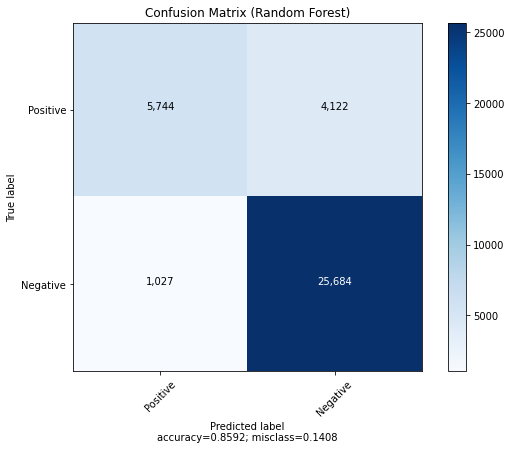

In [ ]:
confusion = confusion_matrix(y_test, y_preds_test, labels=[1, 0])
plot_confusion_matrix(cm=confusion, target_names = ['Positive', 'Negative'], title = "Confusion Matrix (Random Forest)", normalize=False)

The recall score is low due to the relatively high number of false negatives.  Otherwise, the accuracy is reasonable at 0.859.

Plot the ROC curve and AUC.  Calculate AUC.

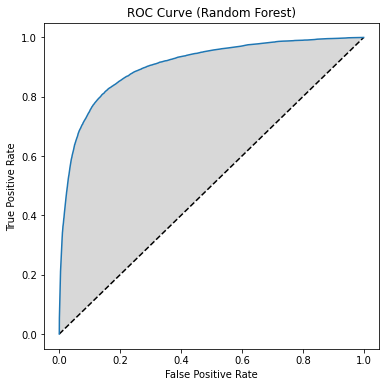

In [ ]:
rfg_probs = rfg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfg_probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()

In [ ]:
auc = roc_auc_score(y_test, rfg_probs)
print("ROCAUC: {:.3f}".format(auc))

ROCAUC: 0.906


###Gradient Boosting Classifier with Grid Search

Next, evaluate a gradient boosting classifier, tuning the hyperparameters with grid search.

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'week']

y = pfdata['easblu_gr']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(182881, 34)

In [ ]:
# Note that for the numeric parameters, wider ranges were first tested,
# before narrowing in on the following ranges

# Loss function to be optimized (def=deviance)
loss = ['deviance']

# Shrinking the contribution of each tree by learning_rate (def=0.1)
learning_rate = [0.1, 0.2, 0.3]

# Number of boosting stages to perform (def=100)
n_estimators = [900]

# Fraction of samples to be used for fitting the individual base learners (def=1)
subsample = [0.8, 0.9, 1.0]

# Minimum number of samples required to split an internal node (def=2)
min_samples_split = [2, 3]

# Maximum depth of the individual regression estimators (def=3)
max_depth = [11, 12, 13]

# Number of folds
cv = 4

In [ ]:
params = {'loss' : loss,
          'learning_rate' : learning_rate,
          'n_estimators' : n_estimators,
          'subsample' : subsample,
          'min_samples_split' : min_samples_split,
          'max_depth' : max_depth}

scorers = {'precision_score': make_scorer(precision_score),
           'recall_score': make_scorer(recall_score),
           'accuracy_score': make_scorer(accuracy_score)}

In [ ]:
gbg = gb_grid_search(refit_score='accuracy_score')

Fitting 4 folds for each of 54 candidates, totalling 216 fits


In [ ]:
# Save the model
joblib.dump(gbg, fdir + "models/gb_grid_search.joblib")
print("Model saved")

Model saved


In [ ]:
# Load the model
gbg = joblib.load(fdir + "models/gb_grid_search.joblib")
print("Model loaded")

Model loaded


In [ ]:
print('Best parameters: {}'.format(gbg.best_params_))
print('\n')

# For the best set of parameters, get the scores on the folds
cv_scores = [gbg.cv_results_['split'+str(ii)+'_test_accuracy_score'][gbg.best_index_] for ii in np.arange(0, cv)]
print('Accuracy scores for the best set of folds: {}'.format(list(np.around(np.array(cv_scores),3))))
print('Mean cross-validation score for the best set of folds: {:.3f}'.format(gbg.best_score_))

Best parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 11, 'min_samples_split': 3, 'n_estimators': 900, 'subsample': 0.9}


Accuracy scores for the best set of folds: [0.876, 0.875, 0.875, 0.875]
Mean cross-validation score for the best set of folds: 0.875


This is an improvement over the random forest classifier.

In [ ]:
gb_results = pd.DataFrame(gbg.cv_results_).sort_values(by='rank_test_accuracy_score')

Accuracy score vs. parameters:

In [ ]:
cols = list(gb_results.filter(regex='param_')) + list(gb_results.filter(regex='mean_test_accuracy')) \
        + list(gb_results.filter(regex='rank_test_accuracy')) + ['mean_fit_time', 'std_test_accuracy_score']
results_acc = gb_results.loc[:, gb_results.columns.isin(cols)]
results_acc.head(10)

mean_fit_time param_learning_rate param_loss param_max_depth  \
4    1579.5142376                 0.1   deviance              11   
1    1590.7317033                 0.1   deviance              11   
16   1927.2360783                 0.1   deviance              13   
35   1821.8307642                 0.2   deviance              13   
25   1683.6335173                 0.2   deviance              12   
28   1649.4674492                 0.2   deviance              12   
10   1707.9792320                 0.1   deviance              12   
43   1514.5166844                 0.3   deviance              12   
44   1637.1449859                 0.3   deviance              12   
2    1720.2682772                 0.1   deviance              11   

   param_min_samples_split param_n_estimators param_subsample  \
4                        3                900             0.9   
1                        2                900             0.9   
16                       3                900             0.9   
35                       3                900             1.0   
25                       2                900             0.9   
28                       3                900             0.9   
10                       3                900             0.9   
43                       2                900             0.9   
44                       2                900             1.0   
2                        2                900             1.0   

    mean_test_accuracy_score  std_test_accuracy_score  \
4                  0.8750684                0.0003974   
1                  0.8748633                0.0013853   
16                 0.8746172                0.0007562   
35                 0.8745899                0.0010456   
25                 0.8745215                0.0009456   
28                 0.8745215                0.0011628   
10                 0.8744874                0.0009822   
43                 0.8744805                0.0012380   
44                 0.8744737                0.0009000   
2                  0.8744190                0.0006551   

    rank_test_accuracy_score  
4                          1  
1                          2  
16                         3  
35                         4  
25                         5  
28                         6  
10                         7  
43                         8  
44                         9  
2                         10

Precision score vs. parameters:

In [ ]:
cols = list(gb_results.filter(regex='param_')) + list(gb_results.filter(regex='mean_test_precision')) \
        + list(gb_results.filter(regex='rank_test_precision')) + ['mean_fit_time', 'std_test_precision_score']
results_prec = gb_results.loc[:, gb_results.columns.isin(cols)]
results_prec.head(10)

mean_fit_time param_learning_rate param_loss param_max_depth  \
4    1579.5142376                 0.1   deviance              11   
1    1590.7317033                 0.1   deviance              11   
16   1927.2360783                 0.1   deviance              13   
35   1821.8307642                 0.2   deviance              13   
25   1683.6335173                 0.2   deviance              12   
28   1649.4674492                 0.2   deviance              12   
10   1707.9792320                 0.1   deviance              12   
43   1514.5166844                 0.3   deviance              12   
44   1637.1449859                 0.3   deviance              12   
2    1720.2682772                 0.1   deviance              11   

   param_min_samples_split param_n_estimators param_subsample  \
4                        3                900             0.9   
1                        2                900             0.9   
16                       3                900             0.9   
35                       3                900             1.0   
25                       2                900             0.9   
28                       3                900             0.9   
10                       3                900             0.9   
43                       2                900             0.9   
44                       2                900             1.0   
2                        2                900             1.0   

    mean_test_precision_score  std_test_precision_score  \
4                   0.8280463                 0.0012081   
1                   0.8267244                 0.0026941   
16                  0.8348262                 0.0024001   
35                  0.8310776                 0.0017829   
25                  0.8295677                 0.0028492   
28                  0.8277733                 0.0015938   
10                  0.8302139                 0.0020709   
43                  0.8260422                 0.0021485   
44                  0.8256356                 0.0007285   
2                   0.8259360                 0.0009764   

    rank_test_precision_score  
4                          24  
1                          28  
16                          2  
35                         11  
25                         16  
28                         25  
10                         15  
43                         33  
44                         36  
2                          34

Recall score vs. parameters:

In [ ]:
cols = list(gb_results.filter(regex='param_')) + list(gb_results.filter(regex='mean_test_recall')) \
        + list(gb_results.filter(regex='rank_test_recall')) + ['mean_fit_time', 'std_test_recall_score']
results_rec = gb_results.loc[:, gb_results.columns.isin(cols)]
results_rec.head(10)

mean_fit_time param_learning_rate param_loss param_max_depth  \
4    1579.5142376                 0.1   deviance              11   
1    1590.7317033                 0.1   deviance              11   
16   1927.2360783                 0.1   deviance              13   
35   1821.8307642                 0.2   deviance              13   
25   1683.6335173                 0.2   deviance              12   
28   1649.4674492                 0.2   deviance              12   
10   1707.9792320                 0.1   deviance              12   
43   1514.5166844                 0.3   deviance              12   
44   1637.1449859                 0.3   deviance              12   
2    1720.2682772                 0.1   deviance              11   

   param_min_samples_split param_n_estimators param_subsample  \
4                        3                900             0.9   
1                        2                900             0.9   
16                       3                900             0.9   
35                       3                900             1.0   
25                       2                900             0.9   
28                       3                900             0.9   
10                       3                900             0.9   
43                       2                900             0.9   
44                       2                900             1.0   
2                        2                900             1.0   

    mean_test_recall_score  std_test_recall_score  rank_test_recall_score  
4                0.6775043              0.0022638                      15  
1                0.6781885              0.0032620                      11  
16               0.6671397              0.0023370                      47  
35               0.6715237              0.0028664                      34  
25               0.6730695              0.0022487                      26  
28               0.6752743              0.0035880                      23  
10               0.6721066              0.0026130                      32  
43               0.6772509              0.0037828                      16  
44               0.6777324              0.0039008                      13  
2                0.6770989              0.0027289                      18

In [ ]:
y_preds_test = gbg.predict(X_test)

In [ ]:
# Get the test set results
accuracy = accuracy_score(y_test, y_preds_test)
precision = precision_score(y_test, y_preds_test)
recall = recall_score(y_test, y_preds_test)
f1 = f1_score(y_test, y_preds_test)
fbeta_precision = fbeta_score(y_test, y_preds_test, beta = 0.5)
fbeta_recall = fbeta_score(y_test, y_preds_test, beta = 2.0)

print('Test set results:')
print('Accuracy score: {:.3f}'.format(accuracy))
print('Precision score: {:.3f}'.format(precision))
print('Recall score: {:.3f}'.format(recall))
print('F1 score: {:.3f}'.format(f1))
print('Fbeta score favoring precision: {:.3f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.3f}'.format(fbeta_recall))
print('\n')

Test set results:
Accuracy score: 0.878
Precision score: 0.828
Recall score: 0.693
F1 score: 0.754
Fbeta score favoring precision: 0.797
FBeta score favoring recall: 0.716




Print a classification report.

In [ ]:
report = classification_report(y_test, y_preds_test, target_names=['Positive', 'Negative'])
print(report)

              precision    recall  f1-score   support

    Positive       0.89      0.95      0.92     26711
    Negative       0.83      0.69      0.75      9866

    accuracy                           0.88     36577
   macro avg       0.86      0.82      0.84     36577
weighted avg       0.88      0.88      0.87     36577



Plot a confusion matrix.

In [ ]:
X_test.shape

(36577, 34)

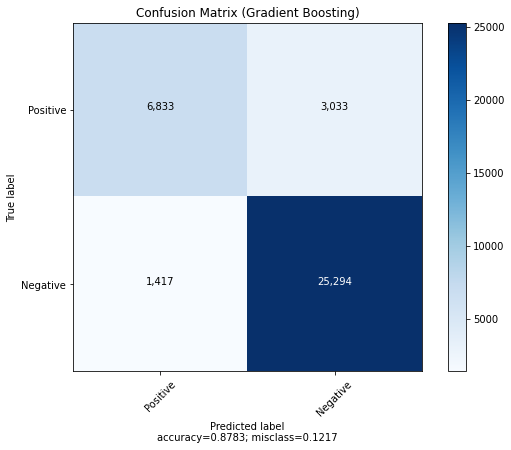

In [ ]:
confusion = confusion_matrix(y_test, y_preds_test, labels=[1, 0])
plot_confusion_matrix(cm=confusion, target_names = ['Positive', 'Negative'], title = "Confusion Matrix (Gradient Boosting)", normalize=False)

Overall, this gradient boosting classifier is a higher performer than the random forest.  Accuracy and recall scores have increased at the small cost of a slight decrease in precision score. 

Plot the ROC curve and AUC.  Calculate AUC.

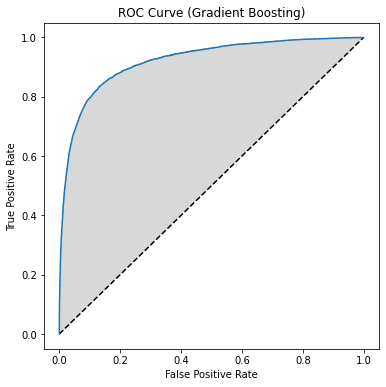

In [ ]:
gbg_probs = gbg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, gbg_probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Gradient Boosting)")
plt.show()

In [ ]:
auc = roc_auc_score(y_test, gbg_probs)
print("ROCAUC: {:.3f}".format(auc))

ROCAUC: 0.921


###ANN

Finally, evaluate an artificial neural network (ANN).

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'week']

y = pfdata['easblu_gr']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(182881, 34)

In [ ]:
# Standardize for ANN
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.fit_transform(X_test)

In [ ]:
# Function to create a list of numbers
# where list[n] = list[n - 1] / 2

def halves(init, length):
    
    init = init
    length = length
    ll = list(np.arange(1, length+1, 1))
    for idx, val in enumerate(ll):
        if idx == 0:
            ll[idx] = init
        else:
            ll[idx] = ll[idx-1] // 2

    return ll

The following sections tune an ANN model based on activation function, neuron and layer count, batch size, and learning rate. 

In [ ]:
vary = 'activ_func'
var_list = ['relu', 'tanh', 'sigmoid']

params = {'neuron_counts' : halves(512, 4),
          vary : var_list,
          'optimizer_learn_rate' : 0.01,
          'batch_size' : 300,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_01 = pd.concat(df_list, ignore_index=True)
results_df_01.sort_values('train_accuracy', ascending=False, ignore_index=True)

neuron_counts activ_func optimizer_learn_rate batch_size nb_epoch  \
0  [512, 256, 128, 64]       relu                 0.01        300       20   
1  [512, 256, 128, 64]       tanh                 0.01        300       20   
2  [512, 256, 128, 64]    sigmoid                 0.01        300       20   

  train_accuracy test_accuracy train_test_diff  precision     recall  \
0      0.8024729     0.7970309        0.005442  0.7058328  0.4243868   
1      0.7933959     0.7940236      -0.0006276  0.7029944  0.4092844   
2      0.7302808     0.7302676       0.0000131        0.0        0.0   

          f1 fbeta_precision fbeta_recall    run_time  
0  0.5300671       0.6231768     0.461164  25.4812364  
1  0.5173607       0.6147616    0.4466024  25.4831242  
2        0.0             0.0          0.0  25.3185304

In [ ]:
# Choose
activ_func = 'relu'

In [ ]:
vary = 'batch_size'
var_list = [250, 300, 350, 400]

params = {'neuron_counts' : halves(512, 4),
          'activ_func' : activ_func,
          'optimizer_learn_rate' : 0.01,
          vary : var_list,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_02 = pd.concat(df_list, ignore_index=True)
results_df_02.sort_values('train_accuracy', ascending=False, ignore_index=True)

neuron_counts activ_func optimizer_learn_rate batch_size nb_epoch  \
0  [512, 256, 128, 64]       relu                 0.01        250       20   
1  [512, 256, 128, 64]       relu                 0.01        300       20   
2  [512, 256, 128, 64]       relu                 0.01        400       20   
3  [512, 256, 128, 64]       relu                 0.01        350       20   

  train_accuracy test_accuracy train_test_diff  precision     recall  \
0      0.8065398     0.8003117       0.0062281  0.6869527   0.477093   
1      0.8018509     0.7970583       0.0047926  0.7153182  0.4113116   
2      0.7978182      0.797195       0.0006233    0.68523  0.4589499   
3      0.7945237     0.7914263       0.0030974  0.6306812  0.5471316   

          f1 fbeta_precision fbeta_recall    run_time  
0  0.5631056       0.6314053    0.5081397  30.3255714  
1  0.5222987       0.6231955    0.4495203  25.3607771  
2  0.5497147       0.6237258    0.4914048  19.1587003  
3   0.585943       0.6119904    0.5620224   22.473982

Here, the batch size of 250 results in a higher train and test accuracy, but the batch size of 300 will be chosen due to its lesser tendency to overfit (train vs. test).

In [ ]:
# Choose
batch_size = 300

In [ ]:
vary = 'optimizer_learn_rate'
var_list = [0.006, 0.008, 0.01, 0.012]

params = {'neuron_counts' : halves(512, 4),
          'activ_func' : activ_func,
          vary : var_list,
          'batch_size' : batch_size,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_03 = pd.concat(df_list, ignore_index=True)
results_df_03.sort_values('train_accuracy', ascending=False, ignore_index=True)

neuron_counts activ_func optimizer_learn_rate batch_size nb_epoch  \
0  [512, 256, 128, 64]       relu                0.012        300       20   
1  [512, 256, 128, 64]       relu                 0.01        300       20   
2  [512, 256, 128, 64]       relu                0.008        300       20   
3  [512, 256, 128, 64]       relu                0.006        300       20   

  train_accuracy test_accuracy train_test_diff  precision     recall  \
0      0.8074831     0.8001203       0.0073628  0.6800056  0.4891547   
1      0.8044688     0.7993548        0.005114  0.6953765  0.4558078   
2      0.8019124     0.7974136       0.0044988  0.6845506  0.4616866   
3      0.7954054     0.7931761       0.0022294  0.6895699  0.4241841   

          f1 fbeta_precision fbeta_recall    run_time  
0  0.5690031       0.6307837    0.5182449  26.1403204  
1  0.5506643       0.6292327    0.4895387  25.3590809  
2  0.5514528       0.6242805    0.4938419  25.4525855  
3  0.5252589       0.6128815    0.4595568  25.3371195

As before, the slightly less accurate case is chosen here (optimizer_learn_rate = 0.01) due to its lesser tendency to overfit.

In [ ]:
# Choose
optimizer_learn_rate = 0.01

In [ ]:
vary = 'neuron_counts'
var_list = [halves(512, 6), halves(512, 5), halves(512, 4),
            halves(256, 5), halves(256, 4)]

params = {vary : var_list,
          'activ_func' : activ_func,
          'optimizer_learn_rate' : optimizer_learn_rate,
          'batch_size' : batch_size,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_04 = pd.concat(df_list, ignore_index=True)
results_df_04.sort_values('train_accuracy', ascending=False, ignore_index=True)

neuron_counts activ_func optimizer_learn_rate batch_size  \
0  [512, 256, 128, 64, 32, 16]       relu                 0.01        300   
1      [512, 256, 128, 64, 32]       relu                 0.01        300   
2          [512, 256, 128, 64]       relu                 0.01        300   
3       [256, 128, 64, 32, 16]       relu                 0.01        300   
4           [256, 128, 64, 32]       relu                 0.01        300   

  nb_epoch train_accuracy test_accuracy train_test_diff  precision     recall  \
0       20      0.8108801     0.8022528       0.0086273  0.6715757  0.5222988   
1       20      0.8084468     0.8009132       0.0075337  0.7197279  0.4289479   
2       20      0.8036486      0.798808       0.0048406   0.694311  0.4539834   
3       20      0.8005181     0.7970309       0.0034872  0.7148135  0.4118184   
4       20      0.7998073     0.7970309       0.0027763  0.6964918  0.4386783   

          f1 fbeta_precision fbeta_recall    run_time  
0  0.5876048       0.6352631    0.5465982  27.9053444  
1  0.5375333       0.6337986    0.4666549  26.3835886  
2   0.548998       0.6278385    0.4877491  25.5156961  
3  0.5225723       0.6231213    0.4499646  26.2656974  
4  0.5383085        0.623236     0.473751  25.3625691

As before, the slightly less accurate case is chosen here (neuron_counts = [512, 256, 128, 64]) due to its lesser tendency to overfit.

In [ ]:
# Choose
neuron_counts = halves(512, 4)

In [ ]:
params = {'neuron_counts' : neuron_counts,
          'activ_func' : activ_func,
          'optimizer_learn_rate' : optimizer_learn_rate,
          'batch_size' : batch_size,
          'nb_epoch' : 20}

In [ ]:
model = Sequential()
model.add(Dense(params['neuron_counts'][0], input_shape=(X_train.shape[1],), activation=params['activ_func']))

for i in np.arange(1, len(params['neuron_counts'])):
    model.add(Dense(params['neuron_counts'][i], activation=params['activ_func']))

# Set the output layer as model.add(Dense(1, activation='sigmoid')) for binary classifier
model.add(Dense(1, activation='sigmoid'))

if params['optimizer_learn_rate'] == 'sgd':
    optimizer_learn_rate = params['optimizer_learn_rate']
else:
    optimizer_learn_rate = optimizers.SGD(lr=params['optimizer_learn_rate'])

start = timeit.default_timer()

#Set to loss='binary_crossentropy' for binary classifier
model.compile(optimizer=optimizer_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['nb_epoch'], verbose=0)

stop = timeit.default_timer()

run_time = stop - start

y_preds_test_prob = model.predict(X_test)
# The model outputs probabilities.
# For plotting the confusion matrix, change the output back to binary based on a decision threshold of 0.5
y_preds_test = (y_preds_test_prob > 0.5)

score_train = model.evaluate(X_train, y_train, verbose=0)
score_test = model.evaluate(X_test, y_test, verbose=0)
train_test_diff = score_train[1] - score_test[1]
precision = precision_score(y_test, y_preds_test)
recall = recall_score(y_test, y_preds_test)
f1 = f1_score(y_test, y_preds_test)
fbeta_precision = fbeta_score(y_test, y_preds_test, beta = 0.5)
fbeta_recall = fbeta_score(y_test, y_preds_test, beta = 2.0)

cols = ['neuron_counts', 'activ_func', 'optimizer_learn_rate', 'batch_size', 'nb_epoch', 'train_accuracy',
        'test_accuracy', 'train_test_diff', 'precision', 'recall', 'f1', 'fbeta_precision', 'fbeta_recall', 'run_time']

results_df = pd.DataFrame(columns=cols)

results_list = [params['neuron_counts'], params['activ_func'], params['optimizer_learn_rate'], params['batch_size'], params['nb_epoch'],
                score_train[1], score_test[1], train_test_diff, precision, recall, f1, fbeta_precision, fbeta_recall, run_time]

for idx, val in enumerate(results_list):
    results_df.loc[0, cols[idx]] = val

In [ ]:
results_df

neuron_counts activ_func optimizer_learn_rate batch_size nb_epoch  \
0  [512, 256, 128, 64]       relu                 0.01        300       20   

  train_accuracy test_accuracy train_test_diff  precision     recall  \
0      0.7651602     0.7636219       0.0015383  0.7351581  0.1932901   

          f1 fbeta_precision fbeta_recall    run_time  
0  0.3060995       0.4710503    0.2267107  23.5477921

Wite the ANN results to a csv.

In [ ]:
ann_results = results_df_04.sort_values('train_accuracy', ascending=False, ignore_index=True)

ann_results.to_csv(fdir + "models/ann_results.csv")

Plot the ROC curve and AUC.  Calculate AUC.

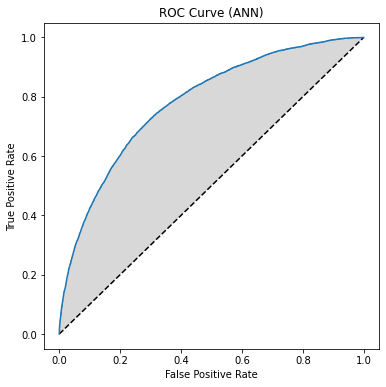

In [ ]:
ann_probs = y_preds_test_prob.reshape(1,-1)[0]
fpr, tpr, thresholds = roc_curve(y_test, ann_probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ANN)")
plt.show()

In [ ]:
auc = roc_auc_score(y_test, ann_probs)
print("ROCAUC: {:.3f}".format(auc))

ROCAUC: 0.781


###Comparison of Classification Models

In [ ]:
ann_results = pd.read_csv(fdir + "models/ann_results.csv")
ann_results = ann_results.drop(columns = 'Unnamed: 0')

ANN:

In [ ]:
ann_results.loc[:, ~ann_results.columns.isin(['fbeta_precision', 'fbeta_recall'])]

neuron_counts activ_func  optimizer_learn_rate  batch_size  \
0  [512, 256, 128, 64, 32, 16]       relu                  0.01         300   
1      [512, 256, 128, 64, 32]       relu                  0.01         300   
2          [512, 256, 128, 64]       relu                  0.01         300   
3       [256, 128, 64, 32, 16]       relu                  0.01         300   
4           [256, 128, 64, 32]       relu                  0.01         300   

   nb_epoch  train_accuracy  test_accuracy  train_test_diff  precision  \
0        20       0.8108801      0.8022528        0.0086273  0.6715757   
1        20       0.8084468      0.8009132        0.0075337  0.7197279   
2        20       0.8036486      0.7988080        0.0048406  0.6943110   
3        20       0.8005181      0.7970309        0.0034872  0.7148135   
4        20       0.7998073      0.7970309        0.0027763  0.6964918   

      recall         f1    run_time  
0  0.5222988  0.5876048  27.9053444  
1  0.4289479  0.5375333  26.3835886  
2  0.4539834  0.5489980  25.5156961  
3  0.4118184  0.5225723  26.2656974  
4  0.4386783  0.5383085  25.3625691

Random Forest:

In [ ]:
# Load the random forest model
rfg = joblib.load(fdir + "models/rf_grid_search.joblib")
# Get key results
print('Random forest best parameters: {}'.format(rfg.best_params_))
rf_results = pd.DataFrame(rfg.cv_results_).sort_values(by='rank_test_accuracy_score')
rf_results[['mean_fit_time', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score']].head(1)

Random forest best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}


mean_fit_time  mean_test_accuracy_score  std_test_accuracy_score  \
2    305.6885343                 0.8523759                0.0012065   

   mean_test_precision_score  mean_test_recall_score  
2                  0.8446809               0.5546742

Gradient Boosting:

In [ ]:
# Load the gradient boosting model
gbg = joblib.load(fdir + "models/gb_grid_search.joblib")
# Get key results
print('Gradient boosting best parameters: {}'.format(gbg.best_params_))
gb_results = pd.DataFrame(gbg.cv_results_).sort_values(by='rank_test_accuracy_score')
gb_results[['mean_fit_time', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score']].head(1)

Gradient boosting best parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 11, 'min_samples_split': 3, 'n_estimators': 900, 'subsample': 0.9}


mean_fit_time  mean_test_accuracy_score  std_test_accuracy_score  \
4   1579.5142376                 0.8750684                0.0003974   

   mean_test_precision_score  mean_test_recall_score  
4                  0.8280463               0.6775043

*  The ANN with the highest accuracy performs worse than the random forest and gradient boosting models.  Moreover, it shows a tendency to overfit (train vs. test).
*  The other ANN models, having different neuron and layer counts, are more generalizable, but their overall accuracy is still poorer than the random forest and gradient boosting models.
*  Both the random forest and the gradient boosting models are very generalizable as seen by their low std_test_accuracy_score, which is the standard deviation of the accuracy scores over the folds from cross-validation.
*  The gradient boosting model has the highest accuracy score and the highest recall score, while its precision score is comparable to the random forest.  Therefore, the gradient boosting model is chosen as the best model to move forward.

Compare the ROCAUC of the models.

In [ ]:
rfg_probs = rfg.predict_proba(X_test)[:, 1]
gbg_probs = gbg.predict_proba(X_test)[:, 1]
ann_probs = y_preds_test_prob.reshape(1,-1)[0]

rfg_auc = roc_auc_score(y_test, rfg_probs)
gbg_auc = roc_auc_score(y_test, gbg_probs)
ann_auc = roc_auc_score(y_test, ann_probs)

print("ROCAUC (Random Forest): {:.3f}".format(rfg_auc))
print("ROCAUC (Gradient Boosting): {:.3f}".format(gbg_auc))
print("ROCAUC (ANN): {:.3f}".format(ann_auc))

ROCAUC (Random Forest): 0.906
ROCAUC (Gradient Boosting): 0.921
ROCAUC (ANN): 0.781


The gradient boosting model has the highest ROCAUC.

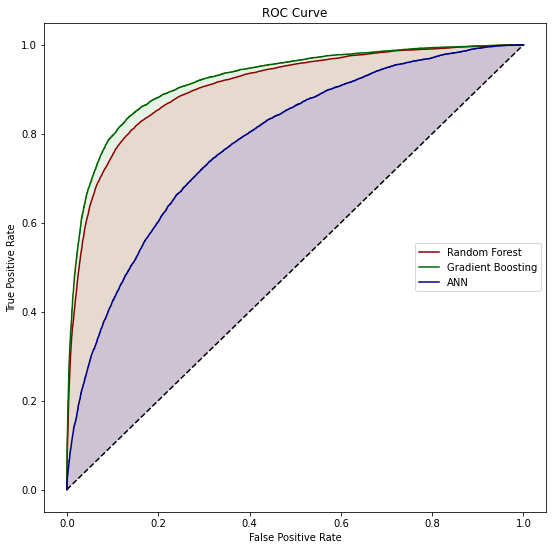

In [ ]:
fpr_rfg, tpr_rfg, thresholds = roc_curve(y_test, rfg_probs)
fpr_gbg, tpr_gbg, thresholds = roc_curve(y_test, gbg_probs)
fpr_ann, tpr_ann, thresholds = roc_curve(y_test, ann_probs)

fig = plt.figure(figsize = (9, 9))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_rfg, tpr_rfg, color='darkred', label="Random Forest")
plt.fill(fpr_rfg, tpr_rfg, 'red', alpha=0.1)

plt.plot(fpr_gbg, tpr_gbg, color='darkgreen', label="Gradient Boosting")
plt.fill(fpr_gbg, tpr_gbg, 'green', alpha=0.1)

plt.plot(fpr_ann, tpr_ann, color = 'darkblue', label="ANN")
plt.fill(fpr_ann, tpr_ann, 'blue', alpha=0.1)

plt.legend(loc="center right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

##Unsupervised Learning

###Prepare for Unsupervised Learning

Unsupervised learning will now be used to further explore the question:  What are the most influential factors affecting bluebird presence or absence, and what are the magnitudes of these factors that lead to a shift between presence and absence?  Specifically, the objective here is to investigate local variables by first stripping away variables such as latitude, longitude, and time.  In other words, what is characteristic about a site that influences the presence or absence of eastern bluebirds?

In [ ]:
# Load the data
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# Load the gradient boosting model
gbg = joblib.load(fdir + "models/gb_grid_search.joblib")
print("Model loaded")

Model loaded


Have another look at feature importance from the GBM.

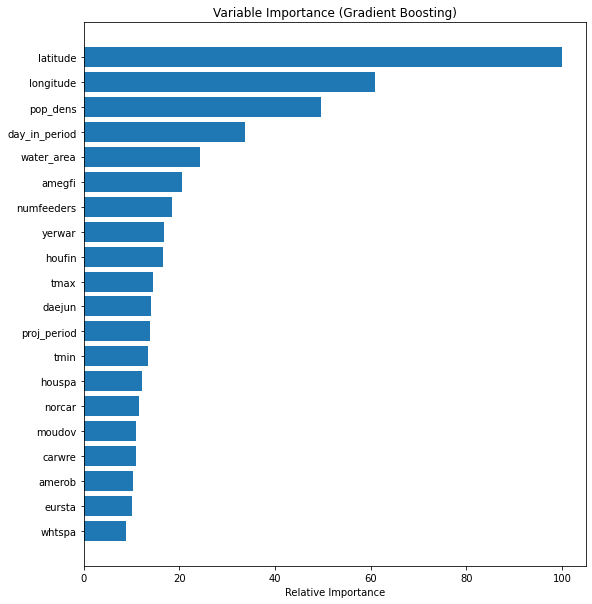

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'week']

X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

plt.figure(figsize = (9,10))

plot_feat_imp(gbg.best_estimator_, 'Gradient Boosting', 20, X)

plt.show()

Take the top features plus the target, easblu_gr, since the target will not be used as the ground truth here, and exclude latitude, longitude, proj_period, and day_in_period.

In [ ]:
get_top = 14
feature_importance = gbg.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-1*get_top:]
top_feat = X.columns[sorted_idx].tolist()
top_feat = [e for e in top_feat if e not in ('latitude', 'longitude', 'proj_period', 'day_in_period')]
unsup_feat = top_feat + ['easblu_gr']
unsup_feat

['houspa',
 'tmin',
 'daejun',
 'tmax',
 'houfin',
 'yerwar',
 'numfeeders',
 'amegfi',
 'water_area',
 'pop_dens',
 'easblu_gr']

For the unsupervised learning task, latitude, longitude, proj_period, and day_in_period are not included as variables.  However, safeguards must be taken to protect against bias that is related to location and time, since this task is focused on variables local to a site.

For location, the safeguard against bias is to subset the sites to a smaller latitude / longitude box, where the locations have a more uniform spatial distribution, and have a mix of rural and urban sites.

Below is the map of sites that were included in the gradient boosting model.

See that there is a relatively uniform distribution of sites in the lower half of New York and the northern part of Pennsylvania.

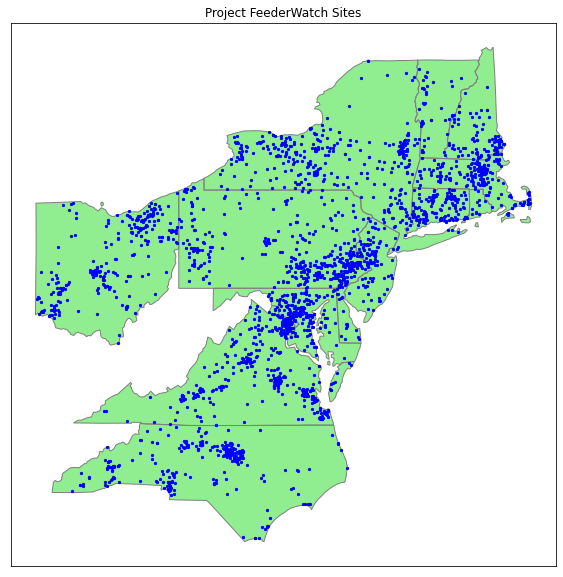

In [ ]:
long_lat = pfdata.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

plot_map(geo_df, (10,10), "Project FeederWatch Sites")

Subset the patch of sites in the lower half of New York and the northern part of Pennsylvania:

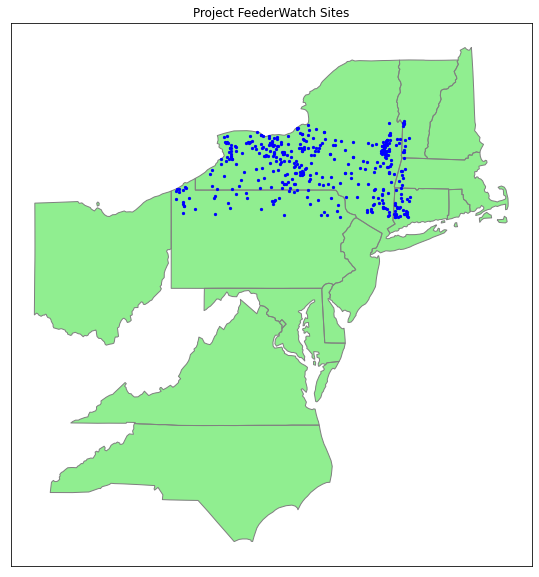

In [ ]:
min_lat = 41.36
max_lat = 43.65
min_lon = -80.52
max_lon = -73.00

cond_pos = (pfdata.latitude > min_lat) & (pfdata.latitude < max_lat) & \
            (pfdata.longitude > min_lon) & (pfdata.longitude < max_lon)

pfdata_sub = pfdata[cond_pos].reset_index()

long_lat_sub = pfdata_sub.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry_sub = [Point(xy) for xy in zip(long_lat_sub['longitude'], long_lat_sub['latitude'])]
geo_df_sub = gpd.GeoDataFrame(long_lat_sub, crs=crs, geometry=geometry_sub)

plot_map(geo_df_sub, (10,10), "Project FeederWatch Sites")

For time, the safeguard against bias is to select a range of time within a single project period where the proportion of checklists with a bluebird observation is fairly consistent. 

In [ ]:
pfdata_sub.groupby('proj_period_id')['index'].count()

proj_period_id
PFW_2016    4092
PFW_2017    4558
PFW_2018    4839
PFW_2019    4855
PFW_2020    5932
PFW_2021    5732
Name: index, dtype: int64

As shown in the bar plot below, PFW_2021 is chosen because weeks 10 through 16 have a fairly consistent proportion of checklists with a bluebird observation.

In [ ]:
period = periods[5]

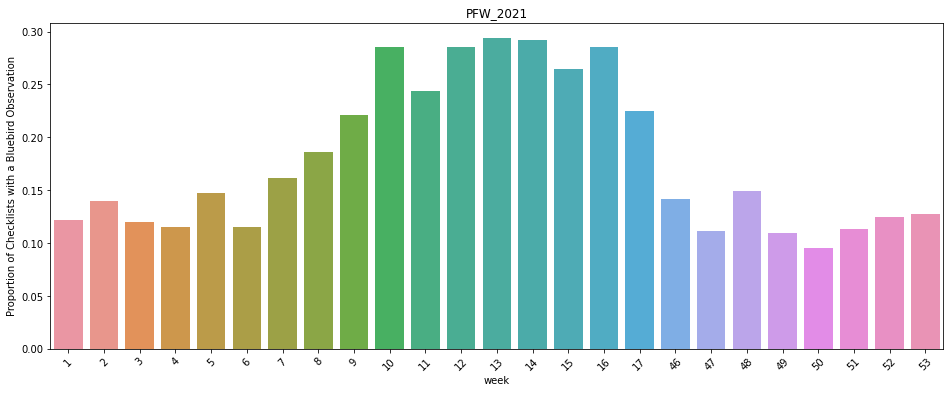

In [ ]:
# Get the number of bluebird observations per week in the chosen period
bb_per_week = pfdata_sub[pfdata_sub['proj_period_id'] == period].groupby('week')['easblu_gr'].sum()

# Get the number of checklists per week in the chosen period
ckl_per_week = pfdata_sub[pfdata_sub['proj_period_id'] == period].groupby('week')['sub_id'].count()

# Get the proportion of checklists, per week, that have a bluebird observation
bb_ckl_week = bb_per_week / ckl_per_week

plt.figure(figsize = (16,6))

sns.barplot(bb_ckl_week.index, bb_ckl_week)
plt.title(period)
plt.xticks(rotation=45)
plt.ylabel("Proportion of Checklists with a Bluebird Observation")

plt.show()

In [ ]:
# Subset from min_week to max_week

min_week = 10
max_week = 16

cond_time = (pfdata.week >= min_week) & (pfdata.week <= max_week)

pfdata_unsup = pfdata[(pfdata.proj_period_id == period) & cond_pos & cond_time].reset_index()
X_unsup = pfdata_unsup[unsup_feat]

X_unsup.sum(axis = 0)

houspa          2707.0000000
tmin           41948.0000000
daejun          5515.0000000
tmax           75009.0000000
houfin          2473.0000000
yerwar             2.0000000
numfeeders      7211.0000000
amegfi          5867.0000000
water_area    319466.8100000
pop_dens      155198.1987988
easblu_gr        397.0000000
dtype: float64

The bird yerwar has only two observations in this filtered dataset.  Remove the yerwar column.

In [ ]:
X_unsup = X_unsup.drop(columns = ['yerwar'])
unsup_feat.remove('yerwar')
unsup_feat

['houspa',
 'tmin',
 'daejun',
 'tmax',
 'houfin',
 'numfeeders',
 'amegfi',
 'water_area',
 'pop_dens',
 'easblu_gr']

In [ ]:
# Reorder 
unsup_feat = ['tmin',
              'tmax',
              'water_area',
              'pop_dens',
              'numfeeders',
              'houfin',
              'amegfi',
              'daejun',
              'houspa',
              'easblu_gr']

Standardize the features.

In [ ]:
scaler = StandardScaler()
X_unsup_std = scaler.fit_transform(X_unsup)

###UMAP

Start tuning the parameters for UMAP to view the dataset in two-dimensional space.

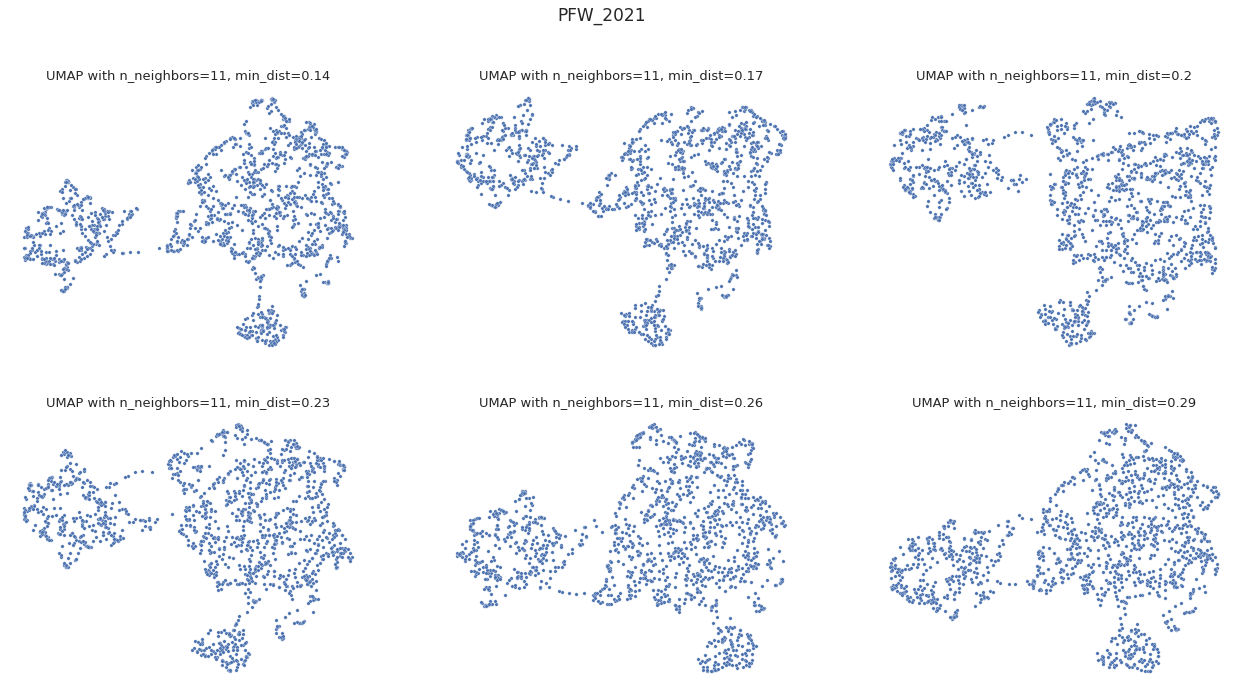

In [ ]:
num_neigh = 11
min_dist_vals = [0.14, 0.17, 0.20, 0.23, 0.26, 0.29]

font_s = 13

plt.figure(figsize = (22,11))
plt.suptitle(period, fontsize=font_s+4)

for idx, val in enumerate(min_dist_vals):
  umap_results = umap.UMAP(n_neighbors=num_neigh, min_dist=val, metric='correlation').fit_transform(X_unsup_std)
  umap_df = pd.DataFrame(umap_results, columns=['umap_0', 'umap_1'])
  
  plt.subplot(2, 3, idx+1)
  sns.scatterplot(data=umap_df, x="umap_0", y="umap_1", s=12)
  plt.title("UMAP with n_neighbors={}, min_dist={}".format(num_neigh, val), size=font_s)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

The minimum distance of 0.17 appears to identify at least 3 significantly sized clusters.

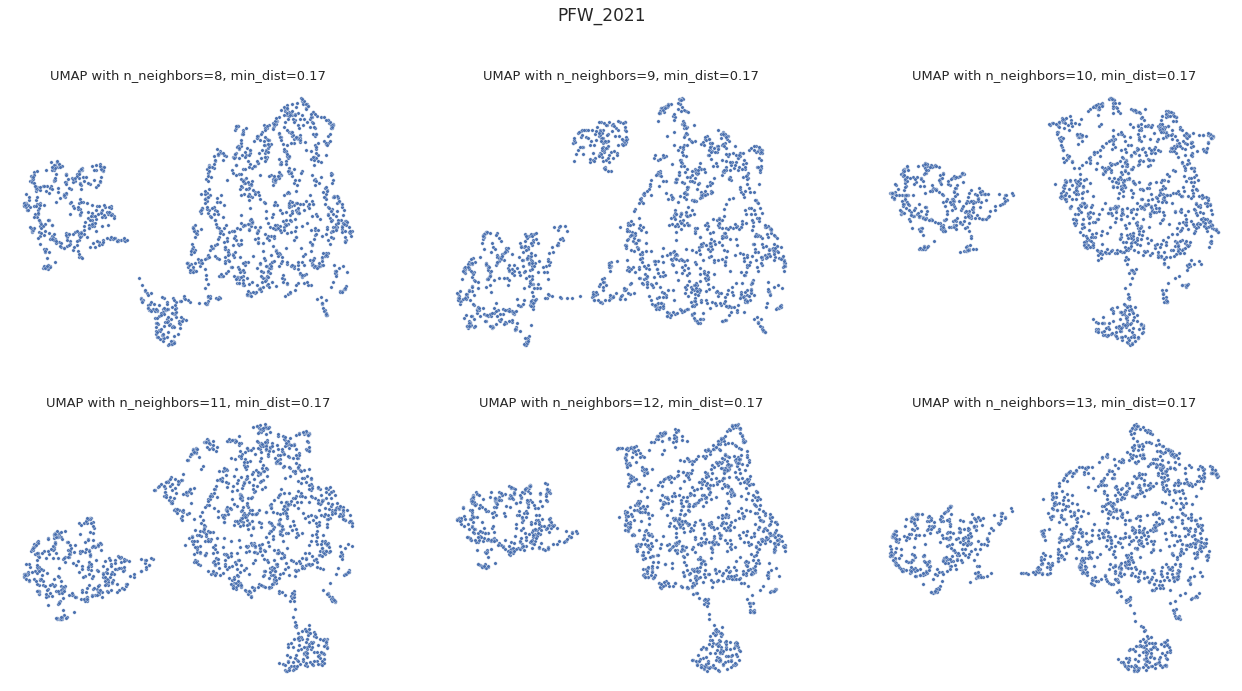

In [ ]:
n_neighbors_vals = [8, 9, 10, 11, 12, 13]
min_d = 0.17

font_s = 13

plt.figure(figsize = (22,11))
plt.suptitle(period, fontsize=font_s+4)

for idx, val in enumerate(n_neighbors_vals):
  umap_results = umap.UMAP(n_neighbors=val, min_dist=min_d, metric='correlation').fit_transform(X_unsup_std)
  umap_df = pd.DataFrame(umap_results, columns=['umap_0', 'umap_1'])
  
  plt.subplot(2, 3, idx+1)
  sns.scatterplot(data=umap_df, x="umap_0", y="umap_1", s=12)
  plt.title("UMAP with n_neighbors={}, min_dist={}".format(val, min_d), size=font_s)
  plt.xticks([])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

Proceed with n_neighbors=11 and min_dist=0.17 since that representation seems to have separation between clusters, while keeping the clusters compact.

Create the UMAP dataframe for the final parameters.

In [ ]:
num_neigh = 11
min_d = 0.17

umap_df = pd.DataFrame(umap.UMAP(n_neighbors=num_neigh, min_dist=min_d, metric='correlation').fit_transform(X_unsup_std), columns=['umap_0', 'umap_1'])

###Agglomerative Clustering

Apply agglomerative clustering to group similar records, and evaluate model performance.  Evaluate with the three linkage methods: complete, average, and ward.

In [ ]:
linkages = ['complete', 'average', 'ward']

First, compare dendograms for the three linkage methods.

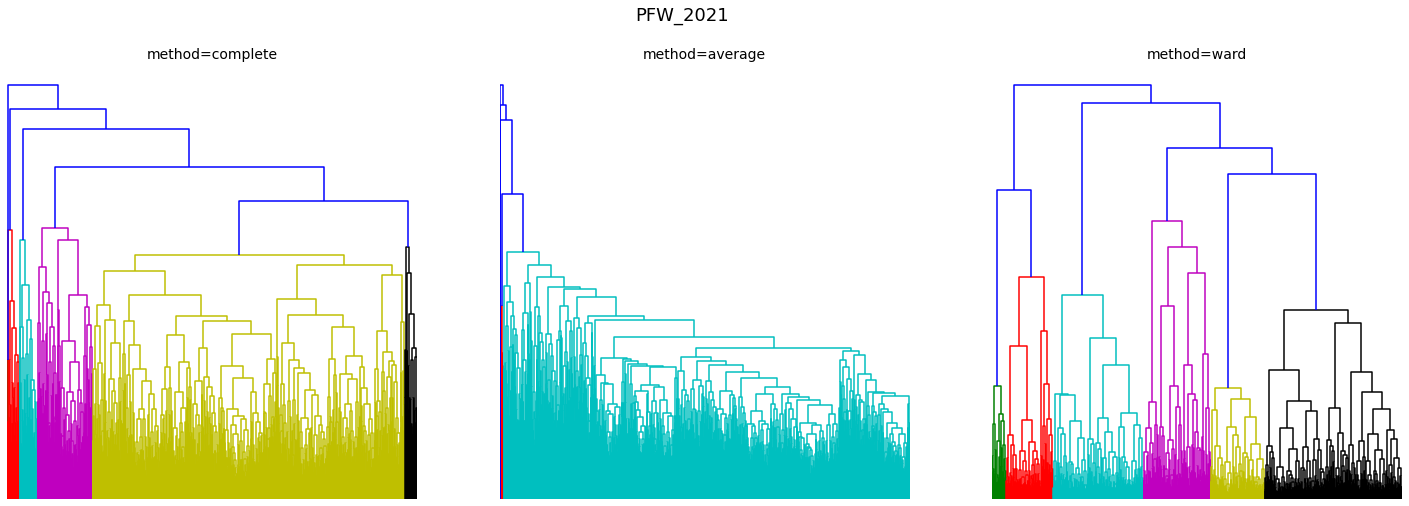

In [ ]:
font_s = 14

plt.figure(figsize = (25,8))
plt.suptitle(period, fontsize=font_s+4)

for idx, link in enumerate(linkages):
  plt.subplot(1, 3, idx+1)
  dendrogram(linkage(X_unsup_std, method=link))
  plt.title("method={}".format(link), size=font_s)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

plt.show()

According to the dendograms, the linkage method, ward, identifies distinct clusters.

Proceed with ward for the agglomerative clustering model.

In [ ]:
method = 'agglomerative_clustering'
linkages = ['ward']
n_clus = [2, 3, 4, 5]

cols = ['proj_period_id', 'method', 'n_clusters', 'silhouette_score', 'params']

umap_preds_df_dict = {}    # Temporary dictionary containing a df of cluster values with UMAP for all param values for a single period.
results_df_list = []    # A list of dfs with key results for all params and periods.
agg_clus_preds_dict = {}    # Dict of dict of dfs containing all cluster values and UMAPs for all params and periods.  Top-level keys are the periods.

for nc in n_clus:

    for link in linkages:

        if link == 'ward':
            aff = 'euclidean'
        else:
            aff = 'cosine'

        params = {'linkage' : link, 'affinity' : aff, 'n_clusters' : nc}

        fit_df = pd.DataFrame(AgglomerativeClustering(**params).fit_predict(X_unsup_std), columns=['y_pred']).reset_index()
        umap_df = umap_df
        concat_df = pd.concat([fit_df, umap_df], axis=1)
        umap_preds_df_dict[str(link)+"n_clus_"+str(nc)] = concat_df

        results_df = pd.DataFrame(columns=cols)

        peri = period

        sil_score = round(metrics.silhouette_score(X_unsup_std, concat_df['y_pred'], metric='euclidean'),4)
        results_list = [peri, method, nc, sil_score, str(params)]

        for ii, val in enumerate(results_list):
            
            results_df.loc[0, cols[ii]] = val

        results_df_list.append(results_df)

agg_clus_preds_dict[peri] = umap_preds_df_dict

umap_preds_df_dict = {}

agg_clus_results_df = pd.concat(results_df_list, ignore_index=True)

Write the agglomerative clustering umaps and clusters to a file.

In [ ]:
with open(fdir + "models/agg_clus_preds.pickle", "wb") as handle:
    pickle.dump(agg_clus_preds_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(fdir + "models/agg_clus_preds.pickle", "rb") as handle:
    agg_clus_preds_dict = pickle.load(handle)

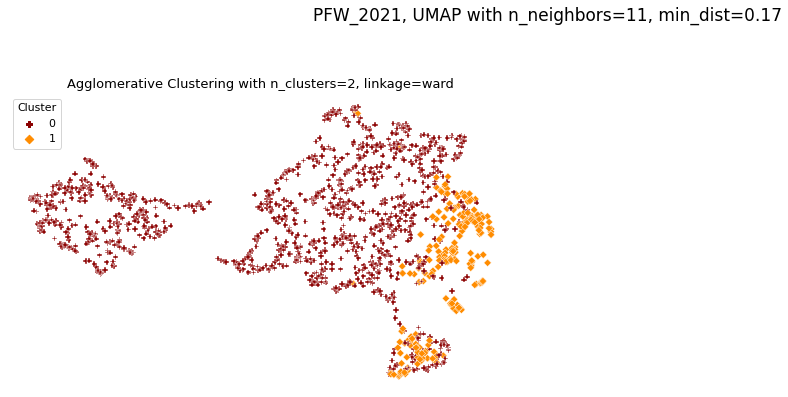

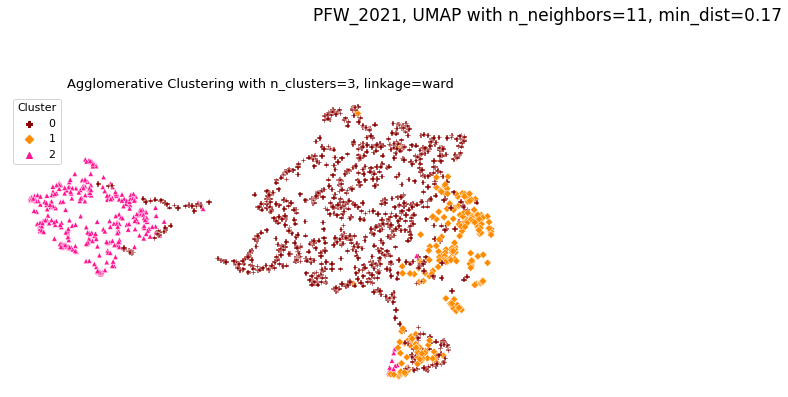

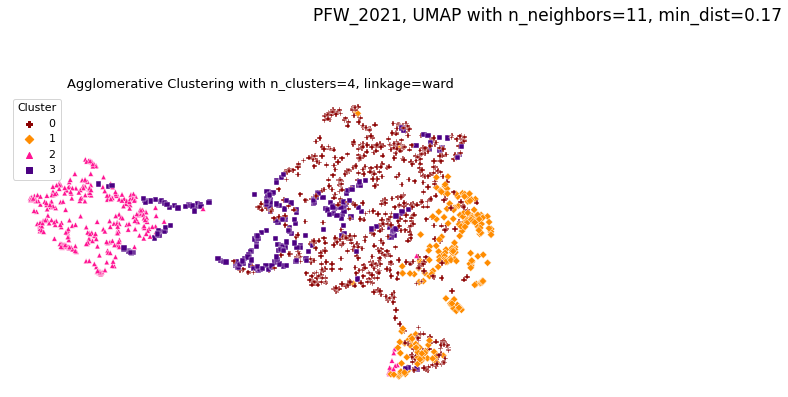

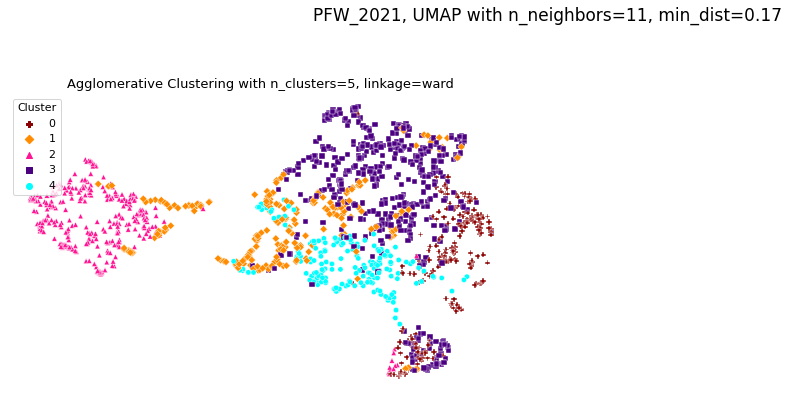

In [ ]:
peri = period

pal={0:'darkred', 1:'darkorange', 2:'deeppink', 3:'indigo', 4:'cyan'}
mark={0:'P', 1:'D', 2:'^', 3:'s', 4:'o'}

font_s = 11

for nc in n_clus:

    plt.figure(figsize = (20,12))
    plt.suptitle(peri + ", UMAP with n_neighbors={}, min_dist={}".format(num_neigh, min_d), fontsize=font_s+6)

    for idx, link in enumerate(linkages):
        plt.subplot(2, 2, idx+1)
        ax = sns.scatterplot(data=agg_clus_preds_dict[peri][str(link)+"n_clus_"+str(nc)], x="umap_0", y="umap_1", hue="y_pred", hue_order=list(np.arange(0, nc)),
                            style="y_pred", s=28, palette=dict((c, pal[c]) for c in list(np.arange(0, nc)) if c in pal),
                            markers=dict((m, mark[m]) for m in list(np.arange(0, nc)) if m in mark))
        legend_labels, _= ax.get_legend_handles_labels()
        lg = ax.legend(legend_labels, list(np.arange(0, nc)), loc='upper left', title='Cluster', fontsize=font_s)
        lg_title = lg.get_title()
        lg_title.set_fontsize(font_s)
        plt.title("Agglomerative Clustering with n_clusters={}, linkage={}".format(nc, link), size=font_s+2)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

    plt.show()
    print('\n')

In [ ]:
agg_clus_results_df.sort_values('silhouette_score', ascending=False)

proj_period_id                    method n_clusters silhouette_score  \
0       PFW_2021  agglomerative_clustering          2           0.1836   
2       PFW_2021  agglomerative_clustering          4           0.1198   
1       PFW_2021  agglomerative_clustering          3           0.1118   
3       PFW_2021  agglomerative_clustering          5           0.0837   

                                              params  
0  {'linkage': 'ward', 'affinity': 'euclidean', '...  
2  {'linkage': 'ward', 'affinity': 'euclidean', '...  
1  {'linkage': 'ward', 'affinity': 'euclidean', '...  
3  {'linkage': 'ward', 'affinity': 'euclidean', '...

The next section will compare the 2, 3, and 4 cluster results, since they were the top three in terms of silhouette score.  The 4-cluster model appears to have scored better than the 3-cluster model because, as shown in the UMAP, it captured a group of points residing mostly between groups 0 and 2.  Each solution has intermingling between clusters to some degree.

Write the agglomerative clustering results to a csv.

In [ ]:
agg_clus_results_df.to_csv(fdir + "models/agg_clus_results.csv")

In [ ]:
agg_clus_results_df = pd.read_csv(fdir + "models/agg_clus_results.csv")
agg_clus_results_df = agg_clus_results_df.drop(columns = 'Unnamed: 0')

###Comparison of Unsupervised Learning Models

In [ ]:
pd.set_option("display.precision", 3)

In [ ]:
# Function to get the means of the clusters and return as a df.

def clus_means(dictio, n_clus, type_link):

    top_preds = pd.concat([pfdata_unsup, dictio[period][type_link + 'n_clus_' + str(n_clus)]['y_pred']], axis=1)

    means = []

    for clus in np.arange(0, n_clus, 1):

        mean = top_preds[top_preds['y_pred'] == clus][unsup_feat].describe().loc[['mean']]
        mean['cluster'] = clus
        mean['count'] = top_preds[top_preds['y_pred'] == clus][unsup_feat].describe().loc[['count']].mode(axis=1)[0][0]
        means.append(mean)

    df = pd.concat(means).sort_values('easblu_gr').set_index('cluster')
    df.insert(0, 'count', df.pop('count'))

    return df

Load the dictionaries containing all cluster values and UMAPs for all parameters.

In [ ]:
with open(fdir + "models/agg_clus_preds.pickle", "rb") as handle:
    agg_clus_preds_dict = pickle.load(handle)

agg_clus_results_df = pd.read_csv(fdir + "models/agg_clus_results.csv")
agg_clus_results_df = agg_clus_results_df.drop(columns = 'Unnamed: 0')

results_df = agg_clus_results_df.sort_values('silhouette_score', ascending=False, ignore_index=True)
results_df

proj_period_id                    method  n_clusters  silhouette_score  \
0       PFW_2021  agglomerative_clustering           2             0.184   
1       PFW_2021  agglomerative_clustering           4             0.120   
2       PFW_2021  agglomerative_clustering           3             0.112   
3       PFW_2021  agglomerative_clustering           5             0.084   

                                              params  
0  {'linkage': 'ward', 'affinity': 'euclidean', '...  
1  {'linkage': 'ward', 'affinity': 'euclidean', '...  
2  {'linkage': 'ward', 'affinity': 'euclidean', '...  
3  {'linkage': 'ward', 'affinity': 'euclidean', '...

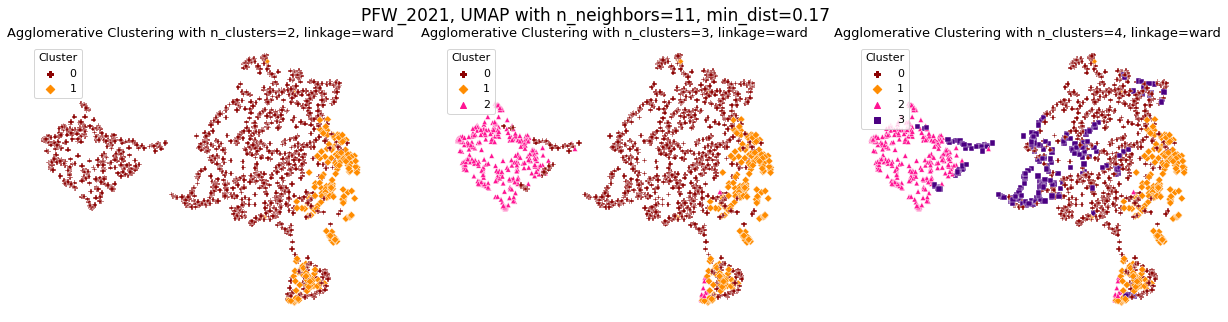

In [ ]:
peri = period
link = 'ward'

pal={0:'darkred', 1:'darkorange', 2:'deeppink', 3:'indigo', 4:'cyan'}
mark={0:'P', 1:'D', 2:'^', 3:'s', 4:'o'}

font_s = 11

plt.figure(figsize = (21,5))
plt.suptitle(peri + ", UMAP with n_neighbors={}, min_dist={}".format(num_neigh, min_d), fontsize=font_s+6)

for idx, nc in enumerate([2, 3, 4]):

    plt.subplot(1, 3, idx+1)
    ax = sns.scatterplot(data=agg_clus_preds_dict[peri][str(link)+"n_clus_"+str(nc)], x="umap_0", y="umap_1", hue="y_pred", hue_order=list(np.arange(0, nc)),
                        style="y_pred", s=28, palette=dict((c, pal[c]) for c in list(np.arange(0, nc)) if c in pal),
                        markers=dict((m, mark[m]) for m in list(np.arange(0, nc)) if m in mark))
    legend_labels, _= ax.get_legend_handles_labels()
    lg = ax.legend(legend_labels, list(np.arange(0, nc)), loc='upper left', title='Cluster', fontsize=font_s)
    lg_title = lg.get_title()
    lg_title.set_fontsize(font_s)
    plt.title("Agglomerative Clustering with n_clusters={}, linkage={}".format(nc, link), size=font_s+2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

The following three dataframes present the means of each feature for each of the 3 solutions.

In [ ]:
print("2-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 2, 'ward')

2-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                     
1         213.0  30.723  53.333     823.933   293.832       6.047   1.770   
0        1214.0  29.163  52.429     118.591    76.287       4.879   1.727   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
1         2.972   2.413   2.455      0.146  
0         4.311   4.119   1.799      0.301

In [ ]:
print("3-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 3, 'ward')

3-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                    
0        900.0  28.959  52.247     120.065    69.170       5.076   1.760   
1        213.0  30.723  53.333     823.933   293.832       6.047   1.770   
2        314.0  29.748  52.952     114.364    96.684       4.315   1.631   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
0         4.583   4.334   1.971      0.058  
1         2.972   2.413   2.455      0.146  
2         3.532   3.503   1.306      1.000

In [ ]:
print("4-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 4, 'ward')

4-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                    
0        665.0  28.850  52.020     137.709    70.094       3.823   1.546   
1        213.0  30.723  53.333     823.933   293.832       6.047   1.770   
3        235.0  29.268  52.889      70.137    66.555       8.621   2.366   
2        314.0  29.748  52.952     114.364    96.684       4.315   1.631   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
0         2.740   3.472   1.319      0.000  
1         2.972   2.413   2.455      0.146  
3         9.800   6.774   3.817      0.221  
2         3.532   3.503   1.306      1.000

Examining the 2, 3, and 4 cluster solutions versus the heat map below, the only strong conclusion can be made with the 2-cluster model, which has the highest silhouette score.  It follows the heat map and the general notion that house sparrows are more populous in highly developed areas (high population density), and the likelihood of an eastern bluebird observation drops in highly developed areas with house sparrows, which take over nesting cavities.

The other models do not follow this common notion, but they also have lower scores.

Note that water_area and pop_dens are at the county level, and tmin and tmax are from gridded data.  Additional data with more features about the observation sites at a more granular detail would be beneficial in further exploring local influences on bluebird presence/absence.  Perhaps with additional detail, an accurate 3 or 4 cluster model could be obtained to more clearly identify reasons for shifts between presence and absence.



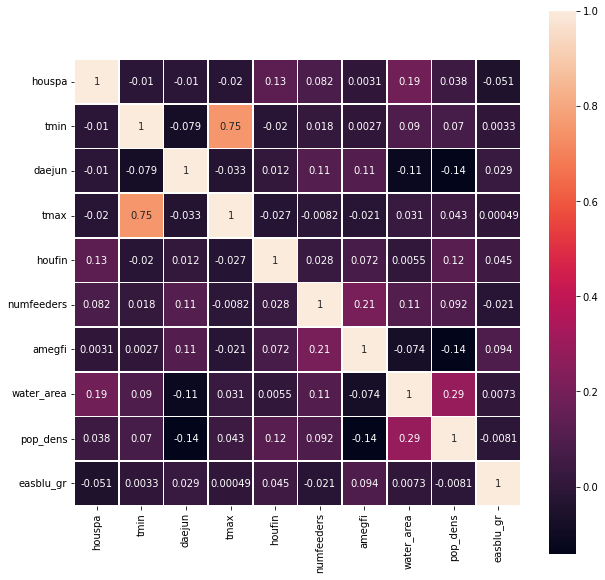

In [ ]:
plt.figure(figsize=(10, 10))

sns.heatmap(X_unsup.corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

##Conclusions and Next Steps

In [ ]:
bb_corr = pfdata[X.columns.tolist() + ['easblu_gr']].corr()['easblu_gr'][:].sort_values(ascending=False)
bb_corr

easblu_gr             1.000
carwre                0.239
yerwar                0.214
normoc                0.172
carchi                0.169
tmax                  0.158
day_in_period         0.140
tmin                  0.135
norfli                0.123
rebwoo                0.115
proj_period           0.103
evgr_shrbs_atleast    0.099
houfin                0.089
whtspa                0.084
amerob                0.078
amecro                0.059
amegfi                0.054
effort_hrs_atleast    0.049
dowwoo                0.047
norcar                0.041
pop_dens              0.040
numfeeders            0.029
eursta                0.027
tuftit                0.012
pcpn                  0.010
whbnut                0.005
daejun               -0.010
moudov               -0.052
longitude            -0.061
water_area           -0.074
blujay               -0.079
houspa               -0.123
ruc_2013             -0.142
bkcchi               -0.164
latitude             -0.273
Name: easblu_gr, dty

In [ ]:
hs_corr = pfdata[X.columns.tolist() + ['easblu_gr']].corr()['houspa'][:].sort_values(ascending=False)
hs_corr

houspa                1.000
latitude              0.156
blujay                0.116
norcar                0.115
eursta                0.114
pop_dens              0.101
moudov                0.091
houfin                0.086
numfeeders            0.078
dowwoo                0.077
effort_hrs_atleast    0.052
water_area            0.041
rebwoo                0.040
whbnut                0.030
bkcchi                0.030
amerob                0.021
daejun                0.017
amegfi                0.012
norfli                0.006
amecro                0.002
pcpn                 -0.009
normoc               -0.013
whtspa               -0.022
ruc_2013             -0.025
proj_period          -0.043
evgr_shrbs_atleast   -0.061
tuftit               -0.064
yerwar               -0.067
carwre               -0.068
tmin                 -0.072
carchi               -0.073
day_in_period        -0.088
longitude            -0.090
tmax                 -0.110
easblu_gr            -0.123
Name: houspa, dtype:

In [ ]:
gb_results[['mean_fit_time', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score']].head(1)

mean_fit_time  mean_test_accuracy_score  std_test_accuracy_score  \
4       1579.514                     0.875                3.974e-04   

   mean_test_precision_score  mean_test_recall_score  
4                      0.828                   0.678

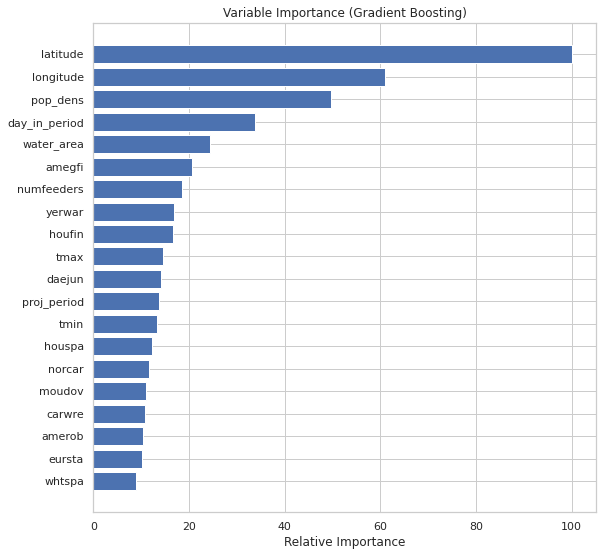

In [ ]:
plt.figure(figsize = (9,9))

plot_feat_imp(gbg.best_estimator_, 'Gradient Boosting', 20, X)

plt.show()

In [ ]:
print("2-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 2, 'ward')

2-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                     
1         213.0  30.723  53.333     823.933   293.832       6.047   1.770   
0        1214.0  29.163  52.429     118.591    76.287       4.879   1.727   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
1         2.972   2.413   2.455      0.146  
0         4.311   4.119   1.799      0.301

Conclusions:
*  Among the classification models evaluated for predicting eastern bluebird presence/absence, the gradient boosting model is the best performer with a test accuracy score of 0.875, a precision score of 0.828, and a reasonable recall score of 0.678.  Moreover, it proves to be generalizable, as the cross-validation resulted in consistent scores.
* With the combination of the GBM model with resulting feature importance and the unsupervised learning, interactions between variables could be identified, such as the negative interaction between the eastern bluebird and the house sparrow.
*  On the other hand, some bird species, such as the american goldfinch, have high feature importance, positively influencing the presence of eastern bluebirds.
*  Aside from latitude, longitude, and time variables with high feature importance, population density and water area proved to be important even though those variables are at the county level.


Potential next steps:
*  Integrate gridded land cover data from the National Land Cover Database (NLCD).  This would provide an additional dimension to more clearly explore local habitat influences, especially through unsupervised learning.

*  Aggregate with additional bird observation sources, such as the Audubon Christmas Bird Count.
* Look into other ways to improve the spatial and temporal distribution of the data, and to improve the data balance of bluebird presence/absence without doing it artificially.

For the use case of this model, consider the current conservation efforts as well as existing technology used by birders.  There are some birding organizations specifically dedicated to the conservation and resurgence of the eastern bluebird.  One common conservation method is to install nest boxes that are resistant to invasive birds.  Cornell Lab and other organizations have bird identification apps.  This classification model could be used as an enhancement to an app to give information on expected bluebird presence.  Furthermore, an improved unsupervised learning model could help identify areas where nest boxes would be beneficial to target bluebird decline.